In [219]:
import sqlite3
from ete3 import PhyloTree
db = sqlite3.connect('./drosophilaDatabaseNew2')
db.isolation_level = None
cursor = db.cursor()

In [220]:
def mann_whitney_effect_size(list1, list2):
    import math
    from scipy import stats
    n1 = len(list1)
    n2 = len(list2)
    N = sum([n1,n2])
    U = stats.mannwhitneyu(list1, list2, alternative = 'two-sided').statistic
    mean = U-((n1*n2)/2)
    sd = math.sqrt((n1*n2*(n1+n2+1))/12)
    z = mean/sd
    r = z/math.sqrt(N)
    return(r)

In [18]:
# get longest protein for each gene - fasta from biomart
import re
pLenDict = {}
with open('dere_full_prot.fasta','r') as file:
    for line in file:
        if line.startswith('>'):
            try:
                prot = re.search('\|(.*)\|',line).group(1)
                gene = re.search('>(.*)\|F',line).group(1)
                pLen = int(re.search('\|.*\|(.*)$',line).group(1))
            except AttributeError: #no sequence available: header line only has the gene id
                continue
            
            try:
                if pLenDict[gene][1] < pLen:
                    pLenDict[gene] = (prot,pLen)
            except KeyError:
                pLenDict[gene] = (prot,pLen)
for key in pLenDict:
    pLenDict[key] = pLenDict[key][0]

In [59]:
# create fasta with only longest protein
import requests
with open('dere_full_prot.fasta','r') as file, open('dere_longest_prot_only.fasta','w') as out:
    protID = ''
    for line in file:
        if line.startswith('>'):
            longest = False
            try:
                prot = re.search('\|(.*)\|',line).group(1)
                gene = re.search('>(.*)\|F',line).group(1)
            except AttributeError:
                continue
            try:
                if prot == pLenDict[gene]: #if prot is the longest protein
                    longest = True
                    protID = prot
                    out.write(line)
                else:
                    continue
            except KeyError:
                print(line)
        else:
            if longest == True:
                if line == 'XXXXXX\n': # weird cases where biomart gives this as the sequence but api doesn't
                    
                    url = 'http://rest.ensembl.org/sequence/id/' + protID + '?'
                    headers= {'Content-Type':'text/x-fasta'}
                    r = requests.get(url, headers=headers)
                    res = r.text.split('\n')
                    seq = '\n'.join(res[1:])
                    out.write(seq)
                else:
                    out.write(line)
            else:
                continue

In [60]:
%%bash
makeblastdb -in dere_longest_prot_only.fasta -dbtype prot
time blastp -db dere_longest_prot_only.fasta -query dere_longest_prot_only.fasta -out dere.out -outfmt 6
awk -v 'OFS=\t' -v 'FS=\t' '{if($11 < 0.1) print $0}' dere.out > dere.filtered.out



Building a new DB, current time: 05/09/2019 15:21:15
New DB name:   /Users/zoevance/dere_longest_prot_only.fasta
New DB title:  dere_longest_prot_only.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /Users/zoevance/dere_longest_prot_only.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 13605 sequences in 0.792541 seconds.



real	193m2.586s
user	177m39.097s
sys	0m35.093s


In [61]:
# create list of singletons from blast output
with open('dere.filtered.out', 'r') as file:
    gL = []
    for line in file:
        line = line.strip().split('\t')
        ids = line[0].split('|')
        gL.append(ids[1])
sing_count = 0
sing_list = []
for x in set(gL):
    if gL.count(x) == 1:
        sing_count += 1
        sing_list.append(x)


In [62]:
sing_count

3272

In [65]:
# use ensembl api to get gene trees and prune to get drosophila tree
# cursor.execute('DROP TABLE singleton_trees')
import requests, json, time
from ete3 import PhyloTree
count, ti = 0, time.time()
noTree, noTreeList = 0, []
geneTreeDict, geneTreePrunedDict = {},{}
cursor.execute('CREATE TABLE IF NOT EXISTS singleton_trees(id TEXT, baseTree BLOB, prunedTree BLOB, excludedReason TEXT, split TEXT)')
print('Fetching gene trees...')
for g in sing_list:
    url = 'http://rest.ensembl.org/genetree/member/id/'+ g + '?compara=metazoa;nh_format=display_label_composite;object_type=Translation;'
    headers = {'Content-Type':'text/x-nh'}
    tree = requests.get(url, headers=headers).text
    if "error" in tree:
        noTree += 1
        noTreeList.append(g)
        geneTreeDict[g] = None
    else:
        geneTreeDict[g] = tree
    count += 1
    if count % 200 == 0:
        print(count, 'done', round(time.time()-ti, 2), 'seconds')
print('Pruning...')
count, ti = 0, time.time()
for g in geneTreeDict:
    if geneTreeDict[g] == None:
        cursor.execute('INSERT INTO singleton_trees(id,excludedReason) VALUES (?,?)', (g,'No tree'))
        continue                   
    try:
        t = PhyloTree(geneTreeDict[g])
    except:
        print('tree making failed')
        print(g)
    pList = []
    nodes = ['Dere', 'Dyak', 'Dsec', 'Dsim', 'Dmel']
    for n in nodes:
        for node in t.traverse():
            if n in node.name:
                 pList.append(node.name)
    try:
        t.prune(pList, preserve_branch_length=True)
    except:
        print('pruning failed')
        print(t)
    geneTreePrunedDict[g] = str(t.write())
    cursor.execute('INSERT INTO singleton_trees(id,baseTree,prunedTree) VALUES (?,?,?)', (g,geneTreeDict[g],geneTreePrunedDict[g]))
    count += 1
    if count % 200 == 0:
        print(count, 'done', round(time.time()-ti,2), 'seconds')
db.commit()

Fetching gene trees...
200 done 165.83 seconds
400 done 229.87 seconds
600 done 292.79 seconds
800 done 345.05 seconds
1000 done 397.43 seconds
1200 done 447.77 seconds
1400 done 495.13 seconds
1600 done 540.2 seconds
1800 done 582.47 seconds
2000 done 622.19 seconds
2200 done 663.14 seconds
2400 done 701.19 seconds
2600 done 740.58 seconds
2800 done 784.31 seconds
3000 done 840.9 seconds
3200 done 902.88 seconds
Pruning...
200 done 4.44 seconds
400 done 8.13 seconds
600 done 13.04 seconds
800 done 17.25 seconds
1000 done 20.98 seconds
1200 done 25.18 seconds
1400 done 29.09 seconds
1600 done 33.66 seconds
1800 done 38.87 seconds
2000 done 43.73 seconds
2200 done 50.88 seconds
2400 done 54.84 seconds
2600 done 59.99 seconds
2800 done 64.84 seconds
3000 done 69.7 seconds


In [66]:
# check for missing outgroups
singTreeListPrunedMissingChecked, somethingMissing = [],0
for g in geneTreePrunedDict:
    tree = PhyloTree(geneTreePrunedDict[g])
    yak = False
    for node in tree.traverse():
        if 'Dyak' in node.name:
            yak = True

    if yak == True:
        singTreeListPrunedMissingChecked.append(g)
    else:
        cursor.execute('UPDATE singleton_trees SET excludedReason = "Outgroup missing" WHERE id == ?', (g,))
        somethingMissing += 1
print(somethingMissing)

79


In [70]:
# check for multiple copies in outgroup
# cursor.execute('ALTER TABLE singleton_trees ADD COLUMN notes TEXT')
singTreeOneEach, singTreeMulti = [], []
for g in singTreeListPrunedMissingChecked:
    tree = PhyloTree(geneTreePrunedDict[g])
    yak, ere = 0,0
    for node in tree.traverse():
        if 'Dere' in node.name:
            ere += 1
        if 'Dyak' in node.name:
            yak += 1
    if ere == 1 and yak == 1:
        singTreeOneEach.append(g)
    else:
        cursor.execute('UPDATE singleton_trees SET notes = "Multiple copies in outgroup" WHERE id == ?', (g,))
        singTreeMulti.append(g)

In [75]:
top_dict = {}
for g in singTreeMulti:
    top = PhyloTree(geneTreePrunedDict[g]).get_topology_id(attr='species')
    try:
        top_dict[top].append(g)
    except KeyError:
        top_dict[top] = [g]
# cursor.execute('ALTER TABLE singleton_trees ADD COLUMN tree_top_id INTEGER')
for top in top_dict:
    for g in top_dict[top]:
        cursor.execute('UPDATE singleton_trees SET tree_top_id = ? WHERE id == ?',(top,g))

In [9]:
def get_species(name):
    return(name[-4:])
for g in singTreeMulti:
    tree = PhyloTree(geneTreePrunedDict[g])
    for n in tree.traverse():
        n.set_species_naming_function(get_species)

#     sp = n.name[-4:]
#     n.add_feature('species', sp)

In [7]:
id_list = []
for key in top_dict:
    id_list.append(key)

In [8]:
cursor.execute('UPDATE singleton_trees SET excludedReason = ? WHERE excludedReason == "Multiple copies in outgroup-split not possible/subtrees unsuitable"',(None,))
cursor.execute('SELECT id, prunedTree FROM singleton_trees WHERE excludedReason IS NULL')
geneTreePrunedDict = dict(cursor.fetchall())
cursor.execute('SELECT id FROM singleton_trees WHERE notes == "Multiple copies in outgroup"')
singTreeMulti = [x[0] for x in cursor.fetchall()]

In [77]:
manualDict = {}
for top in top_dict:
    PhyloTree(geneTreePrunedDict[top_dict[top][0]]).show()
    manualDict[top] = input('Opinion?')

Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?Y
Opinion?Y
Opinion?Y
Opinion?Y
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?Y
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?N
Opinion?Y


In [80]:
exTopList = [x for x in manualDict if manualDict[x] == 'N']
exSingMultiTreesList = [top_dict[x] for x in top_dict if x in exTopList]
exclGenes = flatten(exSingMultiTreesList)
for g in exclGenes:
    cursor.execute('UPDATE singleton_trees SET split = "F" WHERE id == ?',(g,))
    cursor.execute('UPDATE singleton_trees SET excludedReason = "Multiple copies in outgroup-split not possible/subtrees unsuitable" WHERE id == ?',(g,))
db.commit()

In [10]:
cursor.execute('UPDATE singleton_trees SET excludedReason = "Multiple copies in outgroup-split not possible/subtrees unsuitable" WHERE split == "F"')

In [81]:
splitTopList = [x for x in manualDict if manualDict[x] == 'Y']
splitSingMultiTreesList = [top_dict[x] for x in top_dict if x in splitTopList]
splitTreeGenes = flatten(splitSingMultiTreesList)
for g in splitTreeGenes:
    cursor.execute('UPDATE singleton_trees SET split = "T" WHERE id == ?',(g,))
db.commit()

In [11]:
def flatten(List):
    outList = []
    for subList in List:
        outList.extend(subList)
    return(outList)

In [15]:
cursor.execute('SELECT id FROM singleton_trees WHERE notes IS NULL')
singTreeOneEach = [x[0] for x in cursor.fetchall()]
for g in singTreeOneEach:
    tree = PhyloTree(geneTreePrunedDict[g])
    for n in tree.traverse():
        n.set_species_naming_function(get_species)

NameError: name 'get_species' is not defined

In [16]:
top_dict_one_each = {}
for i in range(0, len(singTreeOneEach)):
    top = singTreeOneEach[i].get_topology_id(attr='species')
    try:
        top_dict_one_each[top].append(i)
    except KeyError:
        top_dict_one_each[top] = [i]
print(len(top_dict_one_each))

AttributeError: 'str' object has no attribute 'get_topology_id'

In [12]:
def fancy_node_search(node,name):
    if name in node.name:
        return True
    else:
        return False

In [6]:
cursor.execute('SELECT id, prunedTree FROM singleton_trees')
geneTreePrunedDict = dict(cursor.fetchall())

In [14]:
# splitting trees into usable subtrees: now inserts into database every so often
import re
cursor.execute('CREATE TABLE IF NOT EXISTS processed_trees(id TEXT, tree BLOB, excludedReason TEXT)')
cursor.execute('SELECT id, prunedTree FROM singleton_trees WHERE (excludedReason IS NULL) AND (notes IS NULL)')
finalTreeDict = dict(cursor.fetchall())
exSingMultiTreesList2 = []
finalTrees = []
redoList = []

nodeNonsense = []

count = 0
# tree splitting
cursor.execute('SELECT id FROM singleton_trees WHERE split == "T"')
splitSingMultiTreesList = [x[0] for x in cursor.fetchall()]
for g in splitSingMultiTreesList:
    count += 1
    error = False
    currentTreeSplits = []
    currentIndex = splitSingMultiTreesList.index(g)
    tree = PhyloTree(geneTreePrunedDict[g])
    tree.show()
    multi = input('Multiple usable trees?')
    if multi == 'No':
        try:
            node1Name = input('Node 1? ')
            node2Name = input('Node 2? ')
            if node1Name == 'Forgot':
                tree.show()
                node1Name = input('Node 1? ')
                node2Name = input('Node 2? ')
            node1 = [x for x in filter(lambda node: fancy_node_search(node, node1Name.strip()),tree.traverse())][0]
            node2 = [x for x in filter(lambda node: fancy_node_search(node, node2Name.strip()),tree.traverse())][0]
            #     get common ancester to detach at
            splitTreeNode = node1.get_common_ancestor(node2)
            # pretty sure detach will give the tree below that node
            splitTree = splitTreeNode.detach()
            splitTree.show()
            okay = input('Okay?')
            if okay == 'Y':
                currentTreeSplits.append(splitTree)
            elif okay == 'N':
                break
            else:
                check = input('All good?')
        except AttributeError:
                nodeNonsense.append(g, geneTreePrunedDict[g])
                continue
                error = True
    elif multi == 'Yes':
        done = 'Y'
        while done == 'Y':
            try:
                tree.show()
                node1Name = input('Node 1? ')
                node2Name = input('Node 2? ')
                node1 = [x for x in filter(lambda node: fancy_node_search(node, node1Name.strip()),tree.traverse())][0]
                node2 = [x for x in filter(lambda node: fancy_node_search(node, node2Name.strip()),tree.traverse())][0]
                #     get common ancester to detach at
                splitTreeNode = node1.get_common_ancestor(node2)
                # pretty sure detach will give the tree below that node
                splitTree = splitTreeNode.detach()
                splitTree.show()
                okay = input('Okay?')
                if okay == 'Y':
                    currentTreeSplits.append(splitTree)
                elif okay == 'N':
                    break
                else:
                    check = input('All good?')
                    if check == 'Y':
                        currentTreeSplits.append(splitTree)
                    elif check == 'N':
                        break

                done = input('Any more trees?')
            except AttributeError:
                print('Something went wrong with the tree: unfinished!!')
                nodeNonsense.append((g, geneTreePrunedDict[g]))
                done = 'N'
                error = True
            except:
                done = 'Y'
                print('Try again!')
                
        
    else:
        check = input('Did you mean to do that?')
        if check == 'No':
            redoList.append(g)
        elif check == 'Yes':
            exSingMultiTreesList2.append(g)
    if not error:
        finalTrees.extend(currentTreeSplits)
    if count%10 == 0:
        print("You've done " + str(count) + ', good job!')
        for tree in finalTrees:
            for node in tree.traverse():
                if 'Dere' in node.name:
                    geneName = re.search('.*_(FB.*)_',node.name).group(1)
                    finalTreeDict[geneName] = tree.write()


        for g in finalTreeDict:
            cursor.execute('INSERT INTO processed_trees(id,tree) VALUES (?,?)', (g,finalTreeDict[g]))
        db.commit()
        finalTreeDict = {}


Multiple usable trees?Yes
Node 1? FBpp0308005
Node 2? FBpp0142719
Okay?Y
Any more trees?Y
Node 1? FBpp0303077
Node 2? FBpp0134720
Okay?Y
Any more trees?Y
Node 1? FBpp0077350
Node 2? FBpp0143008
Okay?Y
Any more trees?N
Multiple usable trees?No
Node 1? FBpp0311598
Node 2? FBpp0140682
Okay?Y
Multiple usable trees?Yes
Node 1? FBpp0080322
Node 2? FBpp0142739
Okay?Y
Any more trees?Y
Node 1? FBpp0303860
Node 2? FBpp0143741
Okay?Y
Any more trees?Y
Node 1? FBpp0081861
Node 2? FBpp0136657
Okay?Y
Any more trees?N
Multiple usable trees?Y
Did you mean to do that?No
Multiple usable trees?Yes
Node 1? FBpp0079628
Node 2? FBpp0366187
Okay?Y
Any more trees?Y
Node 1? FBpp0297779
Node 2? FBpp0128997
Okay?Y
Any more trees?N
Multiple usable trees?Yes
Node 1? FBpp0075809
Node 2? FBpp0132428
Okay?Y
Any more trees?Y
Node 1? FBpp0076532
Node 2? FBpp0265407
Okay?Y
Any more trees?N
Multiple usable trees?No
Node 1? FBpp0302541
Node 2? FBpp0358770
Okay?Y
Multiple usable trees?No
Node 1? FBpp0401605
Node 2? FBpp0353

In [26]:
# going back over failed iterations
failedIDs = [splitSingMultiTreesList[i] for i in [3,18,25,36,48]]
for g in failedIDs:
    count += 1
    error = False
    currentTreeSplits = []
    currentIndex = splitSingMultiTreesList.index(g)
    tree = PhyloTree(geneTreePrunedDict[g])
    tree.show()
    multi = input('Multiple usable trees?')
    if multi == 'No':
        try:
            node1Name = input('Node 1? ')
            node2Name = input('Node 2? ')
            if node1Name == 'Forgot':
                tree.show()
                node1Name = input('Node 1? ')
                node2Name = input('Node 2? ')
            node1 = [x for x in filter(lambda node: fancy_node_search(node, node1Name.strip()),tree.traverse())][0]
            node2 = [x for x in filter(lambda node: fancy_node_search(node, node2Name.strip()),tree.traverse())][0]
            #     get common ancester to detach at
            splitTreeNode = node1.get_common_ancestor(node2)
            # pretty sure detach will give the tree below that node
            splitTree = splitTreeNode.detach()
            splitTree.show()
            okay = input('Okay?')
            if okay == 'Y':
                currentTreeSplits.append(splitTree)
            elif okay == 'N':
                break
            else:
                check = input('All good?')
        except AttributeError:
                nodeNonsense.append(g, geneTreePrunedDict[g])
                continue
                error = True
    elif multi == 'Yes':
        done = 'Y'
        while done == 'Y':
            try:
                tree.show()
                node1Name = input('Node 1? ')
                node2Name = input('Node 2? ')
                node1 = [x for x in filter(lambda node: fancy_node_search(node, node1Name.strip()),tree.traverse())][0]
                node2 = [x for x in filter(lambda node: fancy_node_search(node, node2Name.strip()),tree.traverse())][0]
                #     get common ancester to detach at
                splitTreeNode = node1.get_common_ancestor(node2)
                # pretty sure detach will give the tree below that node
                splitTree = splitTreeNode.detach()
                splitTree.show()
                okay = input('Okay?')
                if okay == 'Y':
                    currentTreeSplits.append(splitTree)
                elif okay == 'N':
                    break
                else:
                    check = input('All good?')
                    if check == 'Y':
                        currentTreeSplits.append(splitTree)
                    elif check == 'N':
                        break

                done = input('Any more trees?')
            except AttributeError:
                print('Something went wrong with the tree: unfinished!!')
                nodeNonsense.append((g, geneTreePrunedDict[g]))
                done = 'N'
                error = True
            except:
                done = 'Y'
                print('Try again!')
                
        
    else:
        check = input('Did you mean to do that?')
        if check == 'No':
            redoList.append(g)
        elif check == 'Yes':
            exSingMultiTreesList2.append(g)
    if not error:
        finalTrees.extend(currentTreeSplits)

    for tree in finalTrees:
        for node in tree.traverse():
            if 'Dere' in node.name:
                geneName = re.search('.*_(FB.*)_',node.name).group(1)
                finalTreeDict[geneName] = tree.write()


    for g in finalTreeDict:
        cursor.execute('INSERT INTO processed_trees(id,tree) VALUES (?,?)', (g,finalTreeDict[g]))
    db.commit()
    finalTrees, finalTreeDict = [],{}
            

Multiple usable trees?Yes
Node 1? FBpp0070875
Node 2? FBpp0138138
Okay?Y
Any more trees?Y
Node 1? FBpp0084759
Node 2? FBpp0130199
Okay?Y
Any more trees?N
Multiple usable trees?No
Node 1? FBpp0111644
Node 2? FBpp0370980
Okay?Y
Multiple usable trees?Yes
Node 1? FBpp0111715
Node 2? FBpp0366196
Okay?Y
Any more trees?Y
Node 1? FBpp0297780
Node 2? FBpp0128703
Okay?Y
Any more trees?Y
Node 1? FBpp0081972
Node 2? FBpp0269571
Okay?Y
Any more trees?N
Multiple usable trees?Yes
Node 1? FBpp0111998
Node 2? FBpp0369708
Okay?N
Multiple usable trees?Yes
Node 1? FBpp0079109
Node 2? FBpp0259624
Okay?Y
Any more trees?Y
Node 1? FBpp0087336
Node 2? FBpp0141256
Okay?Y
Any more trees?N


In [30]:
# nonsense for dealing with the one really large tree: displays the whole tree every round
for g in splitSingMultiTreesList[36:37]:
    currentTreeSplits = []
    currentIndex = splitSingMultiTreesList.index(g)
    tree = PhyloTree(geneTreePrunedDict[g])
    tree.show()
    done = 'Y'
    while done == 'Y':
        try:
            tree = PhyloTree(geneTreePrunedDict[g])
            tree.show()
            node1Name = input('Node 1? ')
            node2Name = input('Node 2? ')
            node1 = [x for x in filter(lambda node: fancy_node_search(node, node1Name.strip()),tree.traverse())][0]
            node2 = [x for x in filter(lambda node: fancy_node_search(node, node2Name.strip()),tree.traverse())][0]
            #     get common ancester to detach at
            splitTreeNode = node1.get_common_ancestor(node2)
            # pretty sure detach will give the tree below that node
            splitTree = splitTreeNode.detach()
            splitTree.show()
            okay = input('Okay?')
            if okay == 'Y':
                currentTreeSplits.append(splitTree)
            elif okay == 'N':
                break
            else:
                check = input('All good?')
                if check == 'Y':
                    currentTreeSplits.append(splitTree)
                elif check == 'N':
                    break

            done = input('Any more trees?')
        except AttributeError:
            print('Something went wrong with the tree: unfinished!!')
            nodeNonsense.append((g, geneTreePrunedDict[g]))
            done = 'N'
            error = True
        except:
            done = 'Y'
            print('Try again!')

        

    if not error:
        finalTrees.extend(currentTreeSplits)
    for tree in finalTrees:
        for node in tree.traverse():
            if 'Dere' in node.name:
                geneName = re.search('.*_(FB.*)_',node.name).group(1)
                finalTreeDict[geneName] = tree.write()


    for g in finalTreeDict:
        cursor.execute('INSERT INTO processed_trees(id,tree) VALUES (?,?)', (g,finalTreeDict[g]))
    db.commit()

Node 1? FBpp0072973
Node 2? FBpp0132829
Okay?Y
Any more trees?Y
Node 1? FBpp0288411
Node 2? FBpp0266119
Okay?Y
Any more trees?Y
Node 1? FBpp0311771
Node 2? FBpp0263982
Okay?Y
Any more trees?Y
Node 1? FBpp0086273
Node 2? FBpp0140811
Okay?Y
Any more trees?Y
Node 1? FBpp0086301
Node 2? FBpp0139150
Okay?Y
Any more trees?Y
Node 1? FBpp0072030
Node 2? FBpp0138571
Okay?Y
Any more trees?N


In [19]:
# getting the last tree
for tree in finalTrees[-1]:
    for node in tree.traverse():
        if 'Dere' in node.name:
            geneName = re.search('.*_(FB.*)_',node.name).group(1)
            finalTreeDict[geneName] = tree.write()
for g in finalTreeDict:
    cursor.execute('INSERT INTO processed_trees(id,tree) VALUES (?,?)', (g,finalTreeDict[g]))
    db.commit()

In [34]:
# none excluded here, only thing in that list is a duplicate tree -not run this round
for g in exSingMultiTreesList2:
    cursor.execute('UPDATE singleton_trees SET excludedReason = "Multiple copies in outgroup-split not possible/subtrees unsuitable" WHERE id == ?',(g,))
db.commit()

In [31]:
cursor.execute('ALTER TABLE processed_trees ADD COlUMN dup_status TEXT')

In [37]:
# remove duplicate entries
cursor.execute('''DELETE FROM processed_trees
                    WHERE rowid NOT IN 
                    (
                      SELECT MIN(rowid) 
                        FROM processed_trees 
                          GROUP BY id
                    )''')


[('FBpp0371920',), ('FBpp0371920',), ('FBpp0371920',), ('FBpp0371920',)]
[('FBpp0371920',)]


In [38]:
def get_species(name):
    return(name[-4:])
cursor.execute('SELECT id, tree from processed_trees')
finalTreeDict = dict(cursor.fetchall())
for g in finalTreeDict:
    tree = PhyloTree(finalTreeDict[g])
    for n in tree.traverse():
        n.set_species_naming_function(get_species)
        

i = 0
dupc, presc = 0,0
both = 0
for g in finalTreeDict:
    
    dup, pres = False, False
#     i+=1
#     if i >1:
#         break
    tree = PhyloTree(finalTreeDict[g])
    sim, sec, mel = 0,0,0
    for node in tree.traverse():
         
        if node.name == '':
            continue #internal nodes
            
#         print(node.name)
        if 'Dsim' in node.name:
            sim += 1
        elif 'Dsec' in node.name:
            sec += 1
        elif 'Dmel' in node.name:
            mel += 1
        dupStatusList = [sim, sec, mel]
    dup_test = map(lambda x: x <=1, dupStatusList)
    presence_test = map(lambda x: x > 0, dupStatusList)
#     all returns False if any elements are False
    if not all(dup_test): #there is a duplicated gene somewhere
        cursor.execute('UPDATE processed_trees SET dup_status = "D" WHERE id == ?', (g,))
        dup = True
    elif all(presence_test):
        cursor.execute('UPDATE processed_trees SET dup_status = "S" WHERE id == ?', (g,))
        pres = True
        presc += 1
    else: #exclude
        cursor.execute('UPDATE processed_trees SET excludedReason = "Missing species: no duplications" WHERE id == ?', (g,))
        both += 1
print(dupc, presc, both)
    
    

0 2393 328


In [39]:
# checking paralogs aren't ancestral duplications
import itertools
maybeProblemCount = 0
cursor.execute('SELECT id, tree FROM processed_trees WHERE dup_status == "D"')
dupTreeDict = dict(cursor.fetchall())
i =0
okCount = 0
for g in dupTreeDict:
    tree = PhyloTree(dupTreeDict[g])
#     i += 1
#     if i > 20:
#         break
        
    dupSp = []
    outNode = None
    dupStatusList = []
    ok = True
    for node in tree.traverse():
        if node.name == '':
            continue #internal nodes
        
#         print(node.name)
        if 'Dsim' in node.name:
            dupStatusList.append('Dsim')
        elif 'Dsec' in node.name:
            dupStatusList.append('Dsec')
        elif 'Dmel' in node.name:
            dupStatusList.append('Dmel')
    for sp in set(dupStatusList):
        if dupStatusList.count(sp) > 1:
            dupSp.append(sp)
    if 'Dsec' in dupSp:
        maybeProblemCount +=1
    for sp in dupSp:
        inNodeList = []
        for node in tree.traverse():
            if node.name == '':
                continue
            if sp in node.name:
                inNodeList.append(node)
            
            if 'Dwil' in node.name:
                outNode = node
        if len(inNodeList) > 2:
            min_dist = None
            for a,b in itertools.combinations(inNodeList,2):
                dist = tree.get_distance(a,b)
                if min_dist == None:
                    min_dist = dist
                    min_pair = (a,b)
                elif dist < min_dist:
                    min_dist = dist
                    min_pair = (a,b)
            inNodeList = [min_pair[0],min_pair[1]]
            #need to do selection of which pair to take
    #     otherwise:
        betweenParalogs = tree.get_distance(inNodeList[0],inNodeList[1])
        outDistance1 = tree.get_distance(inNodeList[0],outNode)
        outDistance2 = tree.get_distance(inNodeList[1],outNode)

        if (betweenParalogs < outDistance1) and (betweenParalogs < outDistance2):
            ok = True
        else:
            ok = False
        
        if ok == False:
            cursor.execute('UPDATE processed_trees SET excludedReason = "Possible ancestral duplication" WHERE id == ?',(g,))
            break
    else:
        okCount +=1
print('Sechelia dups:',maybeProblemCount)
print(okCount)
    

Sechelia dups: 109
78


In [40]:
def get_species(name):
    return(name[-4:])
from ete3 import Tree
bad_count = 0
cursor.execute('SELECT id, tree FROM processed_trees WHERE (NOT (dup_status IS NULL)) AND (excludedReason IS NULL)')
treeDict = dict(cursor.fetchall())
for g in treeDict:
    spList = ['Dsim','Dsec','Dmel']
    tree = PhyloTree(treeDict[g], sp_naming_function=get_species)
    try:
        check = tree.check_monophyly(values=spList,target_attr='species')
        
    except ValueError: # in duplicable trees, there may be species missing
        spList2 = []
        for s in spList:
             if s in [node.species for node in tree.traverse()]:
                    spList2.append(s)
        check = tree.check_monophyly(values=spList2,target_attr='species')
    if check[0] == False:
        bad_count += 1
        cursor.execute('UPDATE processed_trees SET excludedReason = "Incorrect outgroups" WHERE id == ?',(g,))
print(bad_count)
db.commit()


151


In [41]:
cursor.execute('SELECT tree FROM processed_trees WHERE excludedReason == "Incorrect outgroups"')
l = [x[0] for x in cursor.fetchall()]
PhyloTree(l[6]).show()

In [42]:
cursor.execute('SELECT tree FROM processed_trees WHERE dup_status == "D" AND excludedReason IS NULL')
trees = [x[0] for x in cursor.fetchall()]
for tree in trees:
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dsec' in node.name:
            geneName = re.search('.*_(FB.*)_',node.name).group(1)
            print(geneName)

FBpp0198158
FBpp0194747
FBpp0203272
FBpp0203271
FBpp0192205
FBpp0199330
FBpp0196976
FBpp0207208
FBpp0207207
FBpp0194445
FBpp0202528
FBpp0202529
FBpp0204217
FBpp0194156
FBpp0194157
FBpp0207785
FBpp0207786
FBpp0197684
FBpp0194877
FBpp0195486
FBpp0195485
FBpp0202242
FBpp0202241
FBpp0202243
FBpp0199825
FBpp0193408
FBpp0202840
FBpp0202841
FBpp0194655
FBpp0200215
FBpp0203972
FBpp0200749
FBpp0205254
FBpp0205447
FBpp0205279
FBpp0198252
FBpp0198263
FBpp0205343
FBpp0205344
FBpp0197726
FBpp0197790
FBpp0208169
FBpp0207941
FBpp0193133
FBpp0205305
FBpp0197557
FBpp0197559
FBpp0194053
FBpp0194052
FBpp0198410
FBpp0200722
FBpp0204912
FBpp0201846
FBpp0195048
FBpp0198011
FBpp0197780
FBpp0198100
FBpp0194301
FBpp0192979
FBpp0192976
FBpp0201348
FBpp0200814
FBpp0192978
FBpp0207794
FBpp0207796
FBpp0198499
FBpp0198873
FBpp0204078
FBpp0204031
FBpp0208159
FBpp0196974
FBpp0195143
FBpp0194901
FBpp0196514
FBpp0205126
FBpp0205127
FBpp0198317
FBpp0191573
FBpp0198418
FBpp0198207
FBpp0199860
FBpp0200795
FBpp0201441
FBpp

In [96]:
# check if sechelia dups are real or not FBgn0171594
#might need to fetch % coverage with API? Hopefully? Or fetch alignments and work out from there?
# cursor.execute('CREATE TABLE IF NOT EXISTS Dsec_paralogs(id TEXT, para_id TEXT, homology_type TEXT, loc TEXT, para_loc TEXT)')
# with open('Dsec_paralogs.txt') as file:
#     for line in file:
#         line = line.strip('\n').split('\t')
#         cursor.execute('INSERT INTO Dsec_paralogs VALUES(?,?,?,?,?)',line)
# db.commit()
import requests, json
from tqdm import tqdm
# cursor.execute('ALTER TABLE Dsec_paralogs ADD COLUMN coverage_id_para REAL')
cursor.execute('SELECT id, para_id FROM Dsec_paralogs')

for i, p in tqdm(cursor.fetchall()):
    # need to get the gene ids for each protein id
    url = 'http://rest.ensembl.org/lookup/id/' + i + '?'
    transID = requests.get(url, headers=headers).json()['Parent']
    url = 'http://rest.ensembl.org/lookup/id/' + transID + '?'
    geneID = requests.get(url, headers=headers).json()['Parent']

    #then get homologies, extract alignments and work out coverage (number of gap characters in the other seqs alignment over current seqs length?)
    url = 'http://rest.ensembl.org/homology/id/' + geneID + '?compara=metazoa;species=drosophila_sechellia'
    headers = {'Content-type':'application/json'}
    res = requests.get(url, headers=headers).json()
    homList = res['data'][0]['homologies']
    for h in [x for x in homList if x['target']['species'] == 'drosophila_sechellia']:
        if h['target']['protein_id'] == p:
            seq1 = h['source']['align_seq']
            seq2 = h['target']['align_seq']
            # get source coverage in target
            alignment = zip(seq1,seq2)
            seq1Bases = [x for x in alignment if x[0] != '-']
            lenSeq1 = len(seq1Bases)
            alignedBases = len([x for x in seq1Bases if x[1] != '-'])
            percentCov = alignedBases/lenSeq1

            cursor.execute('UPDATE Dsec_paralogs SET coverage_id_para = ? WHERE id == ? AND para_id == ?',(percentCov,i,p))
db.commit()

100%|██████████| 169/169 [01:30<00:00,  2.23it/s]


In [48]:
cursor.execute('SELECT id, para_id FROM Dsec_paralogs')
incList = cursor.fetchall()
# cursor.execute('ALTER TABLE Dsec_paralogs ADD COLUMN dupAge TEXT')
with open('allDsecParalogs.txt','r') as file:
    for line in file:
        line = line.strip('\n').split('\t')
        i,p,t,l1,l2, a = line
        if (i,p ) in incList:
            cursor.execute('UPDATE Dsec_paralogs SET dupAge = ? WHERE id == ? AND para_id == ?',(a,i,p))
        else:
            cursor.execute('INSERT INTO Dsec_paralogs VALUES(?,?,?,?,?,?,?)',(i,p,t,l1,l2,None,a))
db.commit()

In [8]:
from tqdm import tqdm
import requests,json
headers = {'Content-Type':'application/json'}
cursor.execute('DELETE FROM Dsec_paralogs WHERE (dupAge != "Drosophila sechellia strain Rob3c") AND (dupAge != "melanogaster subgroup")')
db.commit()
cursor.execute('SELECT id, para_id FROM Dsec_paralogs WHERE coverage_id_para IS NULL')
for i, p in tqdm(cursor.fetchall()):
    # need to get the gene ids for each protein id
    url = 'http://rest.ensembl.org/lookup/id/' + i + '?'
    transID = requests.get(url, headers=headers).json()['Parent']
    url = 'http://rest.ensembl.org/lookup/id/' + transID + '?'
    geneID = requests.get(url, headers=headers).json()['Parent']

    #then get homologies, extract alignments and work out coverage (number of gap characters in the other seqs alignment over current seqs length?)
    url = 'http://rest.ensembl.org/homology/id/' + geneID + '?compara=metazoa;species=drosophila_sechellia'
    headers = {'Content-type':'application/json'}
    res = requests.get(url, headers=headers).json()
    homList = res['data'][0]['homologies']
    for h in [x for x in homList if x['target']['species'] == 'drosophila_sechellia']:
        if h['target']['protein_id'] == p:
            seq1 = h['source']['align_seq']
            seq2 = h['target']['align_seq']
            # get source coverage in target
            alignment = zip(seq1,seq2)
            seq1Bases = [x for x in alignment if x[0] != '-']
            lenSeq1 = len(seq1Bases)
            alignedBases = len([x for x in seq1Bases if x[1] != '-'])
            percentCov = alignedBases/lenSeq1

            cursor.execute('UPDATE Dsec_paralogs SET coverage_id_para = ? WHERE id == ? AND para_id == ?',(percentCov,i,p))
db.commit()



  0%|          | 0/1689 [00:00<?, ?it/s]

  0%|          | 1/1689 [00:01<28:53,  1.03s/it]

  0%|          | 2/1689 [00:02<36:44,  1.31s/it]

  0%|          | 3/1689 [00:10<1:26:15,  3.07s/it]

  0%|          | 4/1689 [00:13<1:30:33,  3.22s/it]

  0%|          | 5/1689 [00:16<1:29:12,  3.18s/it]

  0%|          | 6/1689 [00:19<1:26:23,  3.08s/it]

  0%|          | 7/1689 [00:21<1:17:37,  2.77s/it]

  0%|          | 8/1689 [00:32<2:28:02,  5.28s/it]

  1%|          | 9/1689 [00:36<2:14:01,  4.79s/it]

  1%|          | 10/1689 [00:38<1:49:10,  3.90s/it]

  1%|          | 11/1689 [00:41<1:39:58,  3.57s/it]

  1%|          | 12/1689 [00:44<1:36:58,  3.47s/it]

  1%|          | 13/1689 [00:56<2:46:51,  5.97s/it]

  1%|          | 14/1689 [01:04<3:04:22,  6.60s/it]

  1%|          | 15/1689 [01:07<2:38:58,  5.70s/it]

  1%|          | 16/1689 [01:15<2:51:44,  6.16s/it]

  1%|          | 17/1689 [01:21<2:56:50,  6.35s/it]

  1%|          | 18/1689 [01:26<2:38:51,  5.70s/it]

  1%|          

 16%|█▌        | 274/1689 [19:13<1:47:38,  4.56s/it]

 16%|█▋        | 275/1689 [19:17<1:46:33,  4.52s/it]

 16%|█▋        | 276/1689 [19:21<1:44:35,  4.44s/it]

 16%|█▋        | 277/1689 [19:23<1:27:42,  3.73s/it]

 16%|█▋        | 278/1689 [19:29<1:42:33,  4.36s/it]

 17%|█▋        | 279/1689 [19:33<1:38:43,  4.20s/it]

 17%|█▋        | 280/1689 [19:39<1:50:47,  4.72s/it]

 17%|█▋        | 281/1689 [19:42<1:41:40,  4.33s/it]

 17%|█▋        | 282/1689 [19:46<1:36:51,  4.13s/it]

 17%|█▋        | 283/1689 [19:49<1:30:11,  3.85s/it]

 17%|█▋        | 284/1689 [19:52<1:22:51,  3.54s/it]

 17%|█▋        | 285/1689 [19:55<1:16:53,  3.29s/it]

 17%|█▋        | 286/1689 [19:57<1:10:58,  3.04s/it]

 17%|█▋        | 287/1689 [20:01<1:16:09,  3.26s/it]

 17%|█▋        | 288/1689 [20:05<1:21:41,  3.50s/it]

 17%|█▋        | 289/1689 [20:08<1:16:33,  3.28s/it]

 17%|█▋        | 290/1689 [20:10<1:08:51,  2.95s/it]

 17%|█▋        | 291/1689 [20:12<59:31,  2.56s/it]  

 17%|█▋        | 292/1689 [2

 32%|███▏      | 548/1689 [34:04<1:01:01,  3.21s/it]

 33%|███▎      | 549/1689 [34:06<52:45,  2.78s/it]  

 33%|███▎      | 550/1689 [34:08<46:37,  2.46s/it]

 33%|███▎      | 551/1689 [34:14<1:07:45,  3.57s/it]

 33%|███▎      | 552/1689 [34:21<1:24:47,  4.47s/it]

 33%|███▎      | 553/1689 [34:22<1:07:53,  3.59s/it]

 33%|███▎      | 554/1689 [34:23<53:40,  2.84s/it]  

 33%|███▎      | 555/1689 [34:28<1:03:03,  3.34s/it]

 33%|███▎      | 556/1689 [34:33<1:14:16,  3.93s/it]

 33%|███▎      | 557/1689 [34:35<1:02:11,  3.30s/it]

 33%|███▎      | 558/1689 [34:39<1:08:17,  3.62s/it]

 33%|███▎      | 559/1689 [34:41<54:48,  2.91s/it]  

 33%|███▎      | 560/1689 [34:42<47:03,  2.50s/it]

 33%|███▎      | 561/1689 [34:45<52:10,  2.78s/it]

 33%|███▎      | 562/1689 [34:47<43:31,  2.32s/it]

 33%|███▎      | 563/1689 [34:48<35:46,  1.91s/it]

 33%|███▎      | 564/1689 [34:52<47:13,  2.52s/it]

 33%|███▎      | 565/1689 [34:53<38:38,  2.06s/it]

 34%|███▎      | 566/1689 [34:55<40:19,  2

 49%|████▉     | 827/1689 [47:34<31:12,  2.17s/it]

 49%|████▉     | 828/1689 [47:36<28:59,  2.02s/it]

 49%|████▉     | 829/1689 [47:40<37:51,  2.64s/it]

 49%|████▉     | 830/1689 [47:42<35:39,  2.49s/it]

 49%|████▉     | 831/1689 [47:43<29:46,  2.08s/it]

 49%|████▉     | 832/1689 [47:51<51:02,  3.57s/it]

 49%|████▉     | 833/1689 [47:53<47:28,  3.33s/it]

 49%|████▉     | 834/1689 [47:57<48:22,  3.39s/it]

 49%|████▉     | 835/1689 [48:01<49:53,  3.51s/it]

 49%|████▉     | 836/1689 [48:02<39:01,  2.75s/it]

 50%|████▉     | 837/1689 [48:05<41:27,  2.92s/it]

 50%|████▉     | 838/1689 [48:08<43:03,  3.04s/it]

 50%|████▉     | 839/1689 [48:10<38:50,  2.74s/it]

 50%|████▉     | 840/1689 [48:13<38:12,  2.70s/it]

 50%|████▉     | 841/1689 [48:15<35:04,  2.48s/it]

 50%|████▉     | 842/1689 [48:19<40:59,  2.90s/it]

 50%|████▉     | 843/1689 [48:21<39:06,  2.77s/it]

 50%|████▉     | 844/1689 [48:26<47:23,  3.37s/it]

 50%|█████     | 845/1689 [48:29<43:52,  3.12s/it]

 50%|█████  

 65%|██████▌   | 1106/1689 [1:01:36<29:51,  3.07s/it]

 66%|██████▌   | 1107/1689 [1:01:41<36:29,  3.76s/it]

 66%|██████▌   | 1108/1689 [1:01:44<31:42,  3.27s/it]

 66%|██████▌   | 1109/1689 [1:01:45<26:03,  2.70s/it]

 66%|██████▌   | 1110/1689 [1:01:47<24:34,  2.55s/it]

 66%|██████▌   | 1111/1689 [1:01:54<35:55,  3.73s/it]

 66%|██████▌   | 1112/1689 [1:02:00<43:44,  4.55s/it]

 66%|██████▌   | 1113/1689 [1:02:01<33:26,  3.48s/it]

 66%|██████▌   | 1114/1689 [1:02:02<26:05,  2.72s/it]

 66%|██████▌   | 1115/1689 [1:02:03<21:13,  2.22s/it]

 66%|██████▌   | 1116/1689 [1:02:09<31:08,  3.26s/it]

 66%|██████▌   | 1117/1689 [1:02:10<25:55,  2.72s/it]

 66%|██████▌   | 1118/1689 [1:02:12<22:20,  2.35s/it]

 66%|██████▋   | 1119/1689 [1:02:17<31:16,  3.29s/it]

 66%|██████▋   | 1120/1689 [1:02:19<27:56,  2.95s/it]

 66%|██████▋   | 1121/1689 [1:02:25<36:03,  3.81s/it]

 66%|██████▋   | 1122/1689 [1:02:27<30:29,  3.23s/it]

 66%|██████▋   | 1123/1689 [1:02:29<26:26,  2.80s/it]

 67%|█████

 81%|████████▏ | 1374/1689 [1:17:21<17:48,  3.39s/it]

 81%|████████▏ | 1375/1689 [1:17:24<16:54,  3.23s/it]

 81%|████████▏ | 1376/1689 [1:17:30<21:03,  4.04s/it]

 82%|████████▏ | 1377/1689 [1:17:32<17:40,  3.40s/it]

 82%|████████▏ | 1378/1689 [1:17:32<13:48,  2.66s/it]

 82%|████████▏ | 1379/1689 [1:17:34<11:28,  2.22s/it]

 82%|████████▏ | 1380/1689 [1:17:37<12:43,  2.47s/it]

 82%|████████▏ | 1381/1689 [1:17:43<18:00,  3.51s/it]

 82%|████████▏ | 1382/1689 [1:17:46<17:54,  3.50s/it]

 82%|████████▏ | 1383/1689 [1:17:51<19:20,  3.79s/it]

 82%|████████▏ | 1384/1689 [1:17:54<18:52,  3.71s/it]

 82%|████████▏ | 1385/1689 [1:18:02<25:32,  5.04s/it]

 82%|████████▏ | 1386/1689 [1:18:04<19:56,  3.95s/it]

 82%|████████▏ | 1387/1689 [1:18:06<17:00,  3.38s/it]

 82%|████████▏ | 1388/1689 [1:18:08<15:20,  3.06s/it]

 82%|████████▏ | 1389/1689 [1:18:14<19:25,  3.88s/it]

 82%|████████▏ | 1390/1689 [1:18:18<19:16,  3.87s/it]

 82%|████████▏ | 1391/1689 [1:18:20<17:02,  3.43s/it]

 82%|█████

 97%|█████████▋| 1642/1689 [1:34:31<02:08,  2.72s/it]

 97%|█████████▋| 1643/1689 [1:34:36<02:37,  3.42s/it]

 97%|█████████▋| 1644/1689 [1:34:40<02:41,  3.58s/it]

 97%|█████████▋| 1645/1689 [1:34:46<03:10,  4.32s/it]

 97%|█████████▋| 1646/1689 [1:34:47<02:24,  3.36s/it]

 98%|█████████▊| 1647/1689 [1:34:52<02:40,  3.81s/it]

 98%|█████████▊| 1648/1689 [1:34:57<02:54,  4.25s/it]

 98%|█████████▊| 1649/1689 [1:35:01<02:40,  4.00s/it]

 98%|█████████▊| 1650/1689 [1:35:02<02:09,  3.32s/it]

 98%|█████████▊| 1651/1689 [1:35:05<02:00,  3.18s/it]

 98%|█████████▊| 1652/1689 [1:35:10<02:14,  3.64s/it]

 98%|█████████▊| 1653/1689 [1:35:12<01:52,  3.11s/it]

 98%|█████████▊| 1654/1689 [1:35:17<02:15,  3.86s/it]

 98%|█████████▊| 1655/1689 [1:35:21<02:07,  3.75s/it]

 98%|█████████▊| 1656/1689 [1:35:22<01:40,  3.03s/it]

 98%|█████████▊| 1657/1689 [1:35:25<01:33,  2.93s/it]

 98%|█████████▊| 1658/1689 [1:35:28<01:30,  2.91s/it]

 98%|█████████▊| 1659/1689 [1:35:29<01:13,  2.46s/it]

 98%|█████

In [53]:
cursor.execute('SELECT id, para_id FROM Dyak_paralogs')
incList = cursor.fetchall()
# cursor.execute('DELETE FROM Dyak_paralogs WHERE coverage_id_para IS NULL')
# cursor.execute('ALTER TABLE Dyak_paralogs ADD COLUMN dupAge TEXT')
# with open('allDyakParalogs.txt','r') as file:
#     for line in tqdm(file,miniters=10000):
#         line = line.strip('\n').split('\t')
#         i,p,t,l1,l2, a = line
#         if i == '':
#             continue
#         elif (i,p ) in incList:
#             cursor.execute('UPDATE Dyak_paralogs SET dupAge = ? WHERE id == ? AND para_id == ?',(a,i,p))
#         elif (a == 'Drosophila yakuba strain Tai18E2') or (a == 'melanogaster subgroup'):
#             cursor.execute('INSERT INTO Dyak_paralogs VALUES(?,?,?,?,?,?,?)',(i,p,t,l1,l2,None,a))
# db.commit()
cursor.execute('SELECT id, para_id FROM Dyak_paralogs WHERE coverage_id_para IS NULL')
for i, p in tqdm(cursor.fetchall()):
    # need to get the gene ids for each protein id
    url = 'http://rest.ensembl.org/lookup/id/' + i + '?'
    transID = requests.get(url, headers=headers).json()['Parent']
    url = 'http://rest.ensembl.org/lookup/id/' + transID + '?'
    geneID = requests.get(url, headers=headers).json()['Parent']

    #then get homologies, extract alignments and work out coverage (number of gap characters in the other seqs alignment over current seqs length?)
    url = 'http://rest.ensembl.org/homology/id/' + geneID + '?compara=metazoa;species=drosophila_yakuba'
    headers = {'Content-type':'application/json'}
    res = requests.get(url, headers=headers).json()
    homList = res['data'][0]['homologies']
    for h in [x for x in homList if x['target']['species'] == 'drosophila_yakuba']:
        if h['target']['protein_id'] == p:
            seq1 = h['source']['align_seq']
            seq2 = h['target']['align_seq']
            # get source coverage in target
            alignment = zip(seq1,seq2)
            seq1Bases = [x for x in alignment if x[0] != '-']
            lenSeq1 = len(seq1Bases)
            alignedBases = len([x for x in seq1Bases if x[1] != '-'])
            percentCov = alignedBases/lenSeq1

            cursor.execute('UPDATE Dyak_paralogs SET coverage_id_para = ? WHERE id == ? AND para_id == ?',(percentCov,i,p))
db.commit()







  0%|          | 0/543 [00:00<?, ?it/s]





  0%|          | 1/543 [00:00<08:28,  1.07it/s]





  0%|          | 2/543 [00:03<13:14,  1.47s/it]





  1%|          | 3/543 [00:04<10:32,  1.17s/it]





  1%|          | 4/543 [00:04<09:00,  1.00s/it]





  1%|          | 5/543 [00:07<13:21,  1.49s/it]





  1%|          | 6/543 [00:07<10:56,  1.22s/it]





  1%|▏         | 7/543 [00:10<13:07,  1.47s/it]





  1%|▏         | 8/543 [00:11<12:08,  1.36s/it]





  2%|▏         | 9/543 [00:11<10:06,  1.14s/it]





  2%|▏         | 10/543 [00:13<11:30,  1.30s/it]





  2%|▏         | 11/543 [00:16<15:30,  1.75s/it]





  2%|▏         | 12/543 [00:17<13:11,  1.49s/it]





  2%|▏         | 13/543 [00:17<09:50,  1.11s/it]





  3%|▎         | 14/543 [00:17<08:03,  1.09it/s]





  3%|▎         | 15/543 [00:19<10:12,  1.16s/it]





  3%|▎         | 16/543 [00:21<12:00,  1.37s/it]





  3%|▎         | 17/543 [00:21<09:15,  1.06s/it]





  3%|▎         | 18/543 [00:24<12:40,  1

 41%|████▏     | 225/543 [04:03<05:13,  1.01it/s]





 42%|████▏     | 226/543 [04:04<04:02,  1.31it/s]





 42%|████▏     | 227/543 [04:05<04:54,  1.07it/s]





 42%|████▏     | 228/543 [04:05<04:06,  1.28it/s]





 42%|████▏     | 229/543 [04:08<06:39,  1.27s/it]





 42%|████▏     | 230/543 [04:08<05:18,  1.02s/it]





 43%|████▎     | 231/543 [04:09<04:29,  1.16it/s]





 43%|████▎     | 232/543 [04:09<03:40,  1.41it/s]





 43%|████▎     | 233/543 [04:09<02:57,  1.75it/s]





 43%|████▎     | 234/543 [04:10<02:26,  2.11it/s]





 43%|████▎     | 235/543 [04:11<04:02,  1.27it/s]





 43%|████▎     | 236/543 [04:12<03:31,  1.45it/s]





 44%|████▎     | 237/543 [04:13<05:06,  1.00s/it]





 44%|████▍     | 238/543 [04:14<04:15,  1.19it/s]





 44%|████▍     | 239/543 [04:14<03:47,  1.33it/s]





 44%|████▍     | 240/543 [04:15<03:53,  1.30it/s]





 44%|████▍     | 241/543 [04:16<04:43,  1.07it/s]





 45%|████▍     | 242/543 [04:17<03:46,  1.33it/s]





 45%|████▍

 83%|████████▎ | 449/543 [07:28<00:31,  3.02it/s]





 83%|████████▎ | 450/543 [07:28<00:28,  3.31it/s]





 83%|████████▎ | 451/543 [07:29<00:32,  2.86it/s]





 83%|████████▎ | 452/543 [07:29<00:28,  3.19it/s]





 83%|████████▎ | 453/543 [07:29<00:27,  3.28it/s]





 84%|████████▎ | 454/543 [07:29<00:26,  3.41it/s]





 84%|████████▍ | 455/543 [07:30<00:23,  3.72it/s]





 84%|████████▍ | 456/543 [07:30<00:23,  3.66it/s]





 84%|████████▍ | 457/543 [07:30<00:23,  3.65it/s]





 84%|████████▍ | 458/543 [07:30<00:22,  3.78it/s]





 85%|████████▍ | 459/543 [07:31<00:22,  3.75it/s]





 85%|████████▍ | 460/543 [07:31<00:25,  3.27it/s]





 85%|████████▍ | 461/543 [07:31<00:23,  3.51it/s]





 85%|████████▌ | 462/543 [07:32<00:22,  3.62it/s]





 85%|████████▌ | 463/543 [07:32<00:22,  3.59it/s]





 85%|████████▌ | 464/543 [07:32<00:22,  3.47it/s]





 86%|████████▌ | 465/543 [07:32<00:23,  3.38it/s]





 86%|████████▌ | 466/543 [07:33<00:22,  3.45it/s]





 86%|█████

In [52]:
requests.get(url, headers=headers)

<Response [200]>

In [49]:
# url = 'http://rest.ensembl.org/homology/id/' + geneID + '?compara=metazoa;species=drosophila_yakuba'
# headers = {'Content-type':'application/json'}
# res = requests.get(url, headers=headers).json()
res

{'data': [{'homologies': [{'dn_ds': None,
     'method_link_type': 'ENSEMBL_PARALOGUES',
     'source': {'align_seq': 'MPENRRYGLVITNQSSDADGVDTVALIVNANRRRCNAALFFLLVTGISSGAAVCHHRLHTSTLANMTFDSSMLVVCEDEETAQWVMSAVHGMCPPHSCQPLIEFFGFLRT',
      'cigar_line': '110M',
      'id': 'FBgn0275577',
      'perc_id': 100,
      'perc_pos': 100,
      'protein_id': 'FBpp0357490',
      'species': 'drosophila_yakuba',
      'taxon_id': 7245},
     'target': {'align_seq': 'MPENRRYGLVITNQSSDADGVDTVALIVNANRRRCNAALFFLLVTGISSGAAVCHHRLHTSTLANMTFDSSMLVVCEDEETAQWVMSAVHGMCPPHSCQPLIEFFGFLRT',
      'cigar_line': '110M',
      'id': 'FBgn0276203',
      'perc_id': 100,
      'perc_pos': 100,
      'protein_id': 'FBpp0363050',
      'species': 'drosophila_yakuba',
      'taxon_id': 7245},
     'taxonomy_level': 'Drosophila yakuba strain Tai18E2',
     'type': 'within_species_paralog'},
    {'dn_ds': None,
     'method_link_type': 'ENSEMBL_PARALOGUES',
     'source': {'align_seq': 'MPENRRYGLVITNQSSDADGVDTVALIVNANRR

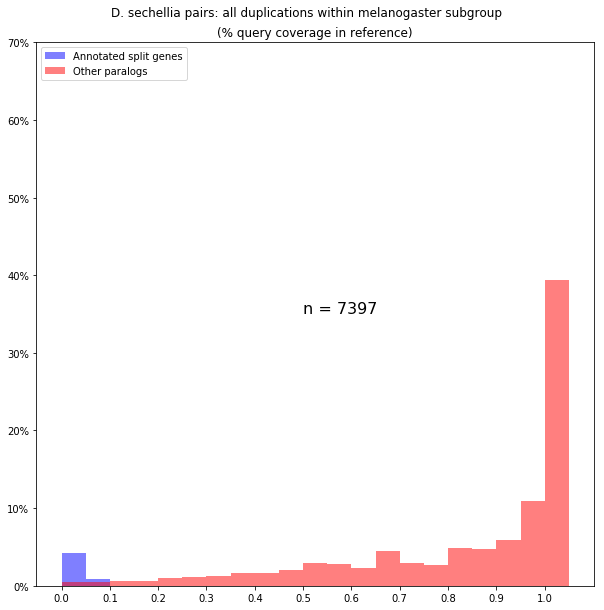

In [146]:

cursor.execute('SELECT coverage_id_para, homology_type FROM Dsec_paralogs')
res = cursor.fetchall()
covListSplit = [x[0] for x in res if x[1] == "gene_split"]
covListNotSplit = [x[0] for x in res if x[1] == 'within_species_paralog']

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
ax.hist([covListNotSplit,covListSplit], bins = np.arange(0,1.1,0.05), histtype='stepfilled',color=[(1,0,0,0.5),(0,0,1,0.5)],label=['Other paralogs','Annotated split genes'])

ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,5200,740))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/(len(covListNotSplit)+len(covListSplit)))))
t = 'n = ' + str(len(covListNotSplit)+len(covListSplit))
ax.text(0.5,2600,t,fontsize=16)
plt.suptitle('D. sechellia pairs: all duplications within melanogaster subgroup', y=0.93)
ax.set_title('(% query coverage in reference)')
ax.legend(loc='upper left')
plt.savefig('coverageAllDsec.png')
plt.show()

In [117]:
# checking how horrendous of an issue yakuba split genes are for the initial filtering
cursor.execute('SELECT prunedTree FROM singleton_trees WHERE excludedReason == "Multiple copies in outgroup-split not possible/subtrees unsuitable"')
trees = [x[0] for x in cursor.fetchall()]
for tree in trees:
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dyak' in node.name:
            geneName = re.search('.*_(FB.*)_',node.name).group(1)
            print(geneName)

FBpp0360079
FBpp0362161
FBpp0361216
FBpp0358020
FBpp0360892
FBpp0264711
FBpp0268254
FBpp0256071
FBpp0269978
FBpp0267576
FBpp0267572
FBpp0359961
FBpp0360956
FBpp0360507
FBpp0362498
FBpp0270241
FBpp0353753
FBpp0267526
FBpp0267930
FBpp0360588
FBpp0267393
FBpp0267459
FBpp0267460
FBpp0353664
FBpp0356315
FBpp0353759
FBpp0267856
FBpp0269926
FBpp0359192
FBpp0363317
FBpp0358906
FBpp0270515
FBpp0362771
FBpp0259984
FBpp0264563
FBpp0363522
FBpp0268091
FBpp0264607
FBpp0264584
FBpp0264588
FBpp0268243
FBpp0264679
FBpp0363237
FBpp0353284
FBpp0267424
FBpp0267762
FBpp0264708
FBpp0268072
FBpp0363627
FBpp0255429
FBpp0268157
FBpp0360598
FBpp0262366
FBpp0257302
FBpp0267267
FBpp0264844
FBpp0362358
FBpp0270461
FBpp0361023
FBpp0360240
FBpp0267623
FBpp0267622
FBpp0362564
FBpp0354334
FBpp0260461
FBpp0267429
FBpp0355800
FBpp0363548
FBpp0360992
FBpp0355161
FBpp0264685
FBpp0364650
FBpp0353507
FBpp0264631
FBpp0268225
FBpp0360325
FBpp0362592
FBpp0267532
FBpp0267792
FBpp0267782
FBpp0267496
FBpp0357079
FBpp0359251
FBpp

In [120]:
# check if sechelia dups are real or not FBgn0171594
#might need to fetch % coverage with API? Hopefully? Or fetch alignments and work out from there?
# cursor.execute('CREATE TABLE IF NOT EXISTS Dyak_paralogs(id TEXT, para_id TEXT, homology_type TEXT, loc TEXT, para_loc TEXT)')
# with open('Dyak_paralogs.txt') as file:
#     file.readline()
#     for line in file:
#         line = line.strip('\n').split('\t')
#         cursor.execute('INSERT INTO Dyak_paralogs VALUES(?,?,?,?,?)',line)
# db.commit()
import requests, json
from tqdm import tqdm
# cursor.execute('ALTER TABLE Dyak_paralogs ADD COLUMN coverage_id_para REAL')
cursor.execute('SELECT id, para_id FROM Dyak_paralogs')

for i, p in tqdm(cursor.fetchall()):
    # need to get the gene ids for each protein id
    url = 'http://rest.ensembl.org/lookup/id/' + i + '?'
    transID = requests.get(url, headers=headers).json()['Parent']
    url = 'http://rest.ensembl.org/lookup/id/' + transID + '?'
    geneID = requests.get(url, headers=headers).json()['Parent']

    #then get homologies, extract alignments and work out coverage (number of gap characters in the other seqs alignment over current seqs length?)
    url = 'http://rest.ensembl.org/homology/id/' + geneID + '?compara=metazoa;species=drosophila_yakuba'
    headers = {'Content-type':'application/json'}
    res = requests.get(url, headers=headers).json()
    homList = res['data'][0]['homologies']
    for h in [x for x in homList if x['target']['species'] == 'drosophila_yakuba']:
        if h['target']['protein_id'] == p:
            seq1 = h['source']['align_seq']
            seq2 = h['target']['align_seq']
            # get source coverage in target
            alignment = zip(seq1,seq2)
            seq1Bases = [x for x in alignment if x[0] != '-']
            lenSeq1 = len(seq1Bases)
            alignedBases = len([x for x in seq1Bases if x[1] != '-'])
            percentCov = alignedBases/lenSeq1

            cursor.execute('UPDATE Dyak_paralogs SET coverage_id_para = ? WHERE id == ? AND para_id == ?',(percentCov,i,p))
db.commit()

100%|██████████| 414/414 [09:22<00:00,  1.37it/s]


In [ ]:
cursor.execute('SELECT coverage_id_para, homology_type FROM Dyak_paralogs')
res = cursor.fetchall()
covListSplit = [x[0] for x in res if x[1] == "gene_split"]
covListNotSplit = [x[0] for x in res if x[1] == 'within_species_paralog']

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
ax.hist([covListNotSplit, covListSplit], bins = np.arange(0,1.1,0.05), histtype='barstacked',color=[(1,0,0,0.5),(0,0,1,0.5)],label=['Other paralogs','"Other" paralogs','Annotated split genes'])
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,300,50))
ax.set_suptitle('D. yakuba paralog pairs: all duplications in melanogaster subgroup')
ax.set_title('% query coverage in reference')
ax.legend(loc='upper left')
plt.show()

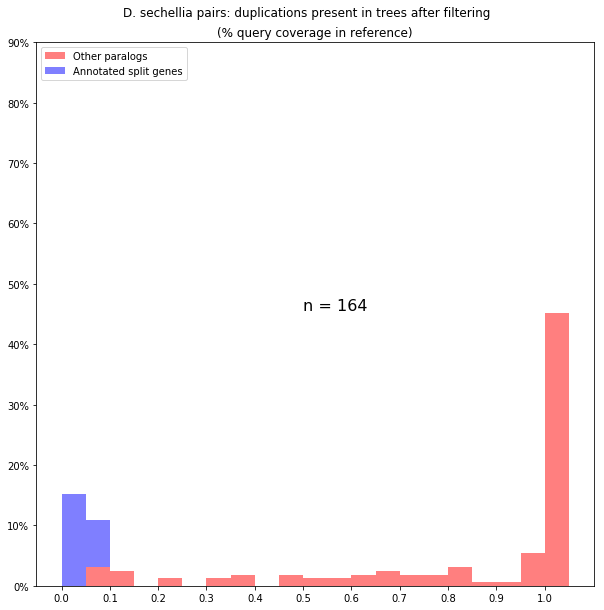

In [160]:
# only pairs in the trees
import re
cursor.execute('SELECT tree FROM processed_trees WHERE dup_status == "D" AND excludedReason IS NULL')
trees = [x[0] for x in cursor.fetchall()]
dyakList = []
plotList = []
for tree in trees:
    dyakList = []
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dsec' in node.name:
            geneName = re.search('.*_(FB.*)_',node.name).group(1)
            dyakList.append(geneName)
    if len(dyakList) > 1: #duplication
        for p in dyakList:
            for p2 in dyakList:
                if p != p2:

                    cursor.execute('SELECT coverage_id_para, homology_type FROM Dsec_paralogs WHERE id == ? AND para_id == ?',(p,p2))
                    plotList.extend(cursor.fetchall())
                    

res = plotList
covListSplit = [x[0] for x in res if x[1] == "gene_split"]
covListNotSplit = [x[0] for x in res if x[1] == 'within_species_paralog']

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
ax.hist([covListNotSplit,covListSplit], bins = np.arange(0,1.1,0.05), histtype='barstacked',color=[(1,0,0,0.5),(0,0,1,0.5)],label=['Other paralogs','Annotated split genes'])
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,150,16.4))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/(len(covListNotSplit)+len(covListSplit)))))
t = 'n = ' + str(len(covListNotSplit)+len(covListSplit))
ax.text(0.5,75,t,fontsize=16)
plt.suptitle('D. sechellia pairs: duplications present in trees after filtering', y=0.93)
ax.set_title('(% query coverage in reference)')
ax.legend(loc='upper left')
plt.savefig('coverageTreePairsDSec.png')
# plt.show()

In [18]:

with open('Dmel_paralogs_tester.txt') as file:
    cursor.execute('CREATE TABLE IF NOT EXISTS Dmel_paralogs(id TEXT, para_id TEXT, homology_type TEXT, loc TEXT, para_loc TEXT, dupAge TEXT)')
    for line in file:
        line = line.strip('\n').split('\t')
        if line[5] == 'melanogaster subgroup' or line[5] == 'Drosophila melanogaster':
            cursor.execute('INSERT INTO Dmel_paralogs VALUES(?,?,?,?,?,?)',line)

In [161]:
cursor.execute('DELETE FROM Dyak_paralogs WHERE dupAge != "Drosophila yakuba strain Tai18E2" AND dupAge != "melanogaster subgroup"')

In [20]:

# melanogaster dups of expected dup age (melanogaster subgroup or younger)
#might need to fetch % coverage with API? Hopefully? Or fetch alignments and work out from there?
# with open('Dmel_paralogs_tester.txt') as file:
#     cursor.execute('CREATE TABLE IF NOT EXISTS Dmel_paralogs(id TEXT, para_id TEXT, homology_type TEXT, loc TEXT, para_loc TEXT, dupAge TEXT)')
#     for line in file:
#         line = line.strip('\n').split('\t')
#         if line[5] == 'melanogaster subgroup' or line[5] == 'Drosophila melanogaster':
#             cursor.execute('INSERT INTO Dmel_paralogs VALUES(?,?,?,?,?,?)',line)
db.commit()
import requests, json
from tqdm import tqdm
headers = {'Content-Type':'application/json'}
# cursor.execute('ALTER TABLE Dmel_paralogs ADD COLUMN coverage_id_para REAL')
cursor.execute('SELECT id, para_id FROM Dmel_paralogs')

for i, p in tqdm(cursor.fetchall()):
    # need to get the gene ids for each protein id
    url = 'http://rest.ensembl.org/lookup/id/' + i + '?'
    transID = requests.get(url, headers=headers).json()['Parent']
    url = 'http://rest.ensembl.org/lookup/id/' + transID + '?'
    geneID = requests.get(url, headers=headers).json()['Parent']

    #then get homologies, extract alignments and work out coverage (number of gap characters in the other seqs alignment over current seqs length?)
    url = 'http://rest.ensembl.org/homology/id/' + geneID + '?compara=metazoa;species=drosophila_melanogaster'
    headers = {'Content-type':'application/json'}
    res = requests.get(url, headers=headers).json()
    homList = res['data'][0]['homologies']
    for h in [x for x in homList if x['target']['species'] == 'drosophila_melanogaster']:
        if h['target']['protein_id'] == p:
            seq1 = h['source']['align_seq']
            seq2 = h['target']['align_seq']
            # get source coverage in target
            alignment = zip(seq1,seq2)
            seq1Bases = [x for x in alignment if x[0] != '-']
            lenSeq1 = len(seq1Bases)
            alignedBases = len([x for x in seq1Bases if x[1] != '-'])
            percentCov = alignedBases/lenSeq1

            cursor.execute('UPDATE Dmel_paralogs SET coverage_id_para = ? WHERE id == ? AND para_id == ?',(percentCov,i,p))
db.commit()

100%|██████████| 3401/3401 [56:44<00:00,  1.17it/s]  


In [60]:
# cursor.execute('SELECT id, para_id FROM Dsim_paralogs')
# incList = cursor.fetchall()
# with open('Dsim_paralogs_all.txt') as file:
#     cursor.execute('CREATE TABLE IF NOT EXISTS Dsim_paralogs(id TEXT, para_id TEXT, homology_type TEXT, loc TEXT, para_loc TEXT, dupAge TEXT)')
#     for line in tqdm(file):
#         line = line.strip('\n').split('\t')
#         if line[0] == '':
#             continue
#         elif (line[0],line[1]) in incList:
#             continue
#         elif line[5] == 'melanogaster subgroup' or line[5] == 'Drosophila simulans':
#             cursor.execute('INSERT INTO Dsim_paralogs VALUES(?,?,?,?,?,?)',line)
# db.commit()
cursor.execute('DELETE FROM Dsim_paralogs WHERE id == ""')
import requests, json
from tqdm import tqdm
headers = {'Content-Type':'application/json'}
# cursor.execute('ALTER TABLE Dsim_paralogs ADD COLUMN coverage_id_para REAL')
cursor.execute('SELECT id, para_id FROM Dsim_paralogs')

for i, p in tqdm(cursor.fetchall(),miniters=50):
    # need to get the gene ids for each protein id
    url = 'http://rest.ensembl.org/lookup/id/' + i + '?'
    transID = requests.get(url, headers=headers).json()['Parent']
    url = 'http://rest.ensembl.org/lookup/id/' + transID + '?'
    geneID = requests.get(url, headers=headers).json()['Parent']

    #then get homologies, extract alignments and work out coverage (number of gap characters in the other seqs alignment over current seqs length?)
    url = 'http://rest.ensembl.org/homology/id/' + geneID + '?compara=metazoa;species=drosophila_simulans'
    headers = {'Content-type':'application/json'}
    res = requests.get(url, headers=headers).json()
    homList = res['data'][0]['homologies']
    for h in [x for x in homList if x['target']['species'] == 'drosophila_simulans']:
        if h['target']['protein_id'] == p:
            seq1 = h['source']['align_seq']
            seq2 = h['target']['align_seq']
            # get source coverage in target
            alignment = zip(seq1,seq2)
            seq1Bases = [x for x in alignment if x[0] != '-']
            lenSeq1 = len(seq1Bases)
            alignedBases = len([x for x in seq1Bases if x[1] != '-'])
            percentCov = alignedBases/lenSeq1

            cursor.execute('UPDATE Dsim_paralogs SET coverage_id_para = ? WHERE id == ? AND para_id == ?',(percentCov,i,p))
db.commit()








  0%|          | 0/2108 [00:00<?, ?it/s]






  0%|          | 0/2108 [00:11<?, ?it/s]






  1%|▏         | 30/2108 [00:11<13:25,  2.58it/s]






  1%|▏         | 31/2108 [00:12<14:46,  2.34it/s]






  2%|▏         | 32/2108 [00:12<18:33,  1.86it/s]






  2%|▏         | 33/2108 [00:13<15:46,  2.19it/s]






  2%|▏         | 34/2108 [00:13<13:52,  2.49it/s]






  2%|▏         | 35/2108 [00:13<13:04,  2.64it/s]






  2%|▏         | 36/2108 [00:14<12:19,  2.80it/s]






  2%|▏         | 37/2108 [00:14<11:41,  2.95it/s]






  2%|▏         | 38/2108 [00:14<11:45,  2.94it/s]






  2%|▏         | 39/2108 [00:15<12:17,  2.81it/s]






  2%|▏         | 40/2108 [00:15<11:50,  2.91it/s]






  2%|▏         | 41/2108 [00:15<12:18,  2.80it/s]






  2%|▏         | 42/2108 [00:16<11:51,  2.90it/s]






  2%|▏         | 43/2108 [00:16<11:04,  3.11it/s]






  2%|▏         | 44/2108 [00:16<11:03,  3.11it/s]






  2%|▏         | 45/2108 [00:17<14:01,  2.45it/s]






  2

 11%|█▏        | 239/2108 [02:20<44:03,  1.41s/it]






 11%|█▏        | 240/2108 [02:22<44:23,  1.43s/it]






 11%|█▏        | 241/2108 [02:22<36:13,  1.16s/it]






 11%|█▏        | 242/2108 [02:23<27:47,  1.12it/s]






 12%|█▏        | 243/2108 [02:23<23:41,  1.31it/s]






 12%|█▏        | 244/2108 [02:23<20:30,  1.51it/s]






 12%|█▏        | 245/2108 [02:25<27:29,  1.13it/s]






 12%|█▏        | 246/2108 [02:25<22:11,  1.40it/s]






 12%|█▏        | 247/2108 [02:25<18:22,  1.69it/s]






 12%|█▏        | 248/2108 [02:26<15:43,  1.97it/s]






 12%|█▏        | 249/2108 [02:26<14:40,  2.11it/s]






 12%|█▏        | 250/2108 [02:27<15:47,  1.96it/s]






 12%|█▏        | 251/2108 [02:27<14:14,  2.17it/s]






 12%|█▏        | 252/2108 [02:28<14:15,  2.17it/s]






 12%|█▏        | 253/2108 [02:29<22:01,  1.40it/s]






 12%|█▏        | 254/2108 [02:31<33:11,  1.07s/it]






 12%|█▏        | 255/2108 [02:31<27:04,  1.14it/s]






 12%|█▏        | 256/2108 [02:3

 16%|█▋        | 344/2108 [03:48<21:51,  1.34it/s]






 16%|█▋        | 345/2108 [03:49<17:50,  1.65it/s]






 16%|█▋        | 346/2108 [03:50<27:52,  1.05it/s]






 16%|█▋        | 347/2108 [03:51<22:19,  1.32it/s]






 17%|█▋        | 348/2108 [03:51<19:23,  1.51it/s]






 17%|█▋        | 349/2108 [03:53<26:32,  1.10it/s]






 17%|█▋        | 350/2108 [03:53<23:34,  1.24it/s]






 17%|█▋        | 351/2108 [03:53<18:38,  1.57it/s]






 17%|█▋        | 352/2108 [03:55<28:02,  1.04it/s]






 17%|█▋        | 353/2108 [03:55<22:49,  1.28it/s]






 17%|█▋        | 354/2108 [03:56<19:15,  1.52it/s]






 17%|█▋        | 355/2108 [03:56<16:33,  1.76it/s]






 17%|█▋        | 356/2108 [03:57<19:36,  1.49it/s]






 17%|█▋        | 357/2108 [03:58<25:08,  1.16it/s]






 17%|█▋        | 358/2108 [03:59<20:37,  1.41it/s]






 17%|█▋        | 359/2108 [03:59<18:25,  1.58it/s]






 17%|█▋        | 360/2108 [04:00<15:53,  1.83it/s]






 17%|█▋        | 361/2108 [04:0

 26%|██▋       | 554/2108 [05:50<23:29,  1.10it/s]






 26%|██▋       | 555/2108 [05:51<24:35,  1.05it/s]






 26%|██▋       | 556/2108 [05:51<22:01,  1.17it/s]






 26%|██▋       | 557/2108 [05:52<18:47,  1.38it/s]






 26%|██▋       | 558/2108 [05:52<15:11,  1.70it/s]






 27%|██▋       | 559/2108 [05:53<15:03,  1.72it/s]






 27%|██▋       | 560/2108 [05:53<12:16,  2.10it/s]






 27%|██▋       | 561/2108 [05:53<12:23,  2.08it/s]






 27%|██▋       | 562/2108 [05:54<12:08,  2.12it/s]






 27%|██▋       | 563/2108 [05:54<10:04,  2.56it/s]






 27%|██▋       | 564/2108 [05:54<09:54,  2.60it/s]






 27%|██▋       | 565/2108 [05:55<08:40,  2.97it/s]






 27%|██▋       | 566/2108 [05:56<18:26,  1.39it/s]






 27%|██▋       | 567/2108 [05:57<17:40,  1.45it/s]






 27%|██▋       | 568/2108 [05:57<16:00,  1.60it/s]






 27%|██▋       | 569/2108 [05:58<15:32,  1.65it/s]






 27%|██▋       | 570/2108 [05:58<14:35,  1.76it/s]






 27%|██▋       | 571/2108 [05:5

 36%|███▌      | 764/2108 [08:28<25:19,  1.13s/it]






 36%|███▋      | 765/2108 [08:29<20:17,  1.10it/s]






 36%|███▋      | 766/2108 [08:30<19:14,  1.16it/s]






 36%|███▋      | 767/2108 [08:30<15:35,  1.43it/s]






 36%|███▋      | 768/2108 [08:30<13:05,  1.71it/s]






 36%|███▋      | 769/2108 [08:30<10:47,  2.07it/s]






 37%|███▋      | 770/2108 [08:31<09:53,  2.26it/s]






 37%|███▋      | 771/2108 [08:31<10:58,  2.03it/s]






 37%|███▋      | 772/2108 [08:32<13:28,  1.65it/s]






 37%|███▋      | 773/2108 [08:33<11:56,  1.86it/s]






 37%|███▋      | 774/2108 [08:33<10:21,  2.15it/s]






 37%|███▋      | 775/2108 [08:33<08:54,  2.49it/s]






 37%|███▋      | 776/2108 [08:34<12:43,  1.74it/s]






 37%|███▋      | 777/2108 [08:35<14:45,  1.50it/s]






 37%|███▋      | 778/2108 [08:35<13:06,  1.69it/s]






 37%|███▋      | 779/2108 [08:36<11:15,  1.97it/s]






 37%|███▋      | 780/2108 [08:36<09:29,  2.33it/s]






 37%|███▋      | 781/2108 [08:3

 46%|████▌     | 974/2108 [10:59<14:38,  1.29it/s]






 46%|████▋     | 975/2108 [11:00<15:45,  1.20it/s]






 46%|████▋     | 976/2108 [11:01<13:21,  1.41it/s]






 46%|████▋     | 977/2108 [11:01<11:33,  1.63it/s]






 46%|████▋     | 978/2108 [11:02<11:58,  1.57it/s]






 46%|████▋     | 979/2108 [11:02<10:48,  1.74it/s]






 46%|████▋     | 980/2108 [11:03<09:53,  1.90it/s]






 47%|████▋     | 981/2108 [11:04<13:05,  1.43it/s]






 47%|████▋     | 982/2108 [11:04<11:46,  1.59it/s]






 47%|████▋     | 983/2108 [11:05<10:29,  1.79it/s]






 47%|████▋     | 984/2108 [11:06<12:17,  1.52it/s]






 47%|████▋     | 985/2108 [11:06<11:24,  1.64it/s]






 47%|████▋     | 986/2108 [11:08<17:46,  1.05it/s]






 47%|████▋     | 987/2108 [11:08<15:02,  1.24it/s]






 47%|████▋     | 988/2108 [11:09<12:56,  1.44it/s]






 47%|████▋     | 989/2108 [11:09<11:27,  1.63it/s]






 47%|████▋     | 990/2108 [11:11<17:27,  1.07it/s]






 47%|████▋     | 991/2108 [11:1

 56%|█████▌    | 1181/2108 [13:22<10:12,  1.51it/s]






 56%|█████▌    | 1182/2108 [13:22<08:40,  1.78it/s]






 56%|█████▌    | 1183/2108 [13:22<08:24,  1.83it/s]






 56%|█████▌    | 1184/2108 [13:25<16:39,  1.08s/it]






 56%|█████▌    | 1185/2108 [13:25<13:39,  1.13it/s]






 56%|█████▋    | 1186/2108 [13:25<10:36,  1.45it/s]






 56%|█████▋    | 1187/2108 [13:26<09:01,  1.70it/s]






 56%|█████▋    | 1188/2108 [13:26<07:21,  2.08it/s]






 56%|█████▋    | 1189/2108 [13:26<06:20,  2.42it/s]






 56%|█████▋    | 1190/2108 [13:27<08:07,  1.88it/s]






 56%|█████▋    | 1191/2108 [13:28<07:52,  1.94it/s]






 57%|█████▋    | 1192/2108 [13:28<09:19,  1.64it/s]






 57%|█████▋    | 1193/2108 [13:29<11:25,  1.33it/s]






 57%|█████▋    | 1194/2108 [13:30<09:29,  1.60it/s]






 57%|█████▋    | 1195/2108 [13:30<09:24,  1.62it/s]






 57%|█████▋    | 1196/2108 [13:31<08:17,  1.83it/s]






 57%|█████▋    | 1197/2108 [13:31<07:41,  1.97it/s]






 57%|█████▋   

 66%|██████▌   | 1387/2108 [16:30<04:23,  2.73it/s]






 66%|██████▌   | 1388/2108 [16:31<06:46,  1.77it/s]






 66%|██████▌   | 1389/2108 [16:32<07:52,  1.52it/s]






 66%|██████▌   | 1390/2108 [16:32<08:21,  1.43it/s]






 66%|██████▌   | 1391/2108 [16:33<06:44,  1.77it/s]






 66%|██████▌   | 1392/2108 [16:33<07:25,  1.61it/s]






 66%|██████▌   | 1393/2108 [16:34<06:23,  1.86it/s]






 66%|██████▌   | 1394/2108 [16:35<09:20,  1.27it/s]






 66%|██████▌   | 1395/2108 [16:36<08:21,  1.42it/s]






 66%|██████▌   | 1396/2108 [16:36<07:18,  1.62it/s]






 66%|██████▋   | 1397/2108 [16:36<06:01,  1.97it/s]






 66%|██████▋   | 1398/2108 [16:37<05:04,  2.33it/s]






 66%|██████▋   | 1399/2108 [16:37<04:28,  2.64it/s]






 66%|██████▋   | 1400/2108 [16:37<04:10,  2.83it/s]






 66%|██████▋   | 1401/2108 [16:37<04:00,  2.94it/s]






 67%|██████▋   | 1402/2108 [16:38<03:39,  3.22it/s]






 67%|██████▋   | 1403/2108 [16:38<03:36,  3.26it/s]






 67%|██████▋  

 76%|███████▌  | 1593/2108 [18:46<03:43,  2.31it/s]






 76%|███████▌  | 1594/2108 [18:47<06:28,  1.32it/s]






 76%|███████▌  | 1595/2108 [18:48<06:17,  1.36it/s]






 76%|███████▌  | 1596/2108 [18:48<05:29,  1.55it/s]






 76%|███████▌  | 1597/2108 [18:49<04:59,  1.71it/s]






 76%|███████▌  | 1598/2108 [18:49<04:54,  1.73it/s]






 76%|███████▌  | 1599/2108 [18:50<04:29,  1.89it/s]






 76%|███████▌  | 1600/2108 [18:50<04:13,  2.00it/s]






 76%|███████▌  | 1601/2108 [18:51<04:00,  2.11it/s]






 76%|███████▌  | 1602/2108 [18:51<04:09,  2.03it/s]






 76%|███████▌  | 1603/2108 [18:52<04:07,  2.04it/s]






 76%|███████▌  | 1604/2108 [18:52<04:27,  1.88it/s]






 76%|███████▌  | 1605/2108 [18:53<04:46,  1.76it/s]






 76%|███████▌  | 1606/2108 [18:53<04:18,  1.94it/s]






 76%|███████▌  | 1607/2108 [18:54<03:35,  2.33it/s]






 76%|███████▋  | 1608/2108 [18:54<03:02,  2.74it/s]






 76%|███████▋  | 1609/2108 [18:54<03:49,  2.17it/s]






 76%|███████▋ 

 85%|████████▌ | 1799/2108 [21:41<01:58,  2.61it/s]






 85%|████████▌ | 1800/2108 [21:41<01:49,  2.81it/s]






 85%|████████▌ | 1801/2108 [21:41<01:44,  2.95it/s]






 85%|████████▌ | 1802/2108 [21:42<01:54,  2.68it/s]






 86%|████████▌ | 1803/2108 [21:42<01:50,  2.75it/s]






 86%|████████▌ | 1804/2108 [21:42<01:43,  2.95it/s]






 86%|████████▌ | 1805/2108 [21:43<02:33,  1.97it/s]






 86%|████████▌ | 1806/2108 [21:44<03:13,  1.56it/s]






 86%|████████▌ | 1807/2108 [21:45<03:10,  1.58it/s]






 86%|████████▌ | 1808/2108 [21:47<04:45,  1.05it/s]






 86%|████████▌ | 1809/2108 [21:47<04:00,  1.24it/s]






 86%|████████▌ | 1810/2108 [21:48<03:51,  1.29it/s]






 86%|████████▌ | 1811/2108 [21:48<03:22,  1.47it/s]






 86%|████████▌ | 1812/2108 [21:49<03:03,  1.61it/s]






 86%|████████▌ | 1813/2108 [21:50<03:53,  1.27it/s]






 86%|████████▌ | 1814/2108 [21:50<03:12,  1.53it/s]






 86%|████████▌ | 1815/2108 [21:51<02:39,  1.84it/s]






 86%|████████▌

 95%|█████████▌| 2005/2108 [24:03<01:05,  1.57it/s]






 95%|█████████▌| 2006/2108 [24:03<01:03,  1.61it/s]






 95%|█████████▌| 2007/2108 [24:04<01:06,  1.53it/s]






 95%|█████████▌| 2008/2108 [24:05<01:03,  1.57it/s]






 95%|█████████▌| 2009/2108 [24:05<00:56,  1.75it/s]






 95%|█████████▌| 2010/2108 [24:06<01:06,  1.47it/s]






 95%|█████████▌| 2011/2108 [24:06<00:55,  1.75it/s]






 95%|█████████▌| 2012/2108 [24:07<00:46,  2.06it/s]






 95%|█████████▌| 2013/2108 [24:07<00:41,  2.27it/s]






 96%|█████████▌| 2014/2108 [24:07<00:37,  2.51it/s]






 96%|█████████▌| 2015/2108 [24:08<00:35,  2.63it/s]






 96%|█████████▌| 2016/2108 [24:08<00:35,  2.62it/s]






 96%|█████████▌| 2017/2108 [24:08<00:30,  3.02it/s]






 96%|█████████▌| 2018/2108 [24:14<02:55,  1.95s/it]






 96%|█████████▌| 2019/2108 [24:15<02:22,  1.60s/it]






 96%|█████████▌| 2020/2108 [24:15<01:50,  1.25s/it]






 96%|█████████▌| 2021/2108 [24:16<01:27,  1.01s/it]






 96%|█████████

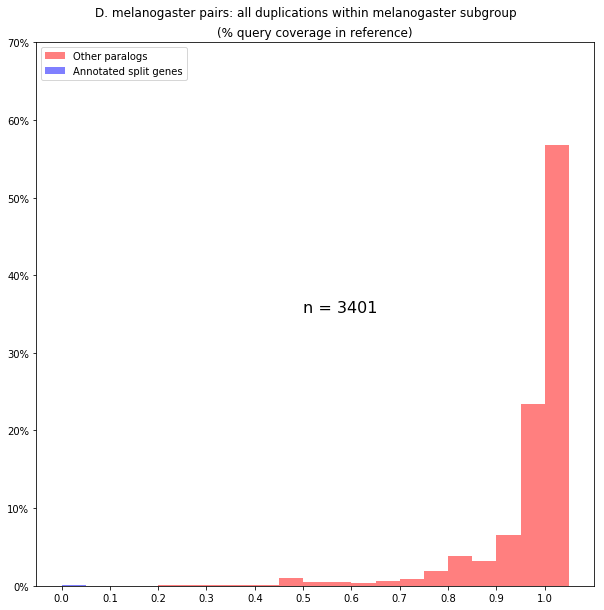

In [143]:
cursor.execute('SELECT coverage_id_para, homology_type FROM Dmel_paralogs')
res = cursor.fetchall()
covListSplit = [x[0] for x in res if x[1] == "gene_split"]
covListNotSplit = [x[0] for x in res if x[1] == 'within_species_paralog']

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
ax.hist([covListNotSplit,covListSplit], bins = np.arange(0,1.1,0.05), histtype='barstacked',color=[(1,0,0,0.5),(0,0,1,0.5)],label=['Other paralogs','Annotated split genes'])
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,2500,340))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/(len(covListNotSplit)+len(covListSplit)))))
t = 'n = ' + str(len(covListNotSplit)+len(covListSplit))
ax.text(0.5,1200,t,fontsize=16)
plt.suptitle('D. melanogaster pairs: all duplications within melanogaster subgroup', y=0.93)
ax.set_title('(% query coverage in reference)')
ax.legend(loc='upper left')
plt.savefig('coverageAllDMel.png')
plt.show()

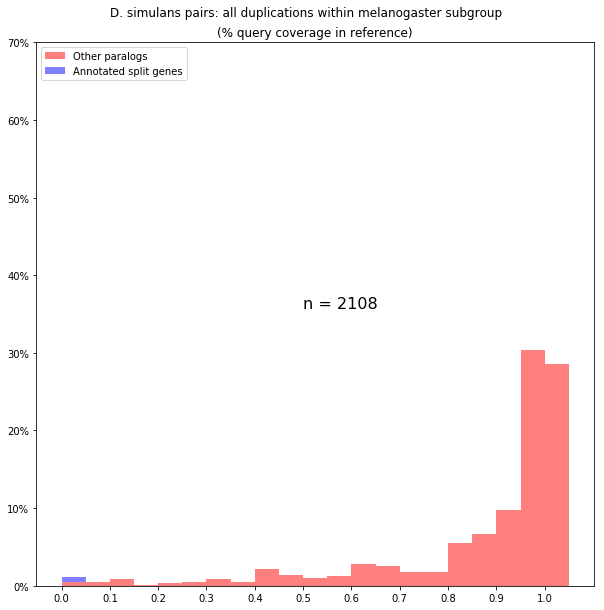

In [142]:
cursor.execute('SELECT coverage_id_para, homology_type FROM Dsim_paralogs')
res = cursor.fetchall()
covListSplit = [x[0] for x in res if x[1] == "gene_split"]
covListNotSplit = [x[0] for x in res if x[1] == 'within_species_paralog']

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
ax.hist([covListNotSplit,covListSplit], bins = np.arange(0,1.1,0.05), histtype='barstacked',color=[(1,0,0,0.5),(0,0,1,0.5)],label=['Other paralogs','Annotated split genes'])
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1600,210))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/(len(covListNotSplit)+len(covListSplit)))))
t = 'n = ' + str(len(covListNotSplit)+len(covListSplit))
ax.text(0.5,750,t,fontsize=16)
plt.suptitle('D. simulans pairs: all duplications within melanogaster subgroup', y=0.93)
ax.set_title('(% query coverage in reference)')
ax.legend(loc='upper left')
plt.savefig('coverageAllDsim.png')
plt.show()

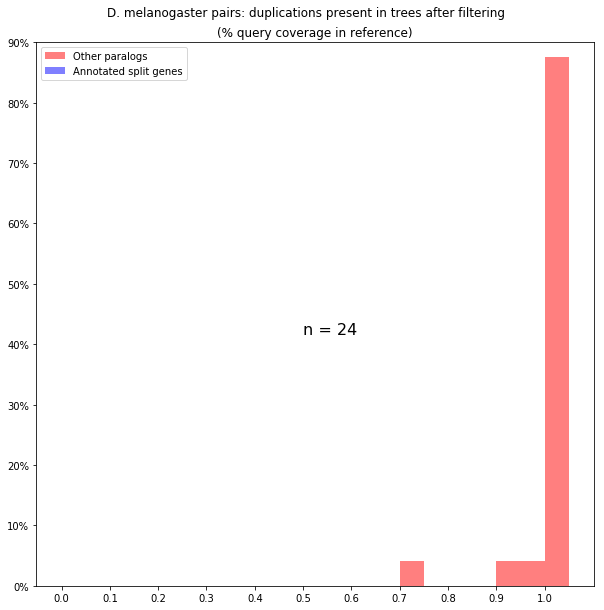

In [152]:
# only pairs in the trees
import re
cursor.execute('SELECT tree FROM processed_trees WHERE dup_status == "D" AND excludedReason IS NULL')
trees = [x[0] for x in cursor.fetchall()]
dmelList = []
plotList = []
for tree in trees:
    dmelList = []
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dmel' in node.name:
            geneName = re.search('.*_(FB.*)_',node.name).group(1)
            dmelList.append(geneName)
    if len(dmelList) > 1: #duplication
        for p in dmelList:
            for p2 in dmelList:
                if p != p2:

                    cursor.execute('SELECT coverage_id_para, homology_type FROM Dmel_paralogs WHERE id == ? AND para_id == ?',(p,p2))
                    plotList.extend(cursor.fetchall())

res = plotList
covListSplit = [x[0] for x in res if x[1] == "gene_split"]
covListNotSplit = [x[0] for x in res if x[1] == 'within_species_paralog']

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
ax.hist([covListNotSplit,covListSplit], bins = np.arange(0,1.1,0.05), histtype='barstacked',color=[(1,0,0,0.5),(0,0,1,0.5)],label=['Other paralogs','Annotated split genes'])
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,24,2.4))
t = 'n = ' + str(len(covListNotSplit)+len(covListSplit))
ax.text(0.5,10,t,fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/(len(covListNotSplit)+len(covListSplit)))))


plt.suptitle('D. melanogaster pairs: duplications present in trees after filtering', y=0.93)
ax.set_title('(% query coverage in reference)')
ax.legend(loc='upper left')
plt.savefig('coverageTreePairsDmel.png')
plt.show()

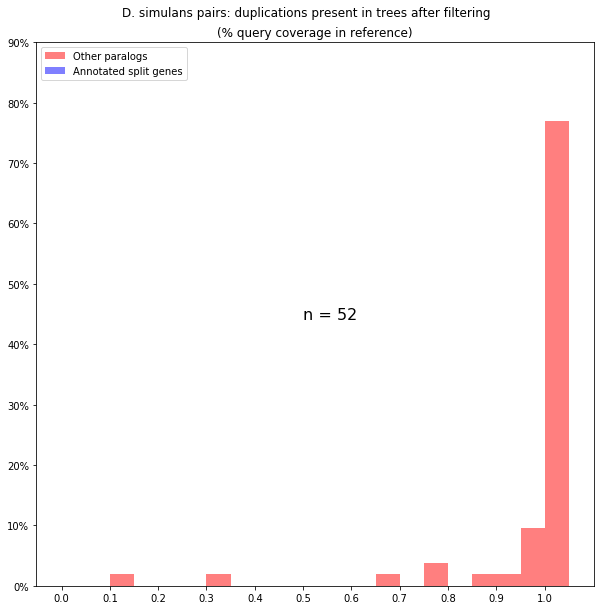

In [150]:
# only pairs in the trees
import re
cursor.execute('SELECT tree FROM processed_trees WHERE dup_status == "D" AND excludedReason IS NULL')
trees = [x[0] for x in cursor.fetchall()]
dsimList = []
plotList = []
for tree in trees:
    dsimList = []
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dsim' in node.name:
            geneName = re.search('.*_(FB.*)_',node.name).group(1)
            dsimList.append(geneName)
    if len(dsimList) > 1: #duplication
        for p in dsimList:
            for p2 in dsimList:
                if p != p2:

                    cursor.execute('SELECT coverage_id_para, homology_type FROM Dsim_paralogs WHERE id == ? AND para_id == ?',(p,p2))
                    plotList.extend(cursor.fetchall())

res = plotList
covListSplit = [x[0] for x in res if x[1] == "gene_split"]
covListNotSplit = [x[0] for x in res if x[1] == 'within_species_paralog']

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
ax.hist([covListNotSplit, covListSplit], bins = np.arange(0,1.1,0.05), histtype='barstacked',color=[(1,0,0,0.5),(0,0,1,0.5)],label=['Other paralogs','Annotated split genes'])
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,50,5.2))
t = 'n = ' + str(len(covListNotSplit)+len(covListSplit))
ax.text(0.5,23,t,fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/(len(covListNotSplit)+len(covListSplit)))))


plt.suptitle('D. simulans pairs: duplications present in trees after filtering', y=0.93)
ax.set_title('(% query coverage in reference)')
ax.legend(loc='upper left')
plt.savefig('coverageTreePairsDsim.png')
plt.show()

In [39]:
covListSplit

[]

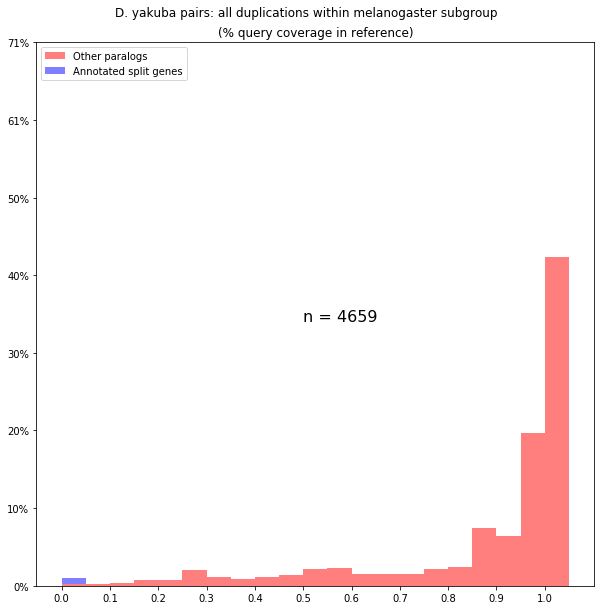

In [163]:
cursor.execute('SELECT coverage_id_para, homology_type FROM Dyak_paralogs')
res = cursor.fetchall()
covListSplit = [x[0] for x in res if x[1] == "gene_split"]
covListNotSplit = [x[0] for x in res if x[1] == 'within_species_paralog']
covListOther = [x[0] for x in res if x[1] == 'other_paralog']
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
ax.hist([covListNotSplit, covListSplit], bins = np.arange(0,1.1,0.05), histtype='barstacked',color=[(1,0,0,0.5),(0,0,1,0.5)],label=['Other paralogs','Annotated split genes'])
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,3500,470))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/(len(covListNotSplit)+len(covListSplit)))))
t = 'n = ' + str(len(covListNotSplit)+len(covListSplit))
ax.text(0.5,1600,t,fontsize=16)
plt.suptitle('D. yakuba pairs: all duplications within melanogaster subgroup', y=0.93)
ax.set_title('(% query coverage in reference)')

# plt.show()
ax.legend(loc='upper left')
plt.savefig('coverageAllDyak.png')
plt.show()

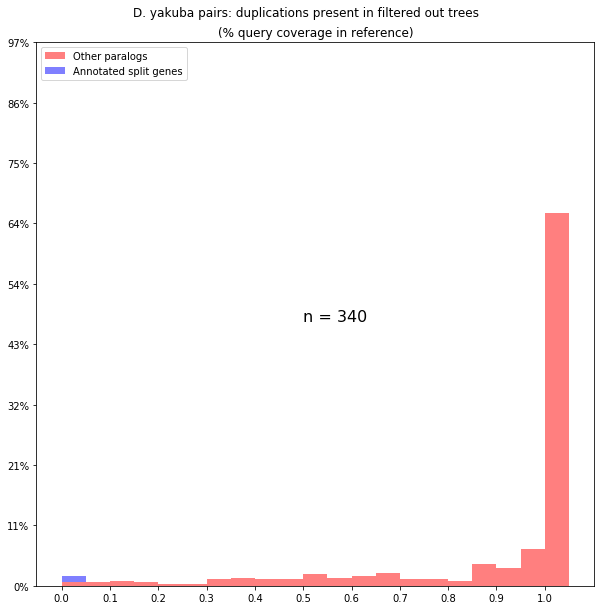

In [162]:
# only tree pairs
import re
from matplotlib.ticker import FuncFormatter
cursor.execute('SELECT prunedTree FROM singleton_trees WHERE excludedReason == "Multiple copies in outgroup-split not possible/subtrees unsuitable"')
trees = [x[0] for x in cursor.fetchall()]
dyakList = []
plotList = []
for tree in trees:
    dyakList = []
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dyak' in node.name:
            geneName = re.search('.*_(FB.*)_',node.name).group(1)
            dyakList.append(geneName)
    if len(dyakList) > 1: #duplication
        for p in dyakList:
            for p2 in dyakList:
                if p != p2:

                    cursor.execute('SELECT coverage_id_para, homology_type FROM Dyak_paralogs WHERE id == ? AND para_id == ?',(p,p2))
                    plotList.extend(cursor.fetchall())
                    

res = plotList
covListSplit = [x[0] for x in res if x[1] == "gene_split"]
covListNotSplit = [x[0] for x in res if x[1] == 'within_species_paralog']
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
ax.hist([covListNotSplit,covListSplit], bins = np.arange(0,1.1,0.05), histtype='barstacked',color=[(1,0,0,0.5),(0,0,1,0.5)],label=['Other paralogs','Annotated split genes'])
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,350,36.5))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/(len(covListNotSplit)+len(covListSplit)))))
t = 'n = ' + str(len(covListNotSplit)+len(covListSplit))
ax.text(0.5,160,t,fontsize=16)
plt.suptitle('D. yakuba pairs: duplications present in filtered out trees', y=0.93)
ax.set_title('(% query coverage in reference)')
ax.legend(loc='upper left')
plt.savefig('coverageTreePairsDyak.png')
# plt.show()

In [62]:
plotList

[(0.7149122807017544, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (0.6555555555555556, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (0.6555555555555556, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (0.9495192307692307, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (0.875, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (0.8014184397163121, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (0.3869565217391304, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (1.0, 'within_species_paralog'),
 (0.002748763056624519, 

In [164]:
cursor.execute('ALTER TABLE processed_trees ADD COLUMN notes TEXT')
cursor.execute('SELECT id, tree FROM processed_trees WHERE (excludedReason IS NULL) AND dup_status == "D"')
melC, simC, secC = 0,0,0
for x in cursor.fetchall():
    mel, sim, sec = 0,0,0
    i, tree = x
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dmel' in node.name:
            mel += 1
        if 'Dsec' in node.name:
            sec += 1
        if 'Dsim' in node.name:
            sim += 1
    if sec > 1 and sim <= 1 and mel <= 1: #dup is only in sechelia
        cursor.execute('UPDATE processed_trees SET notes = "Duplication only in sechellia" WHERE id == ?',(i,))
    if sec > 1:
        secC += 1
    if mel > 1:
        melC += 1
    if sim > 1:
        simC += 1
print('Melanogaster dup trees: ',melC)
print('Simulans dup trees: ',simC)
print('Sechelia dup trees: ',secC)
db.commit()

Melanogaster dup trees:  10
Simulans dup trees:  12
Sechelia dup trees:  58


In [166]:
def retrieve_gene_id(node):
    import re
    geneName = re.search('.*_(FB.*)_',node.name).group(1)
    return geneName
def retrieve_species(node):
    import re
    sp = node.name[-4:]
    return sp

In [167]:
cursor.execute('ALTER TABLE processed_trees ADD COLUMN confirm_rate REAL')
cursor.execute('ALTER TABLE processed_trees ADD COLUMN proxy_rate REAL')

cursor.execute('ALTER TABLE processed_trees ADD COLUMN dS REAL')
cursor.execute('ALTER TABLE processed_trees ADD COLUMN dS2 REAL')

cursor.execute('ALTER TABLE processed_trees ADD COLUMN dN REAL')
cursor.execute('ALTER TABLE processed_trees ADD COLUMN dN2 REAL')

In [173]:
# cursor.execute('ALTER TABLE processed_trees ADD COLUMN dup_in_sp TEXT')
cursor.execute('UPDATE processed_trees SET excludedReason = ? WHERE excludedReason == "Missing sequence for alignment"',(None,))
from subprocess import Popen, PIPE
from Bio.Align.Applications._Muscle import MuscleCommandline
from Bio.Phylo.PAML import codeml
from tqdm import tqdm
from ete3 import PhyloTree
import requests, json
import numpy as np

# select trees from processed_trees table
cursor.execute('SELECT id,tree FROM processed_trees WHERE excludedReason IS NULL')
trees = cursor.fetchall()

headers = {'Content-type':'application/json'}
for base_id, tree in tqdm(trees, miniters=50, mininterval=60):
    c = False
    cdsDict = {}
    musInput = ''
    alignList = []
    DyakCount = 0
    
    tree2 = PhyloTree(tree)
#     get the number of D. yak paralogs
    for node in tree2.traverse():
        if 'Dmel' in node.name:
            DyakCount += 1
#     if DyakCount > 1:
#         cursor.execute('UPDATE processed_trees SET dup_in_sp = "True" WHERE id == ?',(base_id,))
    if DyakCount == 0:
        cursor.execute('UPDATE processed_trees SET excludedReason = "Missing Dmel" WHERE id == ?',(base_id,))
        continue
    # fetch cds nt sequence and prot sequence from ensembl api for all spp (Bio)
    for node in tree2.traverse():
        if node.name == '':
            continue
        ID = retrieve_gene_id(node)
        sp = retrieve_species(node)
        url = 'http://rest.ensembl.org/lookup/id/' + ID
        r1 = requests.get(url, headers=headers)
        try:
            transID = r1.json()['Parent']
        except KeyError:
            c = True
            continue
        url = 'http://rest.ensembl.org/sequence/id/'+ transID + '?type=cds;multiple_sequences=1'
        r = requests.get(url, headers=headers)
       
        if len(r.json()) == 0:
            c = True
            continue
        if type(r.json()) == dict:
            if ID != '':
                print('error: ' + ID ) 
            c = True
            continue
        if len(r.json()) == 1:
            sequenceCDS = r.json()[0]['seq']  
            url = 'http://rest.ensembl.org/sequence/id/'+ transID + '?type=protein;multiple_sequences=1'
            r2 = requests.get(url, headers=headers)
            sequenceProt = r2.json()[0]['seq']
        cdsDict['>'+ID + ':' + sp] = sequenceCDS
        
        musInput = musInput + '>' + ID + ':' + sp + '\n' + sequenceProt + '\n'
    if c is True:#if any requests failed, skip tree
        cursor.execute('UPDATE processed_trees SET excludedReason = "Missing sequence for alignment" WHERE id == ?',(base_id,))
        continue
    # protein alignment with muscle (Bio)
    cline = MuscleCommandline(cmd='muscle3.8.31_i86darwin64')
    with open('interProtAlign.fa','w') as prot_file, open('interCDS.fa','w') as cds_file:
        p = Popen(str(cline),stdin=PIPE, stdout=PIPE, stderr=PIPE)
        out, err = p.communicate(bytes(musInput, 'utf-8'))
        prot_file.write(out.decode())
#         muscle outputs alignments in a different order to input sequences
#         cds sequences have to be written in same order to work with pal2nal
        order = [line for line in (out.decode().split('\n')) if line.startswith('>')]
        for x in order:
            cds_file.write(x + '\n')
            cds_file.write(cdsDict[x] + '\n')

    # somehow convert to codon alignments - pal2nal
    #     usage: pal2nal prot_alignment dna_seq -output paml
    cm = 'pal2nal.pl interProtAlign.fa interCDS.fa -output paml'
    p2 = Popen(cm.split(' '), stdout=PIPE, stderr=PIPE)
    out2, err2 = p2.communicate()
    with open('interCodonAlign.paml','w') as cod_file, open('example.tree','w') as treeFile:
        cod_file.write(out2.decode())
        treeFile.write(tree)

#     extract specific sequences for pairwise dn/ds calc
#     need to take the first line for paml format to work, also need to change the first number to 2 (no of seqs)
    with open('interCodonAlign.paml','r') as inFile:
        for line in inFile:
            alignList.append(line)
            
    with open('paml_input1.paml','w') as outFile1, open('paml_input2.paml','w') as outFile2:
        dyakFound = False
        for i,line in enumerate(alignList):
            if i == 0:
                testLine = line.split(' ')
                intCount = 0
                for ob in testLine:
                    if ob == '':
                        pass
                    else:
                        intCount += 1
                        if intCount == 2:
                            seqLen = ob
                outLine = '  ' + '2' + '   ' + seqLen + '\n'
                # number of sequences in the dyak file might be greater than 2 due to dups, = dyak paralogs +1
                outLine2 = '  ' + str(DyakCount + 1) + '   ' + seqLen + '\n'
                outFile1.write(outLine2)
                outFile2.write(outLine)
            else:
                if 'Dere' in line:
                    outFile1.write(line)
                    for line2 in alignList[i+1:]:
                        if not line2.startswith('F'):
                            outFile1.write(line2)
                        else:
                            break
                    outFile2.write(line)
                    for line2 in alignList[i+1:]:
                        if not line2.startswith('F'):
                            outFile2.write(line2)
                        else:
                            break
                elif 'Dmel' in line:
                    dmelFound = True
                    outFile1.write(line)
                    for line2 in alignList[i+1:]:
                        if not line2.startswith('F'):
                            outFile1.write(line2)
                        else:
                            break
                elif 'Dyak' in line:
                    outFile2.write(line)
                    for line2 in alignList[i+1:]:
                        if not line2.startswith('F'):
                            outFile2.write(line2)
                        else:
                            break
    if not dmelFound:
        cursor.execute('UPDATE processed_trees SET excludedReason = "missing Dmel ortholog" WHERE id == ?',(base_id,))
        continue
    # run PAML on alignment1 - this needs worked on, need to get the mean rate across Dmel duplicates
    cmd = codeml.Codeml(alignment='paml_input1.paml', tree='example.tree', out_file='results.out',working_dir='.')
    cmd.read_ctl_file('codeml.ctl')
    cmd.alignment='paml_input1.paml'
    try:
        output = cmd.run(command='paml4.8/bin/codeml')
    except:
        continue
    
    # extract dn/ds value for each pair
    id1 = [x for x in output['pairwise'].keys() if 'Dere' in x][0]
    id2List = [x for x in output['pairwise'].keys()]
    dndsList = []
    dsList, dnList = [],[]
    
    resDict = output['pairwise'][id1]
    for id2 in [x for x in id2List if x != id1]:
        ds = resDict[id2]['dS']
        dn = resDict[id2]['dN']
        dnds = resDict[id2]['omega']
        
        dndsList.append(dnds)
        dsList.append(ds)
        dnList.append(dn)
        
  
        dnds2 = np.mean(dndsList)
        dn2 = np.mean(dnList)
        ds2 = np.mean(dsList)
        cursor.execute('UPDATE processed_trees SET confirm_rate = ? WHERE id == ?',(dnds2,base_id))
        cursor.execute('UPDATE processed_trees SET dS = ? WHERE id == ?',(ds2,base_id))
        cursor.execute('UPDATE processed_trees SET dN = ? WHERE id == ?',(dn2,base_id))
    # run PAML on alignment2
    cmd = codeml.Codeml(alignment='paml_input2.paml', tree='example.tree', out_file='results.out',working_dir='.')
    cmd.read_ctl_file('codeml.ctl')
    cmd.alignment='paml_input2.paml'
    try:
        output = cmd.run(command='paml4.8/bin/codeml')
    except:
        continue
    
    # extract dn/ds value for each pair
    id1 = [x for x in output['pairwise'].keys()][0]
    id2 = [x for x in output['pairwise'].keys()][1]
    
    resDict = output['pairwise'][id1]
    ds3 = resDict[id2]['dS']
    dn3 = resDict[id2]['dN']
    dnds3 = resDict[id2]['omega']
    
    cursor.execute('UPDATE processed_trees SET proxy_rate = ? WHERE id == ?',(dnds3,base_id))
    cursor.execute('UPDATE processed_trees SET dS2 = ? WHERE id == ?',(ds3,base_id))
    cursor.execute('UPDATE processed_trees SET dN2 = ? WHERE id == ?',(dn3,base_id))
    
db.commit()









  0%|          | 0/2320 [00:00<?, ?it/s]







  0%|          | 0/2320 [00:11<?, ?it/s]







  1%|          | 12/2320 [01:05<3:29:50,  5.46s/it]







  1%|          | 23/2320 [02:06<3:29:57,  5.48s/it]







  1%|▏         | 34/2320 [03:06<3:28:44,  5.48s/it]







  2%|▏         | 47/2320 [04:10<3:21:10,  5.31s/it]







  3%|▎         | 59/2320 [05:14<3:20:26,  5.32s/it]







  3%|▎         | 69/2320 [06:21<3:34:39,  5.72s/it]







  3%|▎         | 80/2320 [07:26<3:35:57,  5.78s/it]







  4%|▍         | 89/2320 [08:27<3:46:29,  6.09s/it]







  4%|▍         | 101/2320 [09:30<3:35:56,  5.84s/it]







  5%|▍         | 111/2320 [10:42<3:49:36,  6.24s/it]







  5%|▌         | 123/2320 [11:45<3:37:52,  5.95s/it]







  6%|▌         | 135/2320 [12:46<3:26:42,  5.68s/it]







  6%|▋         | 148/2320 [13:50<3:17:08,  5.45s/it]







  7%|▋         | 160/2320 [14:50<3:11:38,  5.32s/it]







  7%|▋         | 172/2320 [15:54<3:10:45,  5.33s/it]







  8%

In [145]:
cursor.execute('SELECT tree FROM processed_trees WHERE (excludedReason IS NULL OR excludedReason == "Issues with dN/dS") AND dup_status == "D"')
output = [x[0] for x in cursor.fetchall()]
count, dupCount = 0,1
spList = ['Dere','Dsim','Dsec','Dmel','Dana','Dyak','Dper','Dpse']
for sp in spList:
    count, dupCount = 0,0
    for tree in output:
        count += 1
        dcount = 0
        t = PhyloTree(tree)
        for node in t.traverse():
            if sp in node.name:
                dcount += 1
        if dcount > 1:
            dupCount += 1
    print(sp, dupCount, count)


Dere 10 328
Dsim 16 328
Dsec 77 328
Dmel 11 328
Dana 19 328
Dyak 102 328
Dper 88 328
Dpse 63 328


In [174]:
from scipy.stats import mannwhitneyu

cursor.execute('SELECT confirm_rate FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "S" AND excludedReason IS NULL')
singList1 = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT confirm_rate FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "D" AND excludedReason IS NULL')
dupList1 = [x[0] for x in cursor.fetchall()]

print('Confirm rate:')
print(mannwhitneyu(singList1, dupList1,alternative='two-sided'))

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dS2 > 0.01 AND dup_status == "S" AND excludedReason IS NULL')
singList = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dS2 > 0.01 AND dup_status == "D" AND excludedReason IS NULL')
dupList = [x[0] for x in cursor.fetchall()]

print('Proxy rate:')
print(mannwhitneyu(singList, dupList, alternative='two-sided'))

print('Tree count, confirm:',len(dupList1)+len(singList1), len(dupList1), 'duplicated,', len(singList1),'singleton')
print('Tree count, proxy:',len(dupList)+len(singList))

Confirm rate:
MannwhitneyuResult(statistic=70959.0, pvalue=0.07573319364151848)
Proxy rate:
MannwhitneyuResult(statistic=73002.0, pvalue=0.160045133456736)
Tree count, confirm: 2319 72 duplicated, 2247 singleton
Tree count, proxy: 2318


0.1024 0.12015
0.16135322652425457 0.1961310185185185


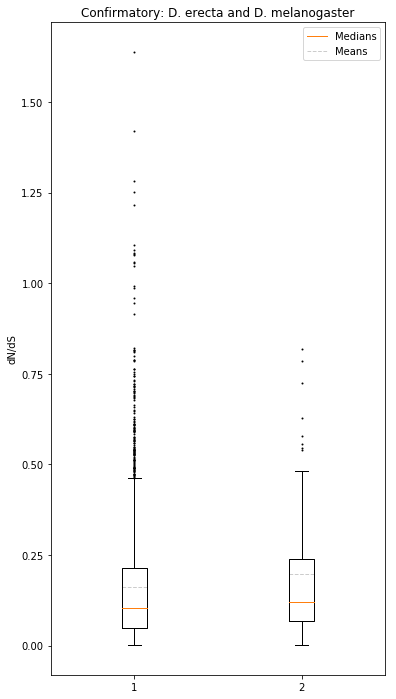

In [175]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,12))
print(np.median(singList1),np.median(dupList1))
print(np.mean(singList1),np.mean(dupList1))
b = ax.boxplot([singList1,dupList1],showmeans=True, meanline=True, flierprops=dict(markersize=1))
for line in b['means']:
    line.set_color((0,0,0,0.2))

l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')
ax.legend()
ax.set_title('Confirmatory: D. erecta and D. melanogaster')
ax.set_ylabel('dN/dS')
# ax.set_ylim(ymax=0.15)
plt.show()

0.10195 0.12664999999999998
0.16600503116651827 0.18358472222222222


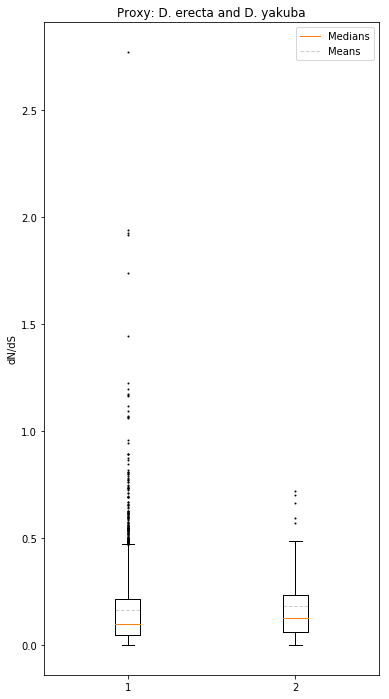

In [177]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,12))
print(np.median(singList),np.median(dupList))
print(np.mean(singList),np.mean(dupList))
b = ax.boxplot([singList,dupList],showmeans=True, meanline=True, flierprops=dict(markersize=1))
for line in b['means']:
    line.set_color((0,0,0,0.2))

l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')
ax.legend()
ax.set_title('Proxy: D. erecta and D. yakuba')
ax.set_ylabel('dN/dS')
# ax.set_ylim(ymax=0.15)
plt.show()

In [179]:
from scipy.stats import mannwhitneyu

print('Trees with dups only in sechellia removed')

cursor.execute('SELECT confirm_rate FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "S" AND excludedReason IS NULL AND notes IS NULL')
singList1 = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT confirm_rate FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "D" AND excludedReason IS NULL AND notes IS NULL')
dupList1 = [x[0] for x in cursor.fetchall()]

print('Confirm rate:')
print(mannwhitneyu(singList1, dupList1,alternative='two-sided'))

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND proxy_rate < 10 AND dup_status == "S" AND excludedReason IS NULL AND notes IS NULL')
singList = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND proxy_rate < 10 AND dup_status == "D" AND excludedReason IS NULL AND notes IS NULL')
dupList = [x[0] for x in cursor.fetchall()]



print('Proxy rate:')
print(mannwhitneyu(singList, dupList, alternative='two-sided'))

print('Tree count, confirm:',len(dupList1)+len(singList1), len(dupList1), 'duplicated,', len(singList1),'singleton')
print('Tree count, proxy:',len(dupList)+len(singList))

Trees with dups only in sechellia removed
Confirm rate:
MannwhitneyuResult(statistic=12521.0, pvalue=0.0018869927071122484)
Proxy rate:
MannwhitneyuResult(statistic=15375.0, pvalue=0.03571412391293175)
Tree count, confirm: 2266 19 duplicated, 2247 singleton
Tree count, proxy: 2265


0.10195 0.2384
0.16600503116651827 0.2857842105263158


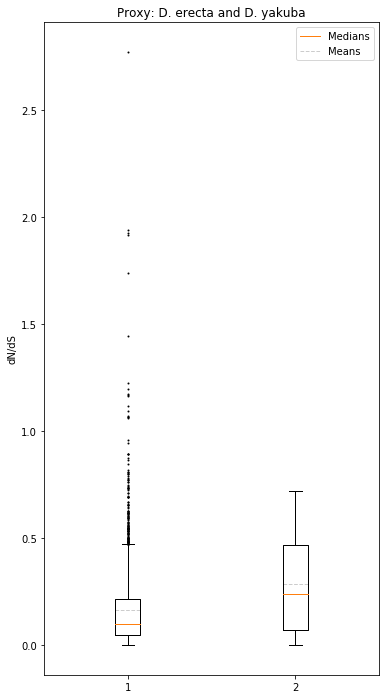

In [180]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,12))
print(np.median(singList),np.median(dupList))
print(np.mean(singList),np.mean(dupList))
b = ax.boxplot([singList,dupList],showmeans=True, meanline=True, flierprops=dict(markersize=1))
for line in b['means']:
    line.set_color((0,0,0,0.2))

l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')
ax.legend()
ax.set_title('Proxy: D. erecta and D. yakuba')
ax.set_ylabel('dN/dS')
# ax.set_ylim(ymax=0.15)
plt.show()

0.1024 0.247
0.16135322652425457 0.33315438596491226


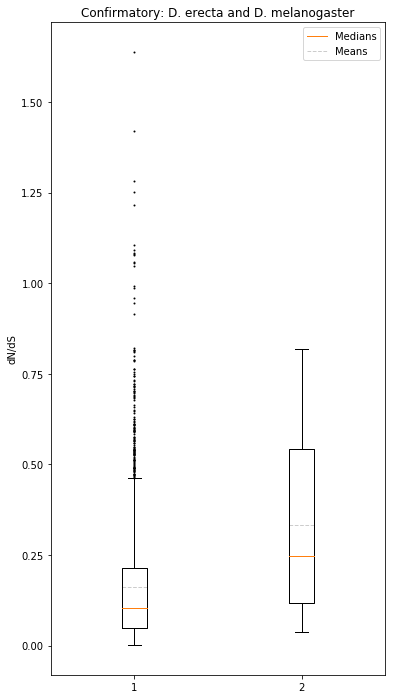

In [181]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,12))
print(np.median(singList1),np.median(dupList1))
print(np.mean(singList1),np.mean(dupList1))
b = ax.boxplot([singList1,dupList1],showmeans=True, meanline=True, flierprops=dict(markersize=1))
for line in b['means']:
    line.set_color((0,0,0,0.2))

l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')
ax.legend()
ax.set_title('Confirmatory: D. erecta and D. melanogaster')
ax.set_ylabel('dN/dS')
# ax.set_ylim(ymax=0.15)
plt.show()

0.0583 0.059


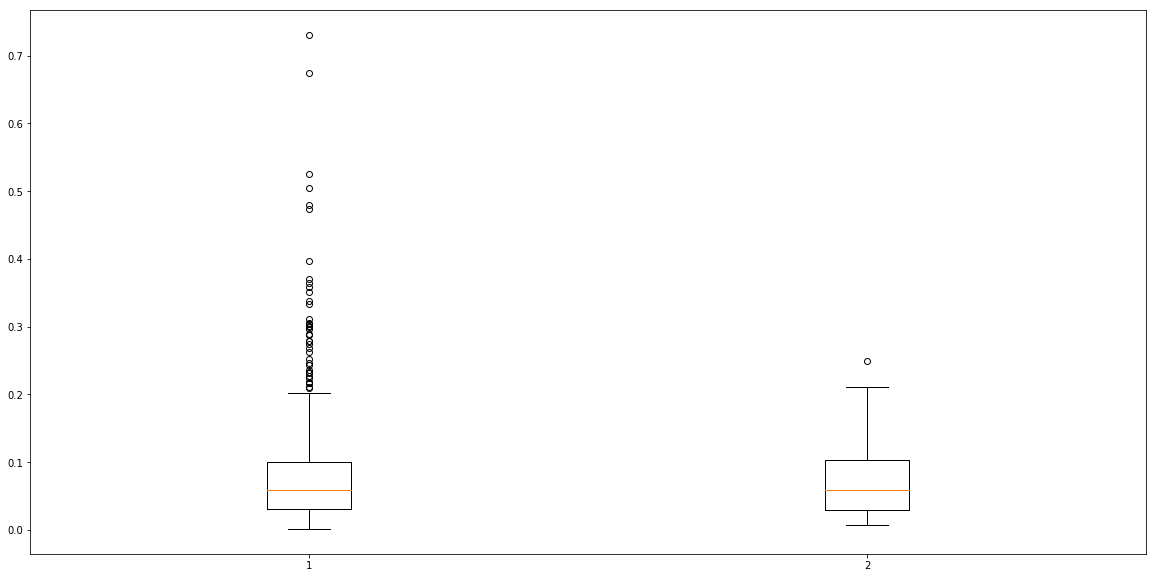

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
print(np.median(singList),np.median(dupList))
ax.boxplot([singList,dupList])
# ax.set_ylim(ymax=0.15)
plt.show()

In [67]:
from scipy.stats import mannwhitneyu

cursor.execute('SELECT dS FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "S" AND excludedReason IS NULL')
singList1 = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "D" AND excludedReason IS NULL')
dupList1 = [x[0] for x in cursor.fetchall()]

# singList1 = [x for x in singList1 if x < 10]
# dupList1 = [x for x in dupList1 if x < 10]

print('Confirm rate:')
print(mannwhitneyu(singList1, dupList1,alternative='two-sided'))

cursor.execute('SELECT dS2 FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dup_status == "S" AND excludedReason IS NULL')
singList = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS2 FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dup_status == "D" AND excludedReason IS NULL')
dupList = [x[0] for x in cursor.fetchall()]

# singList = [x for x in singList if x < 10]
# dupList = [x for x in dupList if x < 10]

print('Proxy rate:')
print(mannwhitneyu(singList, dupList, alternative='two-sided'))

Confirm rate:
MannwhitneyuResult(statistic=191304.5, pvalue=0.2788914302429757)
Proxy rate:
MannwhitneyuResult(statistic=187819.0, pvalue=0.1320990169806361)


1.8404 1.928


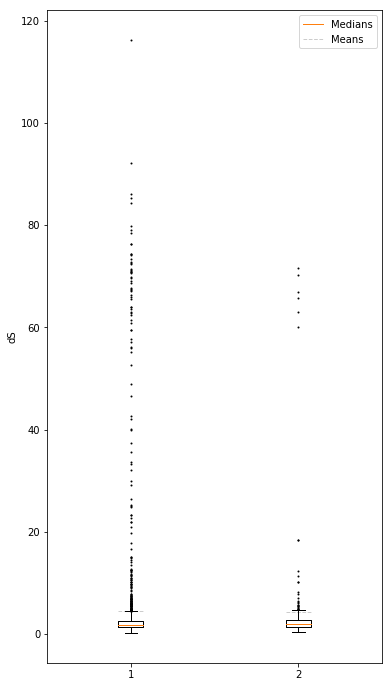

In [59]:
import matplotlib.pyplot as plt
import numpy as np
# singList1 = [x for x in singList1 if x < 10]
# dupList1 = [x for x in dupList1 if x < 10]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,12))
print(np.median(singList1),np.median(dupList1))
b = ax.boxplot([singList1,dupList1],showmeans=True, meanline=True, flierprops=dict(markersize=1))
for line in b['means']:
    line.set_color((0,0,0,0.2))

l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')
ax.legend()
ax.set_ylabel('dS')
# ax.set_ylim(ymax=10)
plt.show()

2.4777 2.6118
10.861181346578366 9.581831221719458


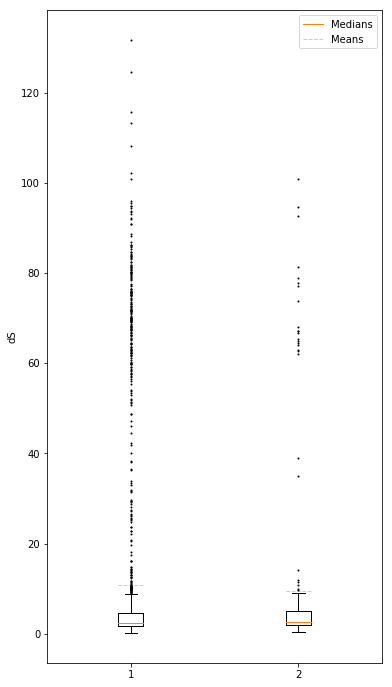

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,12))
# singList = [x for x in singList if x < 10]
# dupList = [x for x in dupList if x < 10]
print(np.median(singList),np.median(dupList))
print(np.mean(singList),np.mean(dupList))
b = ax.boxplot([singList,dupList], showmeans=True, meanline=True, flierprops=dict(markersize=1))

for line in b['means']:
    line.set_color((0,0,0,0.2))

l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')
ax.legend()
ax.set_ylabel('dS')

# ax.set_ylim(ymax=0.15)
plt.show()

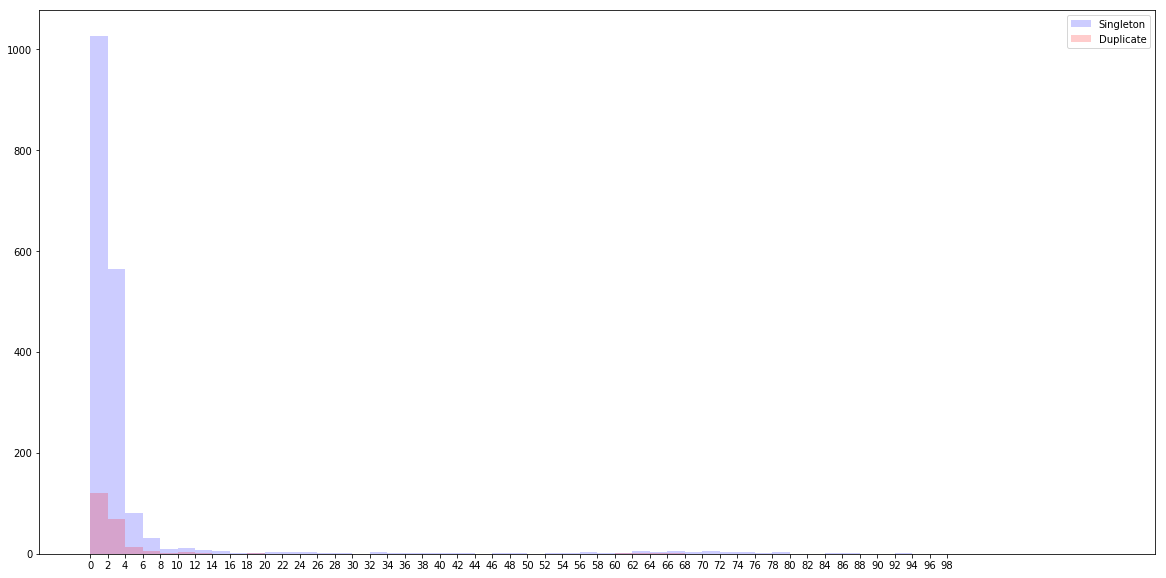

In [75]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.hist(singList1,fc=(0,0,1,0.2),bins=np.arange(0,max(singList1),2),label='Singleton')
ax.hist(dupList1,fc=(1,0,0,0.2),bins=np.arange(0,max(dupList1),2),label='Duplicate')
ax.set_xticks(np.arange(0,100,2))
ax.legend()
plt.show()

In [41]:
from scipy.stats import mannwhitneyu

cursor.execute('SELECT dN FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "S" AND excludedReason IS NULL')
singList1 = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "D" AND excludedReason IS NULL')
dupList1 = [x[0] for x in cursor.fetchall()]

print('Confirm rate:')
print(mannwhitneyu(singList1, dupList1,alternative='two-sided'))

cursor.execute('SELECT dN2 FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dup_status == "S" AND excludedReason IS NULL')
singList = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN2 FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dup_status == "D" AND excludedReason IS NULL')
dupList = [x[0] for x in cursor.fetchall()]

print('Proxy rate:')
print(mannwhitneyu(singList, dupList, alternative='two-sided'))

Confirm rate:
MannwhitneyuResult(statistic=183954.5, pvalue=0.04827474186791317)
Proxy rate:
MannwhitneyuResult(statistic=187562.0, pvalue=0.12427604679744067)


0.0994 0.1084
0.13673852097130243 0.16606923076923077


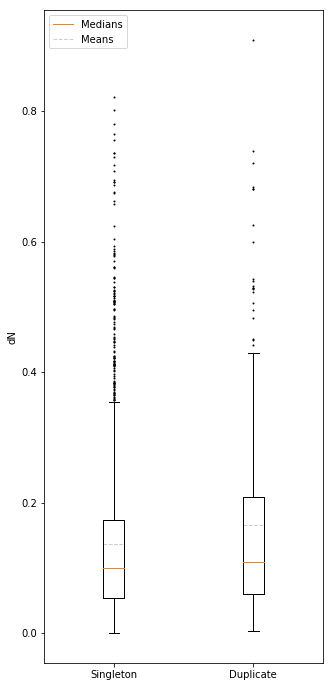

In [53]:
import matplotlib.pyplot as plt
import numpy as np
# singList1 = [x for x in singList1 if x < 10]
# dupList1 = [x for x in dupList1 if x < 10]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,12))
print(np.median(singList1),np.median(dupList1))
print(np.mean(singList1),np.mean(dupList1))
b = ax.boxplot([singList1,dupList1],showmeans=True, meanline=True,labels=['Singleton','Duplicate'],flierprops=dict(markersize=1))

for line in b['means']:
    line.set_color((0,0,0,0.2))

l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')
ax.legend()
ax.set_ylabel('dN')
# ax.set_ylim(ymax=10)
plt.show()

0.1268 0.1338
0.17820292494481238 0.20916380090497738


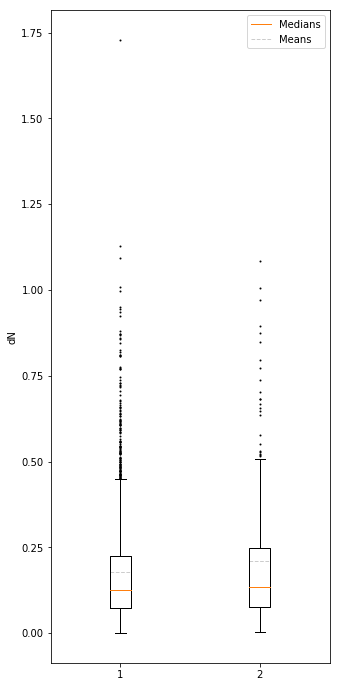

In [54]:
import matplotlib.pyplot as plt
import numpy as np
# singList1 = [x for x in singList1 if x < 10]
# dupList1 = [x for x in dupList1 if x < 10]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,12))
print(np.median(singList),np.median(dupList))
print(np.mean(singList),np.mean(dupList))
b= ax.boxplot([singList,dupList], showmeans= True, meanline= True, flierprops=dict(markersize=1))

for line in b['means']:
    line.set_color((0,0,0,0.2))

l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')
ax.legend()
ax.set_ylabel('dN')
# ax.set_ylim(ymax=10)
plt.show()
# ax.set_ylim(ymax=10)
plt.show()

In [23]:
np.median(dupList1)

0.0315

In [41]:
np.median(dupList)

0.0586

In [75]:
from scipy.stats import chi2_contingency as chi2
chi2([[19,63],[53,266]],correction=False)

(1.9034421912701085,
 0.16769353387160135,
 1,
 array([[ 14.72319202,  67.27680798],
        [ 57.27680798, 261.72319202]]))

In [22]:
cursor.execute('SELECT COUNT(*) FROM processed_trees WHERE NOT (dN_dS_dS > 10 OR dN_dS_dS < 0.01) AND (dup_status == "D")')
cursor.fetchall()

[(241,)]

In [26]:
cursor.execute('UPDATE processed_trees SET confirm_rate = NULL WHERE id == "FBpp0156192"')
cursor.execute('UPDATE processed_trees SET dN_dS_dS = NULL WHERE id == "FBpp0156192"')

In [66]:
from collections import Counter
dupDict = {'ENSP00': 0, 'ENSGGO': 0, 'ENSPTR': 0, 'ENSPPY': 0, 'ENSNLE': 0, 'ENSMMU': 0}
multi = 0
with open('Downloads/msx270_supp-4/SupplementaryData_DuplicableGene_ids.txt','r') as file:
    file.readline()
    for line in file:
        spList = []
        line = line.strip('\n').split('\t')
        line = line[1]
        line = line.split(',')
        for x in line:
            spList.append(x[:6])
        countDict = Counter(spList)
        alreadyDup = False
        multiSp = False
        for x in countDict:
            if countDict[x] > 1 and alreadyDup == True:
                multi += 1
                dupDict[x] = dupDict[x] + 1
            elif countDict[x] > 1:
                alreadyDup = True
                dupDict[x] = dupDict[x] + 1
            
for x in dupDict:
    dupDict[x] = (dupDict[x]/72)*100
print(multi)
dupDict

19


{'ENSGGO': 33.33333333333333,
 'ENSMMU': 0.0,
 'ENSNLE': 0.0,
 'ENSP00': 45.83333333333333,
 'ENSPPY': 26.38888888888889,
 'ENSPTR': 20.833333333333336}

In [72]:
from collections import Counter
dupDict = {'Dgri': 0, 'Dwil': 0, 'Dvir': 0, 'Dmoj': 0, 'Dere': 0, 'Dmel': 0, 'Dana': 0, 'Dyak': 0, 'Dpse': 0, 'Dper': 0, 'Dsim': 0, 'Dsec': 0}
multi = 0
cursor.execute('SELECT tree FROM processed_trees WHERE dup_status == "D" AND excludedReason IS NULL')
res = cursor.fetchall()
for tree in [x[0] for x in res]:
    tree = PhyloTree(tree)
    spList = []
    
    for node in tree.traverse():
        if node.name == '':
            continue
        spList.append(retrieve_species(node))
    countDict = Counter(spList)
    alreadyDup = False
    multiSp = False
    for x in countDict:
        if countDict[x] > 1 and alreadyDup == True:
            multi += 1
            dupDict[x] = dupDict[x] + 1
        elif countDict[x] > 1:
            alreadyDup = True
            dupDict[x] = dupDict[x] + 1
            
for x in dupDict:
    dupDict[x] = (dupDict[x]/len(res))*100
print(multi)
dupDict

63


{'Dana': 5.775075987841945,
 'Dere': 3.0395136778115504,
 'Dgri': 0.0,
 'Dmel': 3.343465045592705,
 'Dmoj': 0.303951367781155,
 'Dper': 26.74772036474164,
 'Dpse': 19.148936170212767,
 'Dsec': 23.404255319148938,
 'Dsim': 4.86322188449848,
 'Dvir': 1.21580547112462,
 'Dwil': 0.0,
 'Dyak': 31.30699088145897}

In [ ]:
multi/len(res)

In [93]:
import requests, json
g = 'FBgn0119012'
url = 'http://rest.ensemblgenomes.org/homology/id/'+ g + '?compara=metazoa;type=orthologues;'
headers = {'Content-Type':'application/json'}
orthList = requests.get(url, headers=headers).json()['data'][0]['homologies']
filtered = [x for x in orthList if x['target']['species'] == 'drosophila_pseudoobscura']
filtered

[{'dn_ds': 0.37172,
  'method_link_type': 'ENSEMBL_ORTHOLOGUES',
  'source': {'align_seq': 'MR-YYENSYCYGYRHHHYRPNIEVDVFPGWGGSYYQAPVAR--PEVVVVTQAATYTPM-AGGQVMMPQPQPYAAGGMSMGT-AGYYQ-QQQTYQYQQQ----QQYNNPPYPQ---W',
   'cigar_line': '2MD38M2D15MD22MD5MD10M4D10M3DM',
   'id': 'FBgn0119012',
   'perc_id': 58.2524,
   'perc_pos': 64.0777,
   'protein_id': 'FBpp0145438',
   'species': 'drosophila_grimshawi',
   'taxon_id': 7222},
  'target': {'align_seq': 'MRPYYEDPCGCPPRHHHGRPNIEIDVLPNWGGGYYPPATPART-EVVYVTPGASYMPPAVGPQMM--MPQPYG--GMTMG-SAGYY-QQQQGYEYQYQYQQQQPY--PPYPQYQQW',
   'cigar_line': '43MD21M2D6M2D5MD5MD18M2D9M',
   'id': 'FBgn0073751',
   'perc_id': 56.0748,
   'perc_pos': 61.6822,
   'protein_id': 'FBpp0280146',
   'species': 'drosophila_pseudoobscura',
   'taxon_id': 46245},
  'taxonomy_level': 'Drosophila',
  'type': 'ortholog_one2one'}]

Confirm rate p val:
MannwhitneyuResult(statistic=12521.0, pvalue=0.0018869927071122484)
Effect size:
-0.065282367025014
Medians: 0.1024 0.247
Means: 0.16135322652425457 0.33315438596491226

Confirm dS p val:
MannwhitneyuResult(statistic=18904.5, pvalue=0.3899583133089861)
Effect size:
-0.018063513713113613
Medians: 0.2905 0.3115
Means: 0.3032791277258567 0.34508333333333335

Confirm dN p val:
MannwhitneyuResult(statistic=12395.0, pvalue=0.0016226558174640257)
Effect size:
-0.06621439107409358
Medians: 0.0286 0.0994
Means: 0.049550823319982194 0.12052105263157896


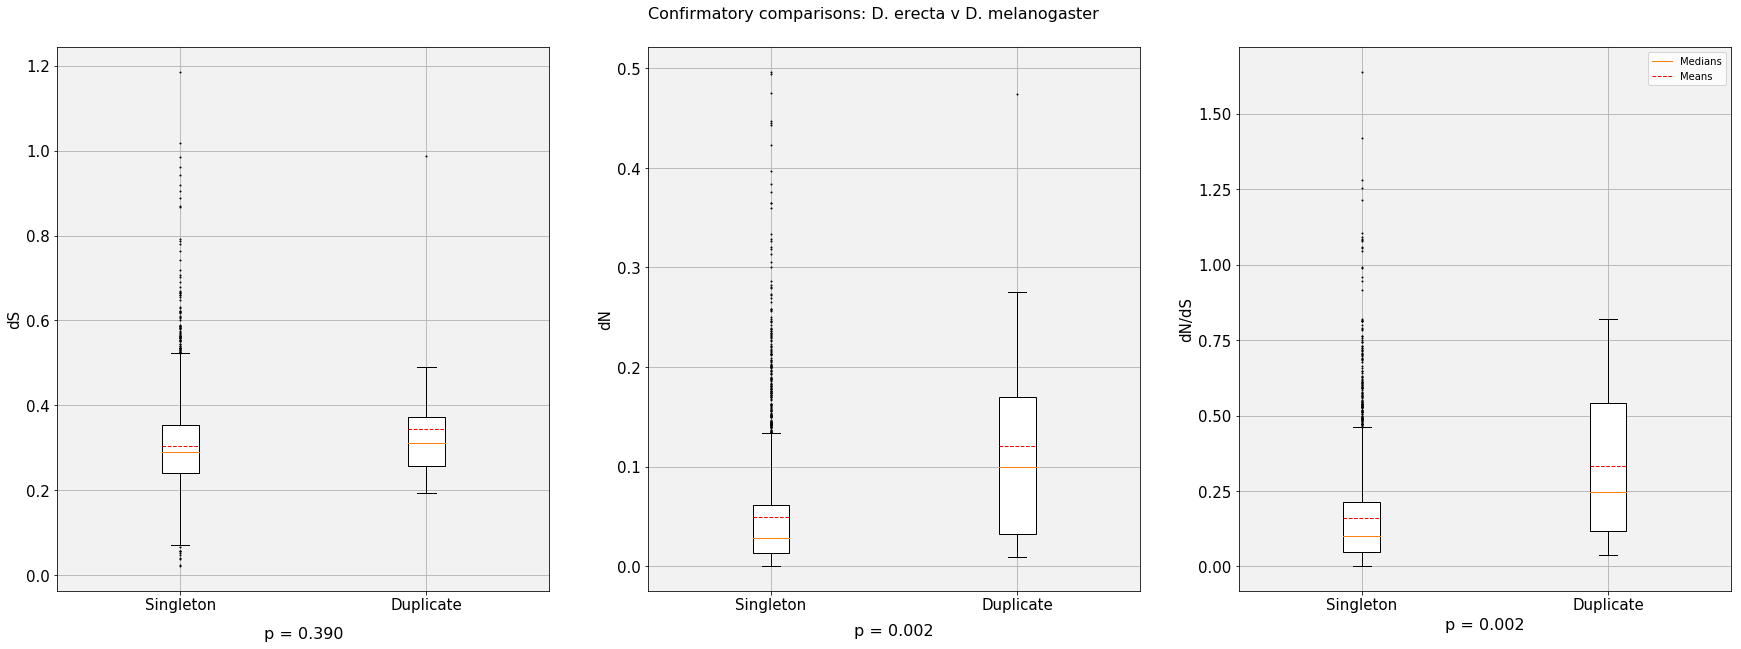

In [222]:
import matplotlib.pyplot as plt
import numpy as np

cursor.execute('SELECT confirm_rate FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "S" AND dS > 0.01 AND excludedReason IS NULL')
singList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT confirm_rate FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "D" AND dS > 0.01 AND excludedReason IS NULL AND notes IS NULL')
dupList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS FROM processed_trees WHERE dup_status == "S" AND excludedReason IS NULL')
singList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS FROM processed_trees WHERE dup_status == "D" AND excludedReason IS NULL AND notes IS NULL')
dupList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN FROM processed_trees WHERE dup_status == "S" AND excludedReason IS NULL')
singList_dn = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN FROM processed_trees WHERE dup_status == "D" AND excludedReason IS NULL AND notes IS NULL')
dupList_dn = [x[0] for x in cursor.fetchall()]

print('Confirm rate p val:')
print(mannwhitneyu(singList_rate, dupList_rate,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_rate,dupList_rate))
print('Medians:',np.median(singList_rate),np.median(dupList_rate))
print('Means:',np.mean(singList_rate),np.mean(dupList_rate))
print('')

print('Confirm dS p val:')
print(mannwhitneyu(singList_ds, dupList_ds,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_ds,dupList_ds))
print('Medians:',np.median(singList_ds),np.median(dupList_ds))
print('Means:',np.mean(singList_ds),np.mean(dupList_ds))
print('')
print('Confirm dN p val:')
print(mannwhitneyu(singList_dn, dupList_dn,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_dn,dupList_dn))
print('Medians:',np.median(singList_dn),np.median(dupList_dn))
print('Means:',np.mean(singList_dn),np.mean(dupList_dn))




fig, axes = plt.subplots(1,3,figsize=(30,10))
ax1, ax2, ax3 = axes
for a in [ax1,ax2,ax3]:
    a.yaxis.set_tick_params(labelsize=15)
    a.xaxis.set_tick_params(labelsize=15)
ax2.text(0.5,0.55,'Confirmatory comparisons: D. erecta v D. melanogaster',fontdict=dict(size=16))

b= ax1.boxplot([singList_ds,dupList_ds], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax1.set_ylabel('dS',fontdict=dict(fontsize=15))
ax1.set_facecolor((0,0,0,0.05))
ax1.grid()


b= ax2.boxplot([singList_dn,dupList_dn], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax2.set_ylabel('dN',fontdict=dict(fontsize=15))
ax2.set_facecolor((0,0,0,0.05))
ax2.grid()



b= ax3.boxplot([singList_rate,dupList_rate], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax3.set_ylabel('dN/dS',fontdict=dict(fontsize=15))
ax3.set_facecolor((0,0,0,0.05))
ax3.grid()
ax3.legend(loc='upper right')

ax1.text(1.5,-0.15,'p = 0.390', fontsize=16, ha='center')
ax2.text(1.5,-0.07,'p = 0.002', fontsize=16, ha='center')
ax3.text(1.5,-0.21,'p = 0.002', fontsize=16, ha='center')

plt.savefig('boxplots_dere_outgroup_no_dsec_dups.png')
plt.show()

Proxy rate p val:
MannwhitneyuResult(statistic=15375.0, pvalue=0.03571412391293175)
Effect size:
-0.04413029822482847
Medians: 0.10195 0.2384
Means: 0.16600503116651827 0.2857842105263158

Proxy dS p val:
MannwhitneyuResult(statistic=14991.0, pvalue=0.025394563247531803)
Effect size:
-0.04697263880153665
Medians: 0.2223 0.2473
Means: 0.23252800534283172 0.306

Proxy dN p val:
MannwhitneyuResult(statistic=14532.0, pvalue=0.01652732002032491)
Effect size:
-0.05037012402213313
Medians: 0.0218 0.0694
Means: 0.03907711487088157 0.0903157894736842


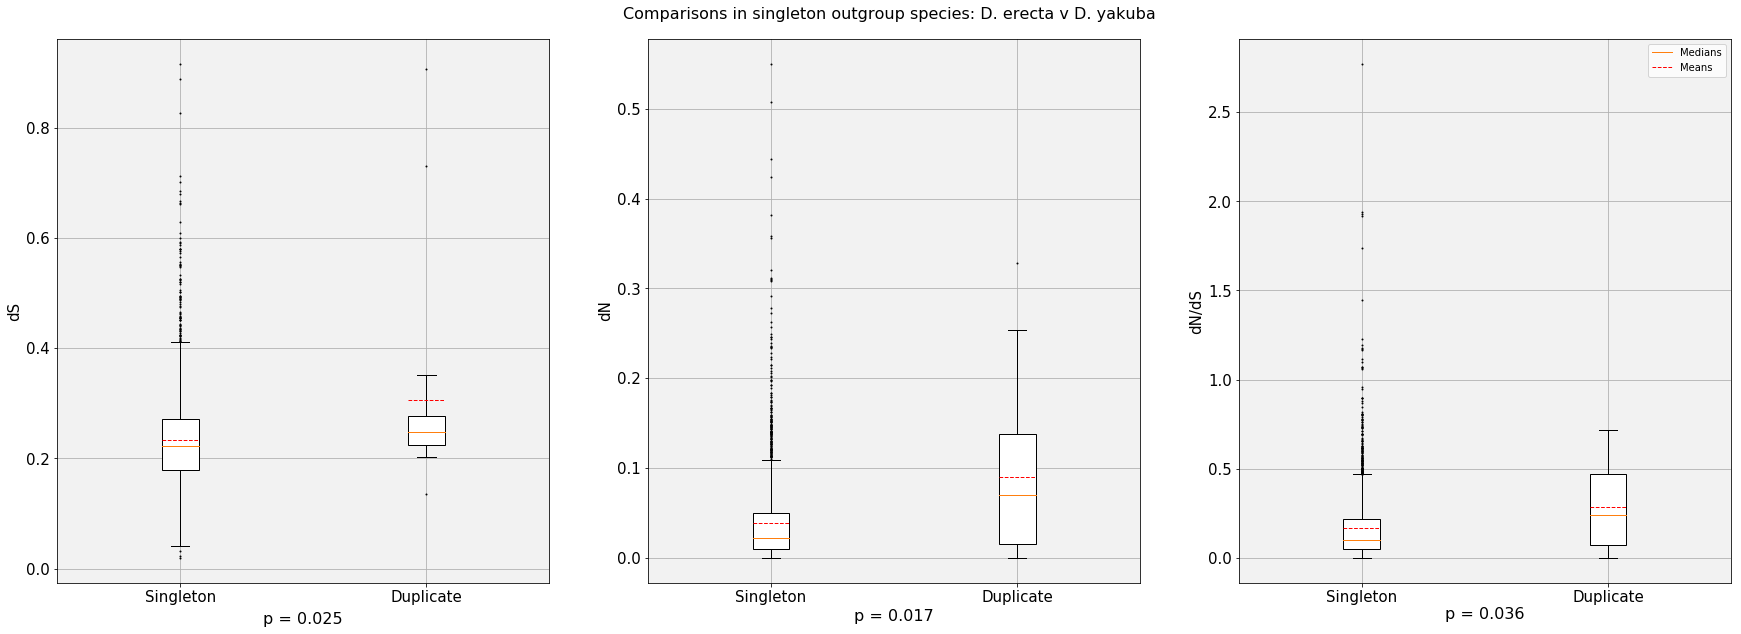

In [224]:
cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dup_status == "S" AND dS2 > 0.01 AND excludedReason IS NULL')
singList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dup_status == "D" AND dS2 > 0.01 AND excludedReason IS NULL AND notes IS NULL')
dupList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS2 FROM processed_trees WHERE dup_status == "S" AND dS2 > 0.01 AND  excludedReason IS NULL')
singList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS2 FROM processed_trees WHERE dup_status == "D" AND dS2 > 0.01 AND excludedReason IS NULL AND notes IS NULL')
dupList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN2 FROM processed_trees WHERE dup_status == "S" AND dS2 > 0.01 AND excludedReason IS NULL')
singList_dn = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN2 FROM processed_trees WHERE dup_status == "D" AND dS2 > 0.01 AND excludedReason IS NULL AND notes IS NULL')
dupList_dn = [x[0] for x in cursor.fetchall()]

print('Proxy rate p val:')
print(mannwhitneyu(singList_rate, dupList_rate,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_rate,dupList_rate))
print('Medians:',np.median(singList_rate),np.median(dupList_rate))
print('Means:',np.mean(singList_rate),np.mean(dupList_rate))
print('')
print('Proxy dS p val:')
print(mannwhitneyu(singList_ds, dupList_ds,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_ds,dupList_ds))
print('Medians:',np.median(singList_ds),np.median(dupList_ds))
print('Means:',np.mean(singList_ds),np.mean(dupList_ds))
print('')
print('Proxy dN p val:')
print(mannwhitneyu(singList_dn, dupList_dn,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_dn,dupList_dn))
print('Medians:',np.median(singList_dn),np.median(dupList_dn))
print('Means:',np.mean(singList_dn),np.mean(dupList_dn))


fig, axes = plt.subplots(1,3,figsize=(30,10))
ax1, ax2, ax3 = axes
for a in [ax1,ax2,ax3]:
    a.yaxis.set_tick_params(labelsize=15)
    a.xaxis.set_tick_params(labelsize=15)
ax2.text(0.4,0.6,'Comparisons in singleton outgroup species: D. erecta v D. yakuba',fontdict=dict(size=16))

b= ax1.boxplot([singList_ds,dupList_ds], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax1.set_ylabel('dS',fontdict=dict(fontsize=15))
ax1.set_facecolor((0,0,0,0.05))
ax1.grid()


b= ax2.boxplot([singList_dn,dupList_dn], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax2.set_ylabel('dN',fontdict=dict(fontsize=15))
ax2.set_facecolor((0,0,0,0.05))
ax2.grid()



b= ax3.boxplot([singList_rate,dupList_rate], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax3.set_ylabel('dN/dS',fontdict=dict(fontsize=15))
ax3.set_facecolor((0,0,0,0.05))
ax3.grid()
ax3.legend(loc= 'upper right')

ax1.text(1.5,-0.1,'p = 0.025', fontsize=16, ha='center')
ax2.text(1.5,-0.07,'p = 0.017', fontsize=16, ha='center')
ax3.text(1.5,-0.34,'p = 0.036', fontsize=16, ha='center')

plt.savefig('boxplot_dere_outgroup_proxy_no_dsec_dups.png')
plt.show()

Confirm rate p val:
MannwhitneyuResult(statistic=70959.0, pvalue=0.07573319364151848)
Medians: 0.1024 0.12015
Means: 0.16135322652425457 0.1961310185185185

Confirm dS p val:
MannwhitneyuResult(statistic=80263.0, pvalue=0.9105230942975159)
Medians: 0.2905 0.28125
Means: 0.3032791277258567 0.3222344907407408

Confirm dN p val:
MannwhitneyuResult(statistic=70371.5, pvalue=0.05996791442705939)
Medians: 0.0286 0.034
Means: 0.049550823319982194 0.07549583333333335


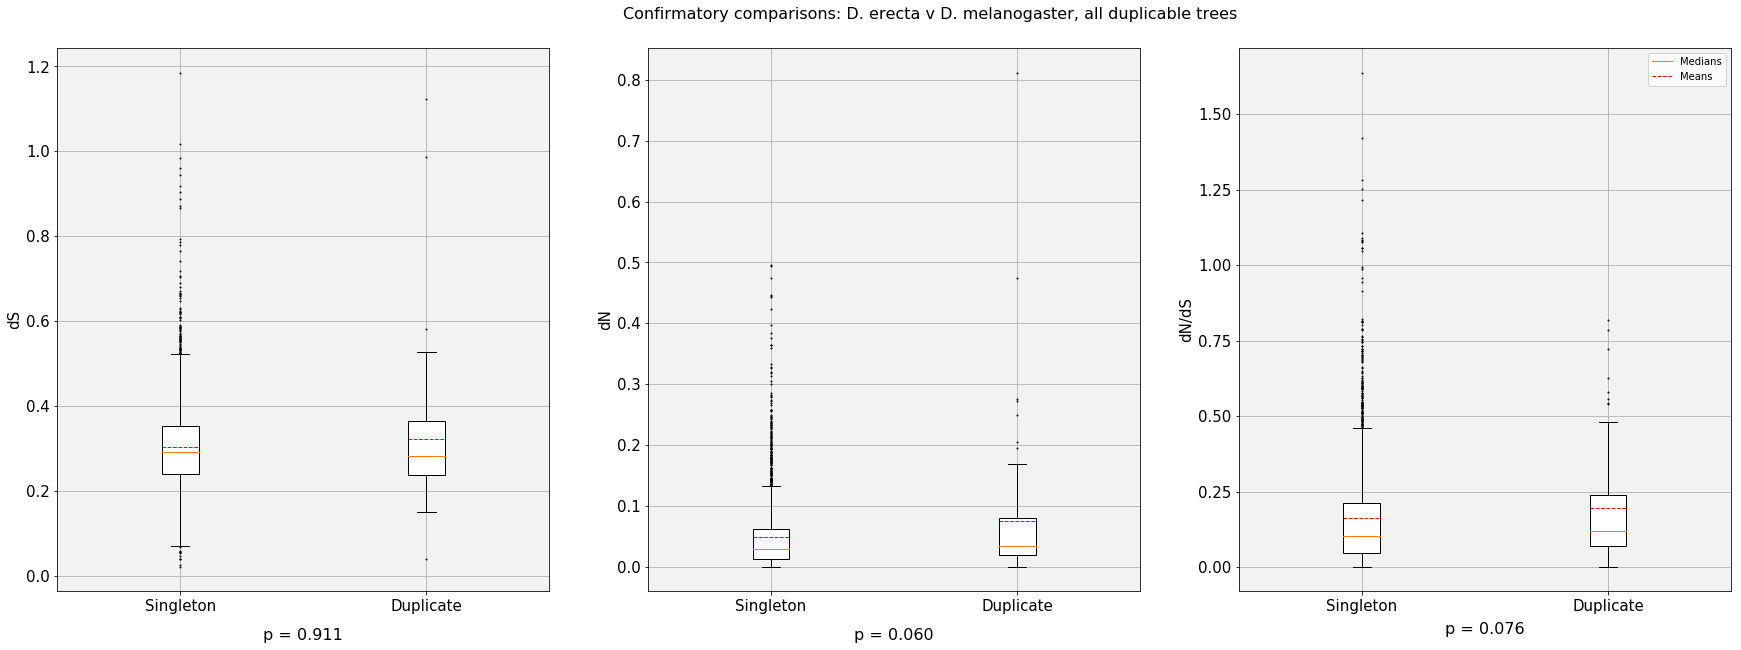

In [215]:
import matplotlib.pyplot as plt
import numpy as np

cursor.execute('SELECT confirm_rate FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "S" AND dS > 0.01 AND excludedReason IS NULL')
singList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT confirm_rate FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "D" AND dS > 0.01 AND excludedReason IS NULL')
dupList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS FROM processed_trees WHERE dup_status == "S" AND excludedReason IS NULL')
singList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS FROM processed_trees WHERE dup_status == "D" AND excludedReason IS NULL')
dupList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN FROM processed_trees WHERE dup_status == "S" AND excludedReason IS NULL')
singList_dn = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN FROM processed_trees WHERE dup_status == "D" AND excludedReason IS NULL')
dupList_dn = [x[0] for x in cursor.fetchall()]

print('Confirm rate p val:')
print(mannwhitneyu(singList_rate, dupList_rate,alternative='two-sided'))
print('Medians:',np.median(singList_rate),np.median(dupList_rate))
print('Means:',np.mean(singList_rate),np.mean(dupList_rate))
print('')

print('Confirm dS p val:')
print(mannwhitneyu(singList_ds, dupList_ds,alternative='two-sided'))
print('Medians:',np.median(singList_ds),np.median(dupList_ds))
print('Means:',np.mean(singList_ds),np.mean(dupList_ds))
print('')
print('Confirm dN p val:')
print(mannwhitneyu(singList_dn, dupList_dn,alternative='two-sided'))
print('Medians:',np.median(singList_dn),np.median(dupList_dn))
print('Means:',np.mean(singList_dn),np.mean(dupList_dn))




fig, axes = plt.subplots(1,3,figsize=(30,10))
ax1, ax2, ax3 = axes
for a in [ax1,ax2,ax3]:
    a.yaxis.set_tick_params(labelsize=15)
    a.xaxis.set_tick_params(labelsize=15)
ax2.text(0.4,0.9,'Confirmatory comparisons: D. erecta v D. melanogaster, all duplicable trees',fontdict=dict(size=16))

b= ax1.boxplot([singList_ds,dupList_ds], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax1.set_ylabel('dS',fontdict=dict(fontsize=15))
ax1.set_facecolor((0,0,0,0.05))
ax1.grid()


b= ax2.boxplot([singList_dn,dupList_dn], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax2.set_ylabel('dN',fontdict=dict(fontsize=15))
ax2.set_facecolor((0,0,0,0.05))
ax2.grid()



b= ax3.boxplot([singList_rate,dupList_rate], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax3.set_ylabel('dN/dS',fontdict=dict(fontsize=15))
ax3.set_facecolor((0,0,0,0.05))
ax3.grid()
ax3.legend(loc='upper right')

ax1.text(1.5,-0.15,'p = 0.911', fontsize=16, ha='center')
ax2.text(1.5,-0.12,'p = 0.060', fontsize=16, ha='center')
ax3.text(1.5,-0.22,'p = 0.076', fontsize=16, ha='center')

plt.savefig('boxplots_dere_outgroup_no_dsec_dups.png')
plt.show()

Proxy rate p val:
MannwhitneyuResult(statistic=73002.0, pvalue=0.160045133456736)
Medians: 0.10195 0.12664999999999998
Means: 0.16600503116651827 0.18358472222222222

Proxy dS p val:
MannwhitneyuResult(statistic=72764.5, pvalue=0.1478008747398707)
Medians: 0.2223 0.2365
Means: 0.23252800534283172 0.25140555555555555

Proxy dN p val:
MannwhitneyuResult(statistic=71500.0, pvalue=0.09421851802464305)
Medians: 0.0218 0.0312
Means: 0.03907711487088157 0.05114305555555556


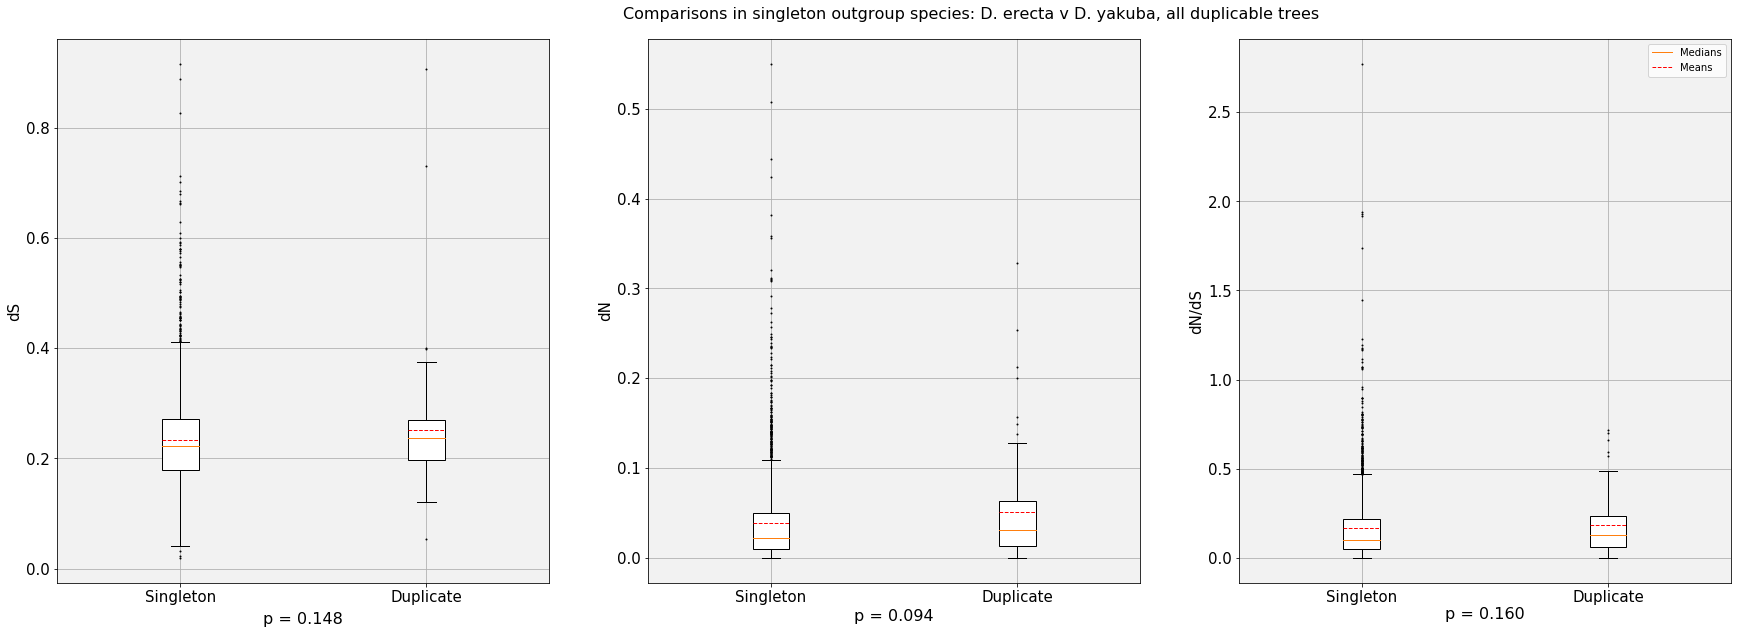

In [217]:
cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dup_status == "S" AND dS2 > 0.01 AND excludedReason IS NULL')
singList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dup_status == "D" AND dS2 > 0.01 AND excludedReason IS NULL')
dupList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS2 FROM processed_trees WHERE dup_status == "S" AND dS2 > 0.01 AND  excludedReason IS NULL')
singList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS2 FROM processed_trees WHERE dup_status == "D" AND dS2 > 0.01 AND excludedReason IS NULL')
dupList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN2 FROM processed_trees WHERE dup_status == "S" AND dS2 > 0.01 AND excludedReason IS NULL')
singList_dn = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN2 FROM processed_trees WHERE dup_status == "D" AND dS2 > 0.01 AND excludedReason IS NULL')
dupList_dn = [x[0] for x in cursor.fetchall()]

print('Proxy rate p val:')
print(mannwhitneyu(singList_rate, dupList_rate,alternative='two-sided'))
print('Medians:',np.median(singList_rate),np.median(dupList_rate))
print('Means:',np.mean(singList_rate),np.mean(dupList_rate))
print('')
print('Proxy dS p val:')
print(mannwhitneyu(singList_ds, dupList_ds,alternative='two-sided'))
print('Medians:',np.median(singList_ds),np.median(dupList_ds))
print('Means:',np.mean(singList_ds),np.mean(dupList_ds))
print('')
print('Proxy dN p val:')
print(mannwhitneyu(singList_dn, dupList_dn,alternative='two-sided'))
print('Medians:',np.median(singList_dn),np.median(dupList_dn))
print('Means:',np.mean(singList_dn),np.mean(dupList_dn))


fig, axes = plt.subplots(1,3,figsize=(30,10))
ax1, ax2, ax3 = axes
for a in [ax1,ax2,ax3]:
    a.yaxis.set_tick_params(labelsize=15)
    a.xaxis.set_tick_params(labelsize=15)
ax2.text(0.4,0.6,'Comparisons in singleton outgroup species: D. erecta v D. yakuba, all duplicable trees',fontdict=dict(size=16))

b= ax1.boxplot([singList_ds,dupList_ds], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax1.set_ylabel('dS',fontdict=dict(fontsize=15))
ax1.set_facecolor((0,0,0,0.05))
ax1.grid()


b= ax2.boxplot([singList_dn,dupList_dn], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax2.set_ylabel('dN',fontdict=dict(fontsize=15))
ax2.set_facecolor((0,0,0,0.05))
ax2.grid()



b= ax3.boxplot([singList_rate,dupList_rate], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax3.set_ylabel('dN/dS',fontdict=dict(fontsize=15))
ax3.set_facecolor((0,0,0,0.05))
ax3.grid()
ax3.legend(loc= 'upper right')

ax1.text(1.5,-0.1,'p = 0.148', fontsize=16, ha='center')
ax2.text(1.5,-0.07,'p = 0.094', fontsize=16, ha='center')
ax3.text(1.5,-0.34,'p = 0.160', fontsize=16, ha='center')

plt.savefig('boxplot_dere_outgroup_proxy_no_dsec_dups.png')
plt.show()

In [4]:
cursor.execute('SELECT tree FROM processed_trees WHERE (excludedReason IS NULL) AND dup_status == "D"')
output = [x[0] for x in cursor.fetchall()]
count, dupCount = 0,1
spList = ['Dere','Dsim','Dsec','Dmel','Dyak']
for sp in spList:
    count, dupCount = 0,0
    for tree in output:
        count += 1
        dcount = 0
        t = PhyloTree(tree)
        for node in t.traverse():
            if sp in node.name:
                dcount += 1
        if dcount > 1:
            dupCount += 1
    print(sp, dupCount, count)

Dere 11 221
Dsim 19 221
Dsec 87 221
Dmel 9 221
Dyak 116 221


In [56]:
with open('dyak_gene_split_paralogs.txt','r') as file:
    for line in file:
        line = line.strip('\n').split('\t')
        splitGeneList.append((line[0],line[1]))

import requests,json
cursor.execute('SELECT tree FROM processed_trees WHERE excludedReason IS NULL AND dup_status == "D" AND dup_in_sp == "True"')
treeList = [x[0] for x in cursor.fetchall()]
count = 0
yakDupCount = 0
for tree in treeList:
    tree = PhyloTree(tree)
    yakCount = 0
    yakList = []
    yakPairList = []
    for node in tree.traverse():
        if 'Dyak' in node.name:
            yakCount += 1
            ID = retrieve_gene_id(node)
            url = 'http://rest.ensemblgenomes.org/lookup/id/' + ID
            tID = requests.get(url, headers = {'Content-Type':'application/json'}).json()['Parent']
            url = 'http://rest.ensemblgenomes.org/lookup/id/' + tID
            gID = requests.get(url, headers = {'Content-Type':'application/json'}).json()['Parent']
            yakList.append(gID)
            for x in itertools.combinations(yakList,2):
                yakPairList.append(x)
    if yakCount > 1:
        yakDupCount += 1
    for a,b in yakPairList:
        if (a,b) in splitGeneList or (b,a) in splitGeneList:
            count += 1
            break
print(yakDupCount)
print(count)

116
3


In [58]:
with open('dsec_gene_split_paralogs.txt','r') as file:
    for line in file:
        line = line.strip('\n').split('\t')
        splitGeneList.append((line[0],line[1]))

import requests,json
cursor.execute('SELECT tree FROM processed_trees WHERE excludedReason IS NULL AND dup_status == "D"')
treeList = [x[0] for x in cursor.fetchall()]
count = 0
secDupCount = 0
for tree in treeList:
    tree = PhyloTree(tree)
    secCount = 0
    secList = []
    secPairList = []
    for node in tree.traverse():
        if 'Dsec' in node.name:
            secCount += 1
            ID = retrieve_gene_id(node)
            url = 'http://rest.ensemblgenomes.org/lookup/id/' + ID
            tID = requests.get(url, headers = {'Content-Type':'application/json'}).json()['Parent']
            url = 'http://rest.ensemblgenomes.org/lookup/id/' + tID
            gID = requests.get(url, headers = {'Content-Type':'application/json'}).json()['Parent']
            secList.append(gID)
            for x in itertools.combinations(secList,2):
                secPairList.append(x)
    if secCount > 1:
        secDupCount += 1
    for a,b in secPairList:
        if (a,b) in splitGeneList or (b,a) in splitGeneList:
            count += 1
            break
print(secDupCount)
print(count)

87
25


In [54]:
a = flatten(paralogList)
b = flatten(flatten(splitGeneList))
for x in a:
    if x in b:
        print(x)

In [55]:
b

['FBgn0275735',
 'FBgn0275873',
 'FBgn0241881',
 'FBgn0241882',
 'FBgn0276035',
 'FBgn0275784',
 'FBgn0276035',
 'FBgn0277230',
 'FBgn0276035',
 'FBgn0230814',
 'FBgn0276502',
 'FBgn0275506',
 'FBgn0276942',
 'FBgn0228869',
 'FBgn0231573',
 'FBgn0276156',
 'FBgn0239737',
 'FBgn0234999',
 'FBgn0239737',
 'FBgn0234135',
 'FBgn0277002',
 'FBgn0276189',
 'FBgn0275641',
 'FBgn0232658',
 'FBgn0275641',
 'FBgn0276513',
 'FBgn0275641',
 'FBgn0276730',
 'FBgn0239681',
 'FBgn0277331',
 'FBgn0276540',
 'FBgn0276867',
 'FBgn0276143',
 'FBgn0276442',
 'FBgn0275511',
 'FBgn0232658',
 'FBgn0275511',
 'FBgn0276513',
 'FBgn0232380',
 'FBgn0232658',
 'FBgn0232380',
 'FBgn0276513',
 'FBgn0232380',
 'FBgn0276730',
 'FBgn0233898',
 'FBgn0241882',
 'FBgn0276513',
 'FBgn0275511',
 'FBgn0276513',
 'FBgn0232380',
 'FBgn0276513',
 'FBgn0276970',
 'FBgn0276513',
 'FBgn0275641',
 'FBgn0277328',
 'FBgn0276521',
 'FBgn0277355',
 'FBgn0232416',
 'FBgn0232184',
 'FBgn0242386',
 'FBgn0276806',
 'FBgn0230814',
 'FBgn02

In [ ]:
cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND proxy_rate < 10 AND dup_status == "S" AND dS2 > 0.01 AND dS2 < 2 AND excludedReason IS NULL')
singList = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND proxy_rate < 10 AND dup_status == "D" AND dS2 > 0.01 AND dS2 < 2 AND excludedReason IS NULL')
dupList = [x[0] for x in cursor.fetchall()]

print('Proxy rate:')
print(mannwhitneyu(singList, dupList, alternative='two-sided'))

print('Tree count, proxy:',len(dupList)+len(singList))
fig, axes = plt.subplots(1,4,figsize=(20,10))

In [259]:
# add columns for annotated split all/some/none, actual dups Y/N, all for Dsec dups specifically
# cursor.execute('ALTER TABLE processed_trees ADD COLUMN annotated_split TEXT')
# cursor.execute('ALTER TABLE processed_trees ADD COLUMN canonical_dup TEXT')
# update annotated split genes (for all dups only in Dsec) - record if other dups exist in tree for Dsec: if not can exclude (or define as singletons???)
import time
cursor.execute('SELECT id, tree FROM processed_trees WHERE notes == "Duplication only in sechellia" AND excludedReason IS NULL')
res = cursor.fetchall()
with open('dubiousDsecParalogs.fasta','w') as file:
    for ID, tree in res:
        dsecList = []
        homList = []
        pairsDone = []
        tree = PhyloTree(tree)
        for node in tree.traverse():
            if 'Dsec' in node.name:
                geneName = re.search('.*_(FB.*)_',node.name).group(1)
                dsecList.append(geneName)
        for p in dsecList:
            for p2 in dsecList:
                if p != p2:
                    if (p,p2) not in pairsDone and (p2,p) not in pairsDone:
                        cursor.execute('SELECT homology_type FROM Dsec_paralogs WHERE (id == ? AND para_id == ?)',(p,p2))
                        h = cursor.fetchall()
                        if h[0][0] == "gene_split":
                            homList.append('split')
                        else:
                            homList.append('good')
                        if len(set(homList)) == 1 and 'split' in set(homList):
                            cursor.execute('UPDATE processed_trees SET annotated_split = "all" WHERE id == ?',(ID,))
                        elif len(set(homList)) == 1 and 'good' in set(homList):
                            print(p,p2)
                            cursor.execute('UPDATE processed_trees SET annotated_split = "none" WHERE id == ?',(ID,))
                            # for any other pairs, check blast hits (what cutoffs to use?)
                            # need to get gene seqs for each id to blast against the long read assembly
                            done = False
                            while done == False:
                                try:
                                    url1a = 'http://rest.ensembl.org/lookup/id/' + p + '?'
                                    transID1 = requests.get(url1a, headers=headers).json()['Parent']
                                    url1b = 'http://rest.ensembl.org/lookup/id/' + transID1 + '?'
                                    geneID1 = requests.get(url1b, headers=headers).json()['Parent']

                                    url2a = 'http://rest.ensembl.org/lookup/id/' + p2 + '?'
                                    transID2 = requests.get(url2a, headers=headers).json()['Parent']
                                    url2b = 'http://rest.ensembl.org/lookup/id/' + transID2 + '?'
                                    geneID2 = requests.get(url2b, headers=headers).json()['Parent']

                                    seqUrl1 = 'http://rest.ensembl.org/sequence/id/' + geneID1 + '?'
                                    geneSeq1 = requests.get(seqUrl1, headers=headers).json()['seq']
                                    seqUrl2 = 'http://rest.ensembl.org/sequence/id/' + geneID2 + '?'
                                    geneSeq2 = requests.get(seqUrl2, headers=headers).json()['seq']

                                    done = True
                                except Exception as e:
                                    time.sleep(1)
                                    print('Trying again:',p,p2)
                                    done = False
                            file.write('>'+p+'\n')
                            file.write(geneSeq1+'\n')
                            file.write('>'+p2+'\n')
                            file.write(geneSeq2+'\n')
                            # do I need to do a run for each one? Prob not? just write all to a fasta? - all dubiously dup'd genes to be blasted then look up hits in output
                        elif len(set(homList)) == 2:
                            cursor.execute('UPDATE processed_trees SET annotated_split = "some" WHERE id == ?',(ID,))
                        pairsDone.append((p,p2))
db.commit()

FBpp0198158 FBpp0194747
FBpp0199330 FBpp0196976
FBpp0207208 FBpp0207207
FBpp0207208 FBpp0194445
FBpp0207207 FBpp0194445
FBpp0197684 FBpp0194877
FBpp0199825 FBpp0193408
FBpp0194655 FBpp0200215
FBpp0200749 FBpp0205254
FBpp0205447 FBpp0205279
FBpp0197726 FBpp0197790
FBpp0207941 FBpp0193133
FBpp0198410 FBpp0200722
FBpp0204912 FBpp0201846
FBpp0195048 FBpp0198011
FBpp0198100 FBpp0194301
FBpp0198499 FBpp0198873
FBpp0196974 FBpp0195143
FBpp0194901 FBpp0196514
FBpp0198317 FBpp0191573
FBpp0198418 FBpp0198207
FBpp0199860 FBpp0200795
FBpp0201441 FBpp0199136
FBpp0202635 FBpp0205883
FBpp0202635 FBpp0202634
FBpp0205883 FBpp0202634
FBpp0201049 FBpp0198872
FBpp0193260 FBpp0201229
FBpp0196545 FBpp0195116
FBpp0198452 FBpp0195061
FBpp0195111 FBpp0207883
FBpp0202185 FBpp0202186
FBpp0208234 FBpp0196543
FBpp0208122 FBpp0199248
FBpp0195087 FBpp0200773
FBpp0195087 FBpp0192611
FBpp0195087 FBpp0204050
FBpp0200773 FBpp0192611
FBpp0200773 FBpp0204050
Trying again: FBpp0200773 FBpp0204050
FBpp0192611 FBpp0204050
FB

In [314]:
cursor.execute('ALTER TABLE Dsec_paralogs ADD COLUMN realDup TEXT')

In [291]:
dsecList = [('FBpp0198158', 'FBpp0194747'),
('FBpp0199330', 'FBpp0196976'),
('FBpp0207208', 'FBpp0207207'),
('FBpp0207208', 'FBpp0194445'),
('FBpp0207207', 'FBpp0194445'),
('FBpp0197684', 'FBpp0194877'),#?
('FBpp0199825', 'FBpp0193408'),
('FBpp0194655', 'FBpp0200215'),
('FBpp0200749', 'FBpp0205254'),
('FBpp0205447', 'FBpp0205279'),
            
('FBpp0197726', 'FBpp0197790'),
('FBpp0207941', 'FBpp0193133'),
('FBpp0198410', 'FBpp0200722'),
('FBpp0204912', 'FBpp0201846'),#diff scaff
('FBpp0195048', 'FBpp0198011'),
('FBpp0198100', 'FBpp0194301'),
('FBpp0198499', 'FBpp0198873'),
('FBpp0196974', 'FBpp0195143'),
('FBpp0194901', 'FBpp0196514'),
('FBpp0198317', 'FBpp0191573'),
            
('FBpp0198418', 'FBpp0198207'),
('FBpp0199860', 'FBpp0200795'),
('FBpp0201441', 'FBpp0199136'),
('FBpp0202635', 'FBpp0205883'),
('FBpp0202635', 'FBpp0202634'),
('FBpp0205883', 'FBpp0202634'),
('FBpp0201049', 'FBpp0198872'),#possible!
('FBpp0193260', 'FBpp0201229'),#?
('FBpp0196545', 'FBpp0195116'),
('FBpp0198452', 'FBpp0195061'),
            
('FBpp0195111', 'FBpp0207883'),
('FBpp0202185', 'FBpp0202186'),
('FBpp0208234', 'FBpp0196543'),
('FBpp0208122', 'FBpp0199248'),
('FBpp0195087', 'FBpp0200773'),
('FBpp0195087', 'FBpp0192611'),
('FBpp0195087', 'FBpp0204050'),
('FBpp0200773', 'FBpp0192611'),
('FBpp0200773', 'FBpp0204050'),
('FBpp0192611', 'FBpp0204050'),
            
('FBpp0203440', 'FBpp0194768'),
('FBpp0198474', 'FBpp0203546'),
('FBpp0207740', 'FBpp0198045'),#possible!
('FBpp0198509', 'FBpp0198788'),#possible!
('FBpp0192603', 'FBpp0200261'),#possible!
('FBpp0192092', 'FBpp0196932')]

In [260]:
%%bash
makeblastdb -in Dsec_miller_assembly.fasta -dbtype nucl
time blastn -db Dsec_miller_assembly.fasta -query dubiousDsecParalogs.fasta -out dubiousParalogHits.out -outfmt 6
# awk -v 'OFS=\t' -v 'FS=\t' '{if($11 < 0.1) print $0}' dere.out > dere.filtered.out



Building a new DB, current time: 06/26/2019 15:25:13
New DB name:   /Users/zoevance/Dsec_miller_assembly.fasta
New DB title:  Dsec_miller_assembly.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /Users/zoevance/Dsec_miller_assembly.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 109 sequences in 3.36885 seconds.



real	0m0.576s
user	0m0.297s
sys	0m0.063s


In [233]:
# if any non-self hits: check if there's credibly a duplication in the tree using coverage (One dup with high coverage in all others)

In [313]:
# doing plotting nonsense
pairsDone = []
fig,axes = plt.subplots(10,1,figsize=(30,80))
axCount = 0
for p, p2 in dsecList[40:]:
    if (p,p2) not in pairsDone and (p2,p) not in pairsDone:
        resDict = {p:[],p2:[]}

        with open('dubiousParalogHits.out','r') as file:
            for line in file:
                line = line.strip('\n').split('\t')
                if line[0] == p or line[0] == p2:
                    resDict[line[0]].append((min(line[8:10]),max(line[8:10]),line[11],line[1]))

        count = 1
        axes[axCount].text((axes[axCount].get_xlim()[1]+axes[axCount].get_xlim()[0])/2,axes[axCount].get_ylim()[1]+0.2,p+' - '+p2)
        if len(set([x[3] for x in resDict[p]])) > 1:
            print('Multiple scaffolds: ', p)
        for entry in resDict[p]:
            axes[axCount].plot([float(entry[0]),float(entry[1])],[count,count],lw = float(entry[2])/100,color='b')
            count += 1
        if len(set([x[3] for x in resDict[p2]])) > 1:
            print('Multiple scaffolds: ', p2)
        for entry in resDict[p2]:   
            axes[axCount].plot([float(entry[0]),float(entry[1])],[count,count],lw = float(entry[2])/100,color='r')
            count += 1
        pairsDone.append((p,p2))
        print(p,p2)
        axCount += 1
plt.savefig('hit_comp40_end.png')
plt.show()

FBpp0203440 FBpp0194768
FBpp0198474 FBpp0203546
FBpp0207740 FBpp0198045
FBpp0198509 FBpp0198788
FBpp0192603 FBpp0200261
FBpp0192092 FBpp0196932


ValueError: Image size of 3044974x4383 pixels is too large. It must be less than 2^16 in each direction.

In [324]:
cursor.execute('SELECT id, tree FROM processed_trees WHERE notes == "Duplication only in sechellia" AND excludedReason IS NULL AND annotated_split != "all"')
res = cursor.fetchall()
for ID, tree in res:
    dsecList = []
    pairsDone = []
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dsec' in node.name:
            geneName = re.search('.*_(FB.*)_',node.name).group(1)
            dsecList.append(geneName)
    for p in dsecList:
        for p2 in dsecList:
            if p != p2:
                if (p,p2) not in pairsDone and (p2,p) not in pairsDone:
                    cursor.execute('SELECT realDup FROM Dsec_paralogs WHERE ((id == ? AND para_id == ?) OR (id == ? AND para_id ==?)) AND NOT realDup IS NULL',(p,p2,p2,p))
                    r = cursor.fetchall()
                    if r != []:
                        cursor.execute('UPDATE processed_trees SET canonical_dup = "Yes" WHERE id == ?',(ID,))
                    pairsDone.append((p,p2))


In [321]:
p,p2 = 'FBpp0207740', 'FBpp0198045'
cursor.execute('SELECT realDup FROM Dsec_paralogs WHERE ((id == ? AND para_id == ?) OR (id == ? AND para_id ==?))',(p,p2,p2,p))
cursor.fetchall()

[(None,), ('Possible',)]

Proxy rate p val:
MannwhitneyuResult(statistic=18579.0, pvalue=0.02038477108856493)
Effect size:
-0.04868886593979048
Medians: 0.10195 0.2384
Means: 0.16600503116651827 0.28775652173913047

Proxy dS p val:
MannwhitneyuResult(statistic=17440.5, pvalue=0.007290193682014473)
Effect size:
-0.05633469681874931
Medians: 0.2223 0.2486
Means: 0.23252800534283172 0.3031434782608695

Proxy dN p val:
MannwhitneyuResult(statistic=17394.0, pvalue=0.006971895970738903)
Effect size:
-0.05664697713132865
Medians: 0.0218 0.0694
Means: 0.03907711487088157 0.09071739130434783


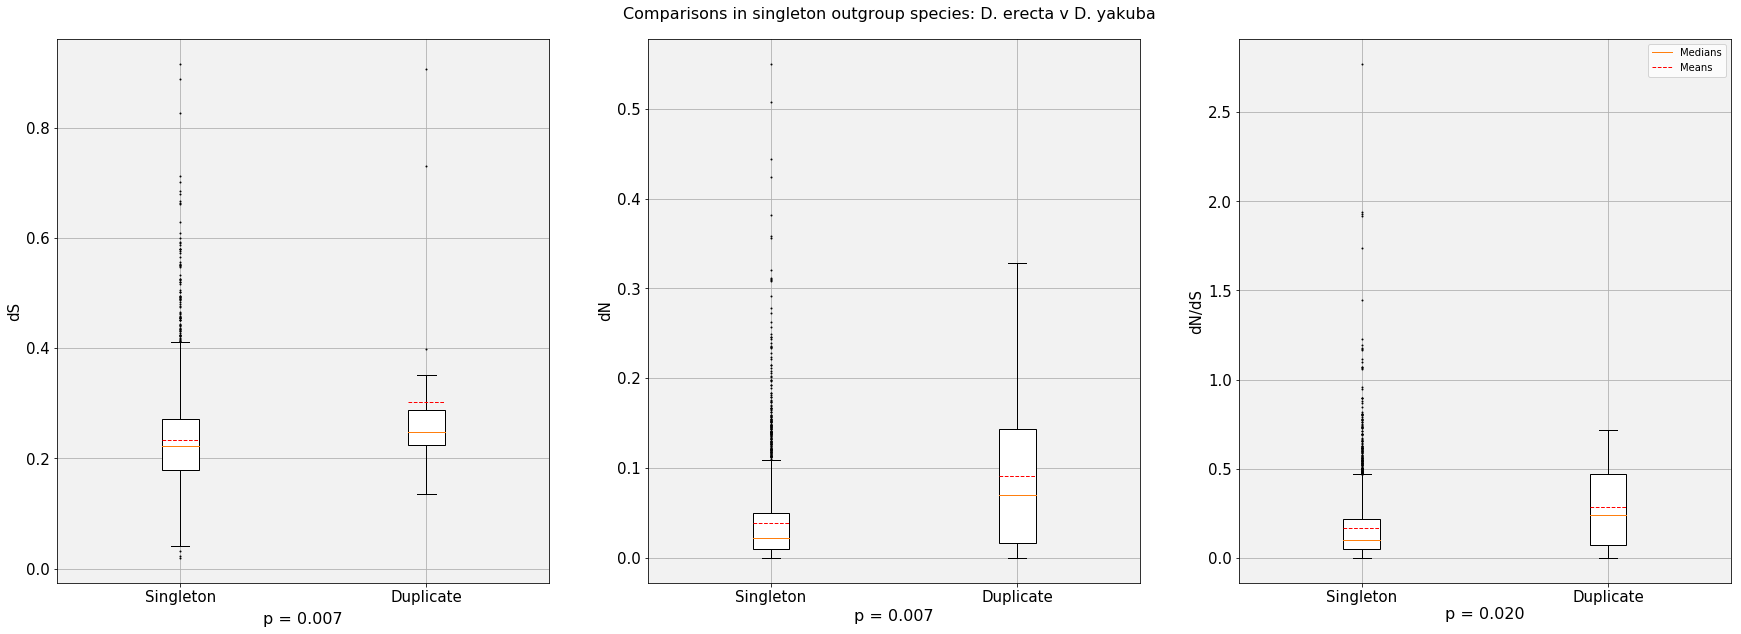

In [328]:
cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dup_status == "S" AND dS2 > 0.01 AND excludedReason IS NULL')
singList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE NOT (proxy_rate IS NULL) AND dup_status == "D" AND dS2 > 0.01 AND excludedReason IS NULL AND (notes IS NULL OR canonical_dup == "Yes")')
dupList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS2 FROM processed_trees WHERE dup_status == "S" AND dS2 > 0.01 AND  excludedReason IS NULL')
singList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS2 FROM processed_trees WHERE dup_status == "D" AND dS2 > 0.01 AND excludedReason IS NULL AND (notes IS NULL OR canonical_dup == "Yes")')
dupList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN2 FROM processed_trees WHERE dup_status == "S" AND dS2 > 0.01 AND excludedReason IS NULL')
singList_dn = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN2 FROM processed_trees WHERE dup_status == "D" AND dS2 > 0.01 AND excludedReason IS NULL AND (notes IS NULL OR canonical_dup == "Yes")')
dupList_dn = [x[0] for x in cursor.fetchall()]

print('Proxy rate p val:')
print(mannwhitneyu(singList_rate, dupList_rate,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_rate,dupList_rate))
print('Medians:',np.median(singList_rate),np.median(dupList_rate))
print('Means:',np.mean(singList_rate),np.mean(dupList_rate))
print('')
print('Proxy dS p val:')
print(mannwhitneyu(singList_ds, dupList_ds,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_ds,dupList_ds))
print('Medians:',np.median(singList_ds),np.median(dupList_ds))
print('Means:',np.mean(singList_ds),np.mean(dupList_ds))
print('')
print('Proxy dN p val:')
print(mannwhitneyu(singList_dn, dupList_dn,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_dn,dupList_dn))
print('Medians:',np.median(singList_dn),np.median(dupList_dn))
print('Means:',np.mean(singList_dn),np.mean(dupList_dn))


fig, axes = plt.subplots(1,3,figsize=(30,10))
ax1, ax2, ax3 = axes
for a in [ax1,ax2,ax3]:
    a.yaxis.set_tick_params(labelsize=15)
    a.xaxis.set_tick_params(labelsize=15)
ax2.text(0.4,0.6,'Comparisons in singleton outgroup species: D. erecta v D. yakuba',fontdict=dict(size=16))

b= ax1.boxplot([singList_ds,dupList_ds], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax1.set_ylabel('dS',fontdict=dict(fontsize=15))
ax1.set_facecolor((0,0,0,0.05))
ax1.grid()


b= ax2.boxplot([singList_dn,dupList_dn], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax2.set_ylabel('dN',fontdict=dict(fontsize=15))
ax2.set_facecolor((0,0,0,0.05))
ax2.grid()



b= ax3.boxplot([singList_rate,dupList_rate], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax3.set_ylabel('dN/dS',fontdict=dict(fontsize=15))
ax3.set_facecolor((0,0,0,0.05))
ax3.grid()
ax3.legend(loc= 'upper right')

ax1.text(1.5,-0.1,'p = 0.007', fontsize=16, ha='center')
ax2.text(1.5,-0.07,'p = 0.007', fontsize=16, ha='center')
ax3.text(1.5,-0.34,'p = 0.020', fontsize=16, ha='center')

# plt.savefig('boxplot_dere_outgroup_proxy_no_dsec_dups.png')
plt.show()

Confirm rate p val:
MannwhitneyuResult(statistic=15392.0, pvalue=0.000835274698309622)
Effect size:
-0.07012253698016695
Medians: 0.1024 0.247
Means: 0.16135322652425457 0.32879710144927543

Confirm dS p val:
MannwhitneyuResult(statistic=21477.5, pvalue=0.16303719621776913)
Effect size:
-0.02928120101875565
Medians: 0.2905 0.3172
Means: 0.3032791277258567 0.38316014492753625

Confirm dN p val:
MannwhitneyuResult(statistic=15058.5, pvalue=0.0005659247318064098)
Effect size:
-0.07236074017516007
Medians: 0.0286 0.0994
Means: 0.049550823319982194 0.14545652173913043


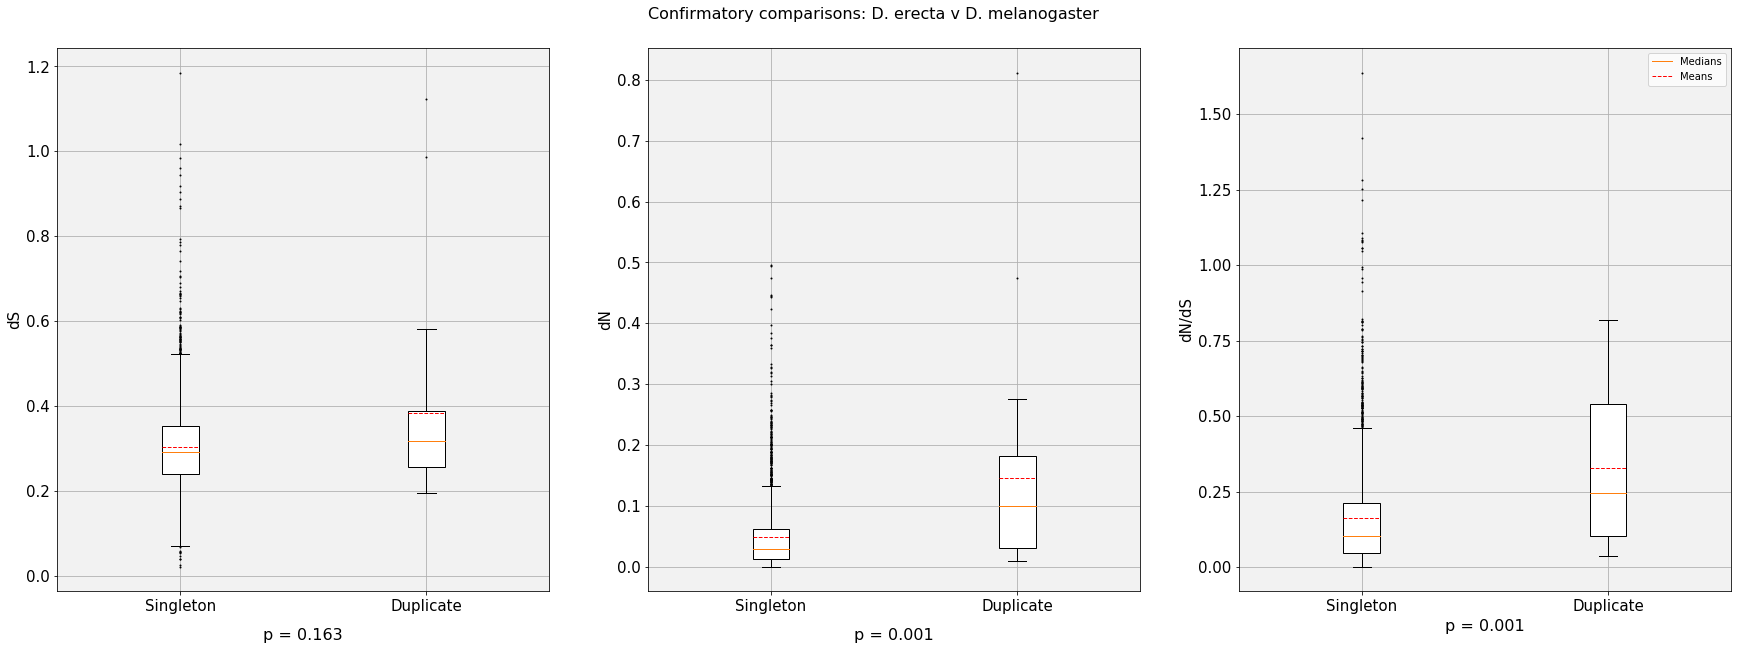

In [335]:
import matplotlib.pyplot as plt
import numpy as np

cursor.execute('SELECT confirm_rate FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "S" AND dS > 0.01 AND excludedReason IS NULL')
singList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT confirm_rate FROM processed_trees WHERE NOT (confirm_rate IS NULL) AND dup_status == "D" AND dS > 0.01 AND excludedReason IS NULL AND (notes IS NULL OR canonical_dup == "Yes")')
dupList_rate = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS FROM processed_trees WHERE dup_status == "S" AND excludedReason IS NULL')
singList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dS FROM processed_trees WHERE dup_status == "D" AND excludedReason IS NULL AND (notes IS NULL OR canonical_dup == "Yes")')
dupList_ds = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN FROM processed_trees WHERE dup_status == "S" AND excludedReason IS NULL')
singList_dn = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT dN FROM processed_trees WHERE dup_status == "D" AND excludedReason IS NULL AND (notes IS NULL OR canonical_dup == "Yes")')
dupList_dn = [x[0] for x in cursor.fetchall()]

print('Confirm rate p val:')
print(mannwhitneyu(singList_rate, dupList_rate,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_rate,dupList_rate))
print('Medians:',np.median(singList_rate),np.median(dupList_rate))
print('Means:',np.mean(singList_rate),np.mean(dupList_rate))
print('')

print('Confirm dS p val:')
print(mannwhitneyu(singList_ds, dupList_ds,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_ds,dupList_ds))
print('Medians:',np.median(singList_ds),np.median(dupList_ds))
print('Means:',np.mean(singList_ds),np.mean(dupList_ds))
print('')
print('Confirm dN p val:')
print(mannwhitneyu(singList_dn, dupList_dn,alternative='two-sided'))
print('Effect size:')
print(mann_whitney_effect_size(singList_dn,dupList_dn))
print('Medians:',np.median(singList_dn),np.median(dupList_dn))
print('Means:',np.mean(singList_dn),np.mean(dupList_dn))




fig, axes = plt.subplots(1,3,figsize=(30,10))
ax1, ax2, ax3 = axes
for a in [ax1,ax2,ax3]:
    a.yaxis.set_tick_params(labelsize=15)
    a.xaxis.set_tick_params(labelsize=15)
ax2.text(0.5,0.9,'Confirmatory comparisons: D. erecta v D. melanogaster',fontdict=dict(size=16))

b= ax1.boxplot([singList_ds,dupList_ds], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax1.set_ylabel('dS',fontdict=dict(fontsize=15))
ax1.set_facecolor((0,0,0,0.05))
ax1.grid()


b= ax2.boxplot([singList_dn,dupList_dn], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax2.set_ylabel('dN',fontdict=dict(fontsize=15))
ax2.set_facecolor((0,0,0,0.05))
ax2.grid()



b= ax3.boxplot([singList_rate,dupList_rate], showmeans= True, meanline= True, flierprops=dict(markersize=1),labels=['Singleton','Duplicate'],patch_artist=True)

for line in b['means']:
    line.set_color((1,0,0,1))
for box in b['boxes']:
    box.set_facecolor((1,1,1,1))
    
l = b['means'][0]
l2 = b['medians'][0]
l.set_label('Means')
l2.set_label('Medians')

ax3.set_ylabel('dN/dS',fontdict=dict(fontsize=15))
ax3.set_facecolor((0,0,0,0.05))
ax3.grid()
ax3.legend(loc='upper right')

ax1.text(1.5,-0.15,'p = 0.163', fontsize=16, ha='center')
ax2.text(1.5,-0.12,'p = 0.001', fontsize=16, ha='center')
ax3.text(1.5,-0.21,'p = 0.001', fontsize=16, ha='center')

# plt.savefig('boxplots_dere_outgroup_no_dsec_dups.png')
plt.show()

In [357]:
noneCount = 0
cursor.execute('SELECT id FROM processed_trees WHERE confirm_rate > 0.5')
highRate = [x[0] for x in cursor.fetchall()]
for g in highRate:
    url1a = 'http://rest.ensembl.org/lookup/id/' + g + '?'
    transID1 = requests.get(url1a, headers=headers).json()['Parent']
    url1b = 'http://rest.ensembl.org/lookup/id/' + transID1 + '?'
    gene = requests.get(url1b, headers=headers).json()['Parent']
    
    url = 'https://rest.ensembl.org/homology/id/' + gene + '?type=orthologues;compara=metazoa'
    r = requests.get(url, headers=headers)
    for x in r.json()['data'][0]['homologies']:
        if 'drosophila' not in x['target']['species']:
            print(g, 'Found some')
            break
    else:
        noneCount += 1
print(noneCount)

FBpp0128881 Found some
FBpp0136417 Found some
FBpp0129091 Found some
FBpp0133736 Found some
FBpp0369520 Found some
FBpp0366587 Found some
FBpp0368779 Found some
FBpp0130388 Found some
FBpp0136095 Found some
FBpp0368478 Found some
FBpp0140610 Found some
114


In [356]:
len(highRate)

125

In [422]:
# cursor.execute('ALTER TABLE processed_trees ADD COLUMN tax_restricted TEXT')
cursor.execute('UPDATE processed_trees SET tax_restricted = ?',(None,))
cursor.execute('SELECT id FROM processed_trees WHERE excludedReason IS NULL')
idList = [x[0] for x in cursor.fetchall()]

for ID in idList:
    done = False
    drosList = []
    while done == False:
        try:
            url1a = 'http://rest.ensembl.org/lookup/id/' + ID + '?'
            transID1 = requests.get(url1a, headers=headers).json()['Parent']
            url1b = 'http://rest.ensembl.org/lookup/id/' + transID1 + '?'
            gene = requests.get(url1b, headers=headers).json()['Parent']

            url = 'https://rest.ensembl.org/homology/id/' + gene + '?type=orthologues;compara=metazoa'
            r = requests.get(url, headers=headers)
            r = r.json()
            done = True
        except Exception:
            print('Exception!')
            time.sleep(0.5)
            done = False

    for x in r['data'][0]['homologies']:
        sp = x['target']['species']
        if 'drosophila' not in sp:
            cursor.execute('UPDATE processed_trees SET tax_restricted = "No" WHERE id == ?',(ID,))
            break
        else:
            drosList.append(sp)
    else:#if tr, check where in the drosophila tree
        print('tr')
        print(drosList)
        if all([not x in drosList for x in ['drosophila_ananassae','drosophila_pseudoobscura','drosophila_persimilis','drosophila_willistoni','drosophila_mojavensis','drosophila_virilis','drosophila_grimshawi']]):
#             mel subgroup specific
            cursor.execute('UPDATE processed_trees SET tax_restricted = "melanogaster_subgroup" WHERE id == ?',(ID,))
        elif all([not x in drosList for x in ['drosophila_pseudoobscura','drosophila_persimilis','drosophila_willistoni','drosophila_mojavensis','drosophila_virilis','drosophila_grimshawi']]):
            cursor.execute('UPDATE processed_trees SET tax_restricted = "melanogaster_group" WHERE id == ?',(ID,))
        elif all([not x in drosList for x in ['drosophila_mojavensis','drosophila_virilis','drosophila_grimshawi']]):
            cursor.execute('UPDATE processed_trees SET tax_restricted = "sophophora" WHERE id == ?',(ID,))
        else:
            cursor.execute('UPDATE processed_trees SET tax_restricted = "drosophila lineage" WHERE id == ?',(ID,))

        
        
db.commit()

tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_willistoni', 'drosophila_pseudoobscura']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_ananassae']
tr
['drosophila_melanogaster', 'drosophila_yakuba', 'drosophila_simulans', 'drosophila_sechellia']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_virilis', 'drosophila_grimshawi', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophil

tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_virilis', 'drosophila_grimshawi', 'drosophila_mojavensis']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_willistoni', 'drosophila_grimshawi', 'drosophila_grimshawi', 'drosophila_virilis', 'drosophila_mojavensis']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila

tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_willistoni', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_willistoni', 'drosophila_virilis', 'drosophila_mojavensis']
tr
['drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_yakuba', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila

tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_grimshawi', 'drosophila_virilis']
tr
['drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_yakuba', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_simulans']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosoph

tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_willistoni', 'drosophila_virilis', 'drosophila_mojavensis', 'drosophila_grimshawi']
tr
['drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_yakuba', 'drosophila_ananassae']
tr
['drosophila_simulans', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_yakuba']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_willistoni', 'drosophila_grimshawi', 'drosophila_mojavensis', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'droso

tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_grimshawi', 'drosophila_mojavensis', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_willistoni', 'drosophila_grimshawi', 'drosophila_virilis', 'drosophila_mojavensis']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_persimilis', 'drosophila_willistoni']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosoph

tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_willistoni', 'drosophila_grimshawi', 'drosophila_virilis']
tr
['drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_yakuba', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_virilis', 'drosophila_grimshawi']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_melanogaster']
tr
['drosophi

tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_virilis', 'drosophila_grimshawi']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_mojavensis', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_virilis', 'drosophila_grimshawi']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_sechellia']
tr
['drosophila_yakuba', 'drosophila_se

tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_melanogaster']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_willistoni', 'drosophila_grimshawi', 'drosophila_virilis', 'drosophila_mojavensis']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_simulans']
tr
['drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_yakuba']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophi

tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia']
tr
['drosophila_simulans', 'drosophila_melanogaster', 'drosophila_yakuba', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_virilis', 'drosophila_grimshawi']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_grimshawi', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_mojavensis', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila

tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_melanogaster']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_grimshawi', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_virilis', 'drosophila_grimshawi']
tr
['drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_yakuba', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_virilis', 'drosophila

tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_willistoni', 'drosophila_persimilis', 'drosophila_pseudoobscura']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_persimilis', 'drosophila_mojavensis', 'drosophila_virilis', 'drosophila_grimshawi']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_virilis', 'drosophila_grimshawi']
tr
['drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_yakuba', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_ananassae']
tr
['dros

tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_virilis', 'drosophila_grimshawi', 'drosophila_mojavensis']
tr
['drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_yakuba', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_willistoni', 'drosophila_mojavensis', 'drosophila_virilis', 'drosophila_virilis', 'drosophila_grimshawi']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_persimilis', 'drosophila_pseudoobscura', 'drosophila_willistoni', 'drosophila_grimshawi', 'drosophila_virilis', 'drosophila_mojavensis']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophi

tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_ananassae', 'drosophila_willistoni', 'drosophila_virilis', 'drosophila_mojavensis', 'drosophila_grimshawi']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_mojavensis', 'drosophila_virilis']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophi

tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia']
tr
['drosophila_yakuba', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_sechellia', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_pseudoobscura', 'drosophila_persimilis']
tr
['drosophila_yakuba', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_sechellia', 'drosophila_ananassae']
tr
['drosophila_yakuba', 'drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster']
tr
['drosophila_sechellia', 'drosophila_melanogaster', 'drosophila_simulans', 'drosophila_yakuba', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_grimshawi']
tr
['drosophila_sechellia', 'drosophila_simulans', 'drosophila_melanogaster', 'drosophila_yakuba', 'drosophila_ananassae', 'drosophila_pseudoobscura', 'drosophila_persimilis', 'drosophila_willistoni', 'drosophila_grimshawi', 'drosophila_virilis', 'drosophila_mojavensis']
tr


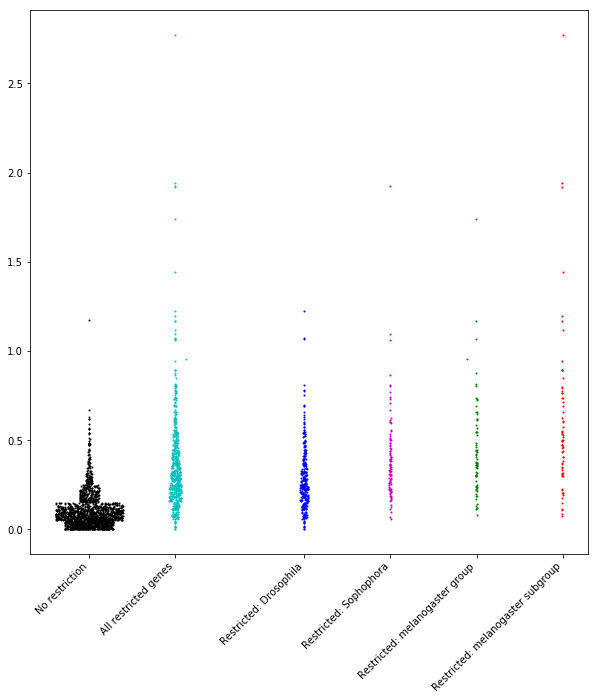

In [489]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
cursor.execute('SELECT proxy_rate FROM processed_trees WHERE tax_restricted == "No" AND dup_status = "S" AND excludedReason IS NULL')
notRestricted = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE tax_restricted == "drosophila lineage" AND dup_status = "S" AND excludedReason IS NULL')
drosRestricted = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE tax_restricted == "sophophora" AND dup_status = "S" AND excludedReason IS NULL')
sophRestricted = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE tax_restricted == "melanogaster_group" AND dup_status = "S" AND excludedReason IS NULL')
melgRestricted = [x[0] for x in cursor.fetchall()]

cursor.execute('SELECT proxy_rate FROM processed_trees WHERE tax_restricted == "melanogaster_subgroup" AND dup_status = "S" AND excludedReason IS NULL AND dS2 > 0.01')
melsRestricted = [x[0] for x in cursor.fetchall()]

allRestricted = []
allRestricted.extend(drosRestricted)
allRestricted.extend(sophRestricted)
allRestricted.extend(melgRestricted)
allRestricted.extend(melsRestricted)

ax.plot(jitter_list(notRestricted, 1,0.01),notRestricted, 'ko',markersize=1,label='Not restricted')
ax.plot(jitter_list(allRestricted, 3,0.01),allRestricted, 'co',markersize=1,label = 'All restricted')

ax.plot(jitter_list(drosRestricted, 6,0.01),drosRestricted, 'bo',markersize=1,label='Restricted: Drosophila')
ax.plot(jitter_list(sophRestricted, 8,0.01),sophRestricted, 'mo',markersize=1, label = 'Restricted: Sophophora')
ax.plot(jitter_list(melgRestricted, 10,0.01),melgRestricted, 'go',markersize=1, label = 'Restricted: melanogaster group')
ax.plot(jitter_list(melsRestricted, 12,0.01),melsRestricted,  'ro',markersize=1, label = 'Restricted: melanogaster subgroup')

ax.set_xticks([1,3,6,8,10,12])
ax.set_xticklabels(['No restriction','All restricted genes','Restricted: Drosophila','Restricted: Sophophora','Restricted: melanogaster group','Restricted: melanogaster subgroup'],ha='right',rotation=45)

plt.show()

Not restricted v restricted: -0.5910174076496525 1.2038939856096923e-172
Drosophila restricted v Sophophora restricted: -0.24421571684823226 6.538963627952574e-07
Sophophora restricted v melanogaster group restricted: -0.10594600761614793 0.16393354538446958
Melanogaster group restricted v melanogaster subgroup restricted: -0.18252351397047914 0.03036555235365338


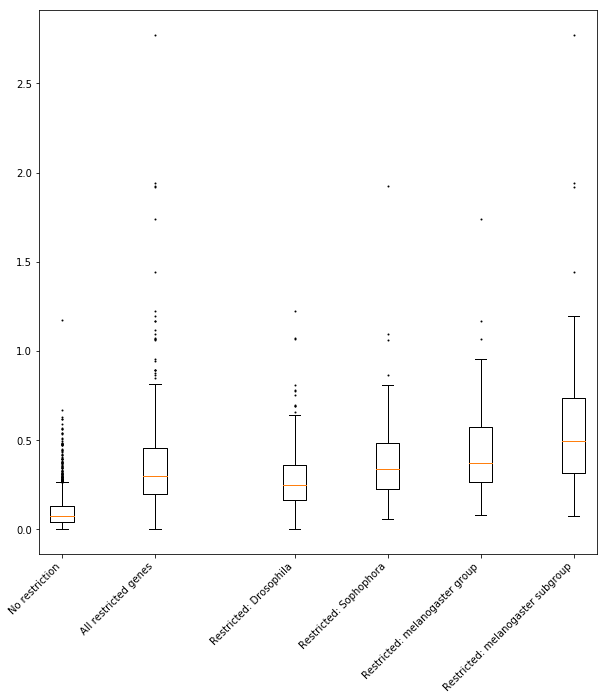

In [490]:
fig, ax = plt.subplots(1,1,figsize = (10,10))

ax.boxplot([notRestricted,allRestricted,drosRestricted,sophRestricted,melgRestricted,melsRestricted],labels = ['No restriction','All restricted genes','Restricted: Drosophila','Restricted: Sophophora','Restricted: melanogaster group','Restricted: melanogaster subgroup'],flierprops=dict(markersize=1),positions=[1,3,6,8,10,12])

# ax.text(s=str(mannwhitneyu(notRestricted,allRestricted,alternative='two-sided').pvalue),x=0.5,y=-0.4)
print('Not restricted v restricted:',mann_whitney_effect_size(notRestricted,allRestricted), str(mannwhitneyu(notRestricted,allRestricted,alternative='two-sided').pvalue))

# ax.text(s=str(mannwhitneyu(drosRestricted,sophRestricted,alternative='two-sided').pvalue),x=2.5,y=-0.4)
print('Drosophila restricted v Sophophora restricted:',mann_whitney_effect_size(drosRestricted,sophRestricted),mannwhitneyu(drosRestricted,sophRestricted,alternative='two-sided').pvalue)

# ax.text(s=str(mannwhitneyu(sophRestricted,melgRestricted,alternative='two-sided').pvalue),x=4,y=-0.4)
print('Sophophora restricted v melanogaster group restricted:',mann_whitney_effect_size(sophRestricted,melgRestricted),mannwhitneyu(sophRestricted,melgRestricted,alternative='two-sided').pvalue)

# ax.text(s=str(mannwhitneyu(melgRestricted,melsRestricted,alternative='two-sided').pvalue),x=4,y=-0.4)
print('Melanogaster group restricted v melanogaster subgroup restricted:',mann_whitney_effect_size(melgRestricted,melsRestricted),mannwhitneyu(melgRestricted,melsRestricted,alternative='two-sided').pvalue)

ax.set_xticks([1,3,6,8,10,12])
ax.set_xticklabels(['No restriction','All restricted genes','Restricted: Drosophila','Restricted: Sophophora','Restricted: melanogaster group','Restricted: melanogaster subgroup'],ha='right',rotation=45)


plt.show()

In [433]:
def dec_range(start, stop, step):
    r = start
    while r < stop:
        yield r
        r += step
def jitter_list(l, center=0, step = 0.1):
    import random
    if center != 0:
        test_list = [round(x, 1) for x in l]
        out_list = []
        for x in l:
            if round(x,1) == 1:
                c = 0.39
            else:
                c = test_list.count(round(x,1))
                c = c*0.001
            out_list.append(random.sample(list(dec_range(center-c, center + c, step)), 1)[0])
        
        return out_list
    else:
        test_list = [round(x, 1) for x in l]
        out_list = []
        for x in l:
            if test_list.count(round(x,1)) < 9:
                c = test_list.count(round(x,1))
            else:
                c = 9
            out_list.append(random.sample(list(dec_range(-c, c, step)), 1)[0])
        return out_list

In [478]:
from scipy.stats import kruskal
kruskal(drosRestricted,sophRestricted,melgRestricted,melsRestricted)

KruskalResult(statistic=82.53989476908868, pvalue=8.752473123223635e-18)

In [484]:
ll = [drosRestricted,sophRestricted,melgRestricted,melsRestricted]
lnames = ['dros','soph','melg','mels']
ldict = {'dros':drosRestricted,'soph':sophRestricted,'melg':melgRestricted,'mels':melsRestricted}
doneList = []
for a in lnames:
    for b in lnames:
        if a != b and (a,b) not in doneList and (b,a) not in doneList:
            print(a,b,mannwhitneyu(ldict[a],ldict[b],alternative='two-sided').pvalue*6)
            doneList.append((a,b))

dros soph 3.9233781767715445e-06
dros melg 1.1996920433309145e-07
dros mels 1.8356717920222407e-12
soph melg 0.9836012723068175
soph mels 0.0018626432920319622
melg mels 0.1821933141219203


In [529]:
cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted == "No" AND dup_status == "S"')
notSing = cursor.fetchall()
cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted != "No" AND tax_restricted IS NOT NULL AND dup_status == "S"')
resSing = cursor.fetchall()
cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted == "drosophila lineage" AND tax_restricted IS NOT NULL AND dup_status == "S" AND (notes IS NULL OR canonical_dup == "Yes")')
drosSing = cursor.fetchall()
cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted == "sophophora" AND tax_restricted IS NOT NULL AND dup_status == "S" AND (notes IS NULL OR canonical_dup == "Yes")')
sophSing = cursor.fetchall()
cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted == "melanogaster_group" AND tax_restricted IS NOT NULL AND dup_status == "S" AND (notes IS NULL OR canonical_dup == "Yes")')
melgSing= cursor.fetchall()
cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted == "melanogaster_subgroup" AND tax_restricted IS NOT NULL AND dup_status == "S" AND (notes IS NULL OR canonical_dup == "Yes")')
melsSing = cursor.fetchall()
print(notSing,resSing,drosSing,sophSing,melgSing,melsSing)

cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted == "No" AND dup_status == "D" AND (notes IS NULL OR canonical_dup == "Yes")')
notDup = cursor.fetchall()
cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted != "No" AND tax_restricted IS NOT NULL AND dup_status == "D" AND (notes IS NULL OR canonical_dup == "Yes")')
resDup = cursor.fetchall()
cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted == "drosophila lineage" AND tax_restricted IS NOT NULL AND dup_status == "D" AND (notes IS NULL OR canonical_dup == "Yes")')
drosDup = cursor.fetchall()
cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted == "sophophora" AND tax_restricted IS NOT NULL AND dup_status == "D" AND (notes IS NULL OR canonical_dup == "Yes")')
sophDup = cursor.fetchall()
cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted == "melanogaster_group" AND tax_restricted IS NOT NULL AND dup_status == "D" AND (notes IS NULL OR canonical_dup == "Yes")')
melgDup = cursor.fetchall()
cursor.execute('SELECT COUNT(id) FROM processed_trees WHERE tax_restricted == "melanogaster_subgroup" AND tax_restricted IS NOT NULL AND dup_status == "D" AND (notes IS NULL OR canonical_dup == "Yes")')
melsDup = cursor.fetchall()

print(notDup,resDup,drosDup,sophDup,melgDup,melsDup)

[(1690,)] [(557,)] [(314,)] [(101,)] [(72,)] [(70,)]
[(14,)] [(9,)] [(4,)] [(2,)] [(0,)] [(3,)]


In [526]:
from scipy.stats import chi2_contingency
chi2_contingency([[9,14],[557,1690]])

(1.7943748950477225,
 0.18039403299135315,
 1,
 array([[   5.73480176,   17.26519824],
        [ 560.26519824, 1686.73480176]]))

In [532]:
# suppose should check the yakuba duplications excluded in case of mistakes
yakDup = 0
cursor.execute('SELECT id, prunedTree FROM singleton_trees WHERE excludedReason == "Multiple copies in outgroup-split not possible/subtrees unsuitable"')
for ID, tree in cursor.fetchall():
    yakCount, ereCount = 0,0
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dyak' in node.name:
            yakCount += 1
        elif 'Dere' in node.name:
            ereCount += 1
    if yakCount > 1 and ereCount < 2: #duplicated in yakuba only
        yakDup += 1
print(yakDup)

154


In [543]:
# add columns for annotated split all/some/none, actual dups Y/N, all for Dyak dups specifically
# cursor.execute('ALTER TABLE singleton_trees ADD COLUMN annotated_split_yak TEXT')
# cursor.execute('ALTER TABLE singleton_trees ADD COLUMN canonical_dup_yak TEXT')
# update annotated split genes (for all dups only in Dyak) - record if other dups exist in tree for Dyak: if not can include: might have to figure out how to concatenate splits?
import time
res = []
cursor.execute('SELECT id, prunedTree FROM singleton_trees WHERE excludedReason == "Multiple copies in outgroup-split not possible/subtrees unsuitable"')
for ID, tree in cursor.fetchall():
    yakCount, ereCount = 0,0
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dyak' in node.name:
            yakCount += 1
        elif 'Dere' in node.name:
            ereCount += 1
    if yakCount > 1 and ereCount < 2: #duplicated in yakuba only
        res.append((ID,tree))
with open('dubiousDyakParalogs.fasta','w') as file:
    for ID, tree in res:
        dyakList = []
        homList = []
        pairsDone = []
#         tree = PhyloTree(tree)
        for node in tree.traverse():
            if 'Dyak' in node.name:
                geneName = re.search('.*_(FB.*)_',node.name).group(1)
                dyakList.append(geneName)
        for p in dyakList:
            for p2 in dyakList:
                if p != p2:
                    if (p,p2) not in pairsDone and (p2,p) not in pairsDone:
                        cursor.execute('SELECT homology_type FROM Dyak_paralogs WHERE (id == ? AND para_id == ?)',(p,p2))
                        h = cursor.fetchall()
                        if h == []: #not in the table, predates mel subgroup
                            homList.append('good')
                        elif h[0][0] == "gene_split":
                            homList.append('split')
                        else:
                            homList.append('good')
                        if len(set(homList)) == 1 and 'split' in set(homList):
                            cursor.execute('UPDATE singleton_trees SET annotated_split_yak = "all" WHERE id == ?',(ID,))
                        elif len(set(homList)) == 1 and 'good' in set(homList):
#                             print(p,p2)
                            cursor.execute('UPDATE singleton_trees SET annotated_split_yak = "none" WHERE id == ?',(ID,))
                            # for any other pairs, check blast hits (what cutoffs to use?)
                            # need to get gene seqs for each id to blast against the long read assembly
                            done = False
                            while done == False:
                                try:
                                    url1a = 'http://rest.ensembl.org/lookup/id/' + p + '?'
                                    transID1 = requests.get(url1a, headers=headers).json()['Parent']
                                    url1b = 'http://rest.ensembl.org/lookup/id/' + transID1 + '?'
                                    geneID1 = requests.get(url1b, headers=headers).json()['Parent']

                                    url2a = 'http://rest.ensembl.org/lookup/id/' + p2 + '?'
                                    transID2 = requests.get(url2a, headers=headers).json()['Parent']
                                    url2b = 'http://rest.ensembl.org/lookup/id/' + transID2 + '?'
                                    geneID2 = requests.get(url2b, headers=headers).json()['Parent']

                                    seqUrl1 = 'http://rest.ensembl.org/sequence/id/' + geneID1 + '?'
                                    geneSeq1 = requests.get(seqUrl1, headers=headers).json()['seq']
                                    seqUrl2 = 'http://rest.ensembl.org/sequence/id/' + geneID2 + '?'
                                    geneSeq2 = requests.get(seqUrl2, headers=headers).json()['seq']

                                    done = True
                                except Exception as e:
                                    time.sleep(1)
                                    print('Trying again:',p,p2)
                                    done = False
                            file.write('>'+p+'\n')
                            file.write(geneSeq1+'\n')
                            file.write('>'+p2+'\n')
                            file.write(geneSeq2+'\n')
                            # do I need to do a run for each one? Prob not? just write all to a fasta? - all dubiously dup'd genes to be blasted then look up hits in output
                        elif len(set(homList)) == 2:
                            cursor.execute('UPDATE singleton_trees SET annotated_split_yak = "some" WHERE id == ?',(ID,))
                        pairsDone.append((p,p2))
db.commit()

In [544]:
%%bash
makeblastdb -in Dyak_miller_assembly.fasta -dbtype nucl
time blastn -db Dyak_miller_assembly.fasta -query dubiousDyakParalogs.fasta -out dubiousParalogHitsYak.out -outfmt 6



Building a new DB, current time: 07/04/2019 15:13:29
New DB name:   /Users/zoevance/Dyak_miller_assembly.fasta
New DB title:  Dyak_miller_assembly.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 111 sequences in 2.70859 seconds.



real	0m58.952s
user	0m53.804s
sys	0m1.075s


In [546]:
res = []
cursor.execute('SELECT id, prunedTree FROM singleton_trees WHERE excludedReason == "Multiple copies in outgroup-split not possible/subtrees unsuitable"')
for ID, tree in cursor.fetchall():
    yakCount, ereCount = 0,0
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dyak' in node.name:
            yakCount += 1
        elif 'Dere' in node.name:
            ereCount += 1
    if yakCount > 1 and ereCount < 2: #duplicated in yakuba only
        res.append((ID,tree))
dyakOutList = []
with open('dubiousDyakParalogs.fasta','w') as file:
    for ID, tree in res:
        dyakList = []
        homList = []
        pairsDone = []
#         tree = PhyloTree(tree)
        for node in tree.traverse():
            if 'Dyak' in node.name:
                geneName = re.search('.*_(FB.*)_',node.name).group(1)
                dyakList.append(geneName)
        for p in dyakList:
            for p2 in dyakList:
                if p != p2:
                    if (p,p2) not in pairsDone and (p2,p) not in pairsDone:
                        dyakOutList.append((p,p2))

In [581]:
pairsDone = []
fig,axes = plt.subplots(10,1,figsize=(30,80))
axCount = 0
countBreak = 0
for p, p2 in dyakOutList[141:]:
    if (p,p2) not in pairsDone and (p2,p) not in pairsDone:
        countBreak += 1
        if countBreak > 10:
            break
        
        resDict = {p:[],p2:[]}

        with open('dubiousParalogHitsYak.out','r') as file:
            for line in file:
                line = line.strip('\n').split('\t')
                if line[0] == p or line[0] == p2:
                    resDict[line[0]].append((min(line[8:10]),max(line[8:10]),line[11],line[1]))

        count = 1
        axes[axCount].text((axes[axCount].get_xlim()[1]+axes[axCount].get_xlim()[0])/2,axes[axCount].get_ylim()[1]+0.2,p+' - '+p2)
        if len(set([x[3] for x in resDict[p]])) > 1:
            print('Multiple scaffolds: ', p)
        for entry in resDict[p]:
            axes[axCount].plot([float(entry[0]),float(entry[1])],[count,count],lw = float(entry[2])/100,color='b')
            count += 1
        if len(set([x[3] for x in resDict[p2]])) > 1:
            print('Multiple scaffolds: ', p2)
        for entry in resDict[p2]:   
            axes[axCount].plot([float(entry[0]),float(entry[1])],[count,count],lw = float(entry[2])/100,color='r')
            count += 1
        pairsDone.append((p,p2))
        print(p,p2)

        axCount += 1

plt.savefig('hit_comp_yak_140_150.png')
plt.show()

FBpp0355650 FBpp0353761
Multiple scaffolds:  FBpp0268006
FBpp0268006 FBpp0259823
FBpp0357603 FBpp0360955
Multiple scaffolds:  FBpp0267756
Multiple scaffolds:  FBpp0267412
FBpp0267756 FBpp0267412
FBpp0267404 FBpp0267750
FBpp0262546 FBpp0270504
FBpp0358873 FBpp0362723
FBpp0267359 FBpp0267970
FBpp0355185 FBpp0359725
FBpp0260888 FBpp0259586


ValueError: Image size of 4695077x4383 pixels is too large. It must be less than 2^16 in each direction.

In [ ]:
# need to try and screen pairs as right/not right programmatically
# can also include ways to select the sequence to be aligned if using these trees eg in the case of overlapping genes pick the longest one
# for split genes, concatenate


In [605]:
pairsDone = []
resDict = {}
for p, p2 in dyakOutList:
    if (p,p2) not in pairsDone and (p2,p) not in pairsDone:
        
        resDict[p]= []
        resDict[p2] =[]

        with open('dubiousParalogHitsYak.out','r') as file:
            for line in file:
                line = line.strip('\n').split('\t')
                line[8] = int(line[8])
                line[9] = int(line[9])
                if line[0] == p or line[0] == p2:
                    resDict[line[0]].append((min(line[8:10]),max(line[8:10]),line[11],line[1]))
        pairsDone.append((p,p2))
count, goodCount,within_count = 0,0,0
doneList = []
for p,p2 in dyakOutList:
    if (p,p2) not in doneList and (p2,p) not in doneList:
        count += 1
        try:
            x = resDict[p]
        except KeyError:
            resDict[p] = []
        try:
            x = resDict[p2]
        except KeyError:
            resDict[p2] = []
        if len(resDict[p]) == 1 and len(resDict[p2]) == 1:
            goodCount += 1
            try:
                if (((resDict[p][0][0]) in range(resDict[p2][0][0],resDict[p2][0][1]) and (resDict[p][0][1]) in range(resDict[p2][0][0],resDict[p2][0][1]))) or ((resDict[p2][0][0] in range(resDict[p][0][0],resDict[p][0][1])) and (resDict[p2][0][1] in range(resDict[p][0][0],resDict[p][0][1]))):
                      within_count += 1
            except IndexError:
                continue
print(count,goodCount,within_count)

340 220 114


In [606]:
import time
res = []
cursor.execute('SELECT id, prunedTree FROM singleton_trees WHERE excludedReason == "Multiple copies in outgroup-split not possible/subtrees unsuitable"')
wef = 0
for ID, tree in cursor.fetchall():
    yakCount, ereCount = 0,0
    pairsDone = []
    tree = PhyloTree(tree)
    for node in tree.traverse():
        if 'Dyak' in node.name:
            yakCount += 1
        elif 'Dere' in node.name:
            ereCount += 1
    if yakCount > 1 and ereCount < 2: #duplicated in yakuba only
        for node in tree.traverse():
            if 'Dyak' in node.name:
                geneName = re.search('.*_(FB.*)_',node.name).group(1)
                dyakList.append(geneName)
        for p in dyakList:
            for p2 in dyakList:
                if p != p2:
                    if (p,p2) not in pairsDone and (p2,p) not in pairsDone:
                        pairsDone.append((p,p2))
#                         check all pairs in the tree
                        resDict = {p:[],p2:[]}

                        with open('dubiousParalogHitsYak.out','r') as file:
                            for line in file:
                                line = line.strip('\n').split('\t')
                                line[8] = int(line[8])
                                line[9] = int(line[9])
                                if line[0] == p or line[0] == p2:
                                    resDict[line[0]].append((min(line[8:10]),max(line[8:10]),line[11],line[1]))
                        if len(resDict[p]) == 1 and len(resDict[p2]) == 1:
                            try:
                                if (((resDict[p][0][0]) in range(resDict[p2][0][0],resDict[p2][0][1]) and (resDict[p][0][1]) in range(resDict[p2][0][0],resDict[p2][0][1]))) or ((resDict[p2][0][0] in range(resDict[p][0][0],resDict[p][0][1])) and (resDict[p2][0][1] in range(resDict[p][0][0],resDict[p][0][1]))):
#                                     pairs that are just one gene
                                    dmel,dsim = 0,0
                                    for node in tree.traverse():
                                        if 'Dmel' in node.name:
                                            dmel += 1
                                        elif 'Dsim' in node.name:
                                            dsim +=1
                                    if dmel > 1 or dsim > 1:
                                        wef += 1
                            except IndexError:
                                continue
                        
    else:
        cursor.execute('UPDATE singleton_trees SET canonical_dup_yak = "erecta_dup" WHERE id == ?',(ID,))

print(wef)#might not be accurate, will increment per pair in dup trees    

KeyboardInterrupt: 

40